In [102]:

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date # Date Functions
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
#from keras.optimizers import Adam # For detailed configuration of the optimizer
import seaborn as sns # Visualization
plt.rcParams["grid.color"] = "k"  # Esto pone una cuadrícula con líneas de color negro
plt.rcParams["grid.alpha"] = 0.1  # Esto hace que las líneas de la cuadrícula sean muy transparentes
%matplotlib inline
from google.colab import files
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler


In [103]:
daily_variables = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Market Cap']
indicators = ['RSI', 'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER', 'HBOLLINGER', 'FI']
daily_variables.extend(indicators)

dataframes = {}
lagged_dataframes = {}
stationary_dataframes = {}
lagged_stationary_dataframes = {}


In [104]:
brands = ['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC' ]

In [105]:
def set_index(df):
   df = df.set_index('Date')
   df.index.name = 'Date'
   df.index = pd.to_datetime(df.index)
   return df


In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
for brand in brands:
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Merged_Data/{brand}-merged.csv')
   dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Lags/Non_Stationary/{brand}_lagged_non_stationary.csv')
   lagged_dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Estacionaridad/{brand}_stationary.csv')
   stationary_dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Lags/Stationary/{brand}_lagged_stationary.csv')
   lagged_stationary_dataframes[brand] = set_index(df)

In [111]:
# Ahora, calcula y muestra la varianza para el último 20% de los datos en la columna 'Target' en cada dataframe
for brand, dataframe in lagged_stationary_dataframes.items():
   # Selecciona el último 20% de las filas
   last_20_percent = dataframe['Target'].tail(int(len(dataframe) * 0.2))

   # Calcula la varianza para el último 20% de las filas
   variance = last_20_percent.var()

   print(f'Para la marca {brand}, la varianza del último 20% de los datos es: {variance}')

Para la marca F, la varianza del último 20% de los datos es: 0.004741709237921992
Para la marca GM, la varianza del último 20% de los datos es: 0.0038389681510298465
Para la marca TSLA, la varianza del último 20% de los datos es: 0.009757796433604773
Para la marca RACE, la varianza del último 20% de los datos es: 0.0013975557039284934
Para la marca TM, la varianza del último 20% de los datos es: 0.0013464465837679169
Para la marca HMC, la varianza del último 20% de los datos es: 0.0016982781965180387


In [ ]:
import numpy as np
import pandas as pd

# suponiendo que df es tu DataFrame
def count_inf(df):
    return ((df == np.inf) | (df == -np.inf)).sum()

for brand in brands:

  df = stationary_dataframes[brand].copy()

  inf_count = df.apply(count_inf)
  inf_count = inf_count[inf_count > 0]

  print(brand, inf_count)



F Series([], dtype: int64)
GM Series([], dtype: int64)
TSLA Series([], dtype: int64)
RACE Series([], dtype: int64)
TM Series([], dtype: int64)
HMC Series([], dtype: int64)


# FEATURE SELECTION


LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
# Define the model
alphas = np.logspace(-4, -1, 1000)

lassofeatures_nolags = {}
lassofeatures_lags = {}


for counter in range(2):
  if counter == 0:
    print('Stationary DataFrames:-------------------------------------------------------')
    plt.figure(figsize=(10, 6))

  else:
    print('\n \n \n')
    print('Stationary Lagged DataFrames:-------------------------------------------------------')
    plt.figure(figsize=(10, 6))

  for brand in brands:
    if counter == 0:
      dfs = stationary_dataframes[brand].copy()

    else:
      dfs =  lagged_stationary_dataframes[brand].copy()

    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
    df_target = dfs['Target']

    # Crea una instancia de la clase Lasso
    lasso = Lasso()

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)  # replace with your preferred number of splits

    # Scaling the features
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
    scaler_pred = RobustScaler()
    df_target_scaled = pd.Series(scaler_pred.fit_transform(df_target.values.reshape(-1, 1)).flatten())

    # Define the grid search
    grid = GridSearchCV(estimator=lasso, param_grid=dict(alpha=alphas), cv=tscv, n_jobs = -1, return_train_score=True)
    grid.fit(df_features_scaled, df_target_scaled)
    # Print the best alpha
    print('Best alpha: ', grid.best_estimator_.alpha)

    # Create a selector object that uses the Lasso model to identify features with non-zero coefficients
    sel_ = SelectFromModel(grid.best_estimator_)  # Uses the best model from the grid

    # Fit the selector object to the data
    sel_.fit(df_features_scaled, df_target_scaled)

    # Print the names of the most important features
    selected_feat = df_features.columns[(sel_.get_support())]
    print(brand)
    print('Lasso for', brand, 'has selected the following features:\n', selected_feat)
    if counter == 0:
      lassofeatures_nolags[brand] = selected_feat
    else:
      lassofeatures_lags[brand] = selected_feat

    # Plot the mean cross-validation score as a function of alpha
    plt.semilogx(alphas, -grid.cv_results_["mean_test_score"], label=brand)

  # Añade etiquetas y título
  plt.xlabel('Alpha')
  plt.ylabel('Mean cross-validation score')
  plt.title('Cross-validation score as a function of alpha')
  plt.legend()
  plt.grid()
  plt.show()

Stationary DataFrames:-------------------------------------------------------


KeyboardInterrupt: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
selected_feat[120:190]

Index(['Revenue Growth (YoY)_lag5', 'Net Income Growth_lag4',
       'Net Income Growth_lag5', 'Shares Outstanding (Basic)_lag2',
       'Shares Outstanding (Basic)_lag3', 'Shares Outstanding (Basic)_lag5',
       'Effective Tax Rate_lag2', 'Effective Tax Rate_lag3',
       'Effective Tax Rate_lag4', 'PE Ratio_lag1', 'PE Ratio_lag2',
       'PE Ratio_lag4', 'PE Ratio_lag5', 'PB Ratio_lag3', 'PB Ratio_lag5',
       'Current Ratio_lag1', 'Current Ratio_lag4', 'Current Ratio_lag5'],
      dtype='object')

{}

In [7]:

lassofeatures_nolags = {}
lassofeatures_lags = {}

lassofeatures_nolags['F'] = ['High', 'MA1', 'Cash & Equivalents', 'Cash & Cash Equivalents',
       'Other Current Assets', 'Other Long-Term Assets', 'Current Debt',
       'Total Current Liabilities', 'Other Current Liabilities',
       'Retained Earnings', 'Comprehensive Income', "Shareholders' Equity",
       'Net Cash Per Share', 'Working Capital', 'Other Operating Activities',
       'Operating Cash Flow', 'Other Investing Activities',
       'Investing Cash Flow', 'Debt Issued / Paid',
       'Other Financing Activities', 'Net Cash Flow', 'Free Cash Flow Growth',
       'Gross Profit', 'Selling, General & Admin', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income',
       'Shares Outstanding (Basic)', 'Shares Outstanding (Diluted)',
       'EPS (Basic)', 'EPS (Diluted)', 'Gross Margin', 'Operating Margin',
       'Profit Margin', 'Effective Tax Rate', 'EBITDA Margin', 'PE Ratio',
       'PS Ratio', 'Current Ratio', 'Buyback Yield / Dilution',
       'Total Shareholder Return', 'MACD', 'CMF', 'LBOLLINGER', 'HBOLLINGER']
lassofeatures_nolags['GM'] = ['MA1', 'MA2', 'Cash & Equivalents', 'Cash Growth',
       'Other Current Assets', 'Other Long-Term Assets', 'Long-Term Debt',
       'Common Stock', 'Comprehensive Income', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Other Investing Activities', 'Investing Cash Flow', 'Dividends Paid',
       'Debt Issued / Paid', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow Margin_x', 'Cost of Revenue', 'Gross Profit',
       'Other Expense / Income', 'Pretax Income', 'Net Income Growth',
       'Shares Outstanding (Basic)', 'Shares Change', 'Profit Margin',
       'Market Cap Growth', 'EMA50', 'MACD', 'CMF', 'LBOLLINGER']

lassofeatures_nolags['TSLA'] =['MA1', 'Cash Growth', 'Other Current Assets', 'Deferred Revenue',
       'Current Debt', 'Long-Term Debt', 'Debt Growth', 'Retained Earnings',
       'Net Cash / Debt', 'Share-Based Compensation',
       'Other Operating Activities', 'Operating Cash Flow Growth',
       'Other Investing Activities', 'Investing Cash Flow',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Free Cash Flow Growth', 'Revenue',
       'Revenue Growth (YoY)', 'Research & Development',
       'Other Expense / Income', 'Pretax Income', 'Income Tax',
       'Shares Outstanding (Diluted)', 'EPS Growth', 'EBITDA', 'PE Ratio',
       'PS Ratio', 'MACD', 'CMF', 'FI']
lassofeatures_nolags['RACE'] = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2',
       'Cash & Equivalents', 'Short-Term Investments', 'Cash Growth',
       'Receivables', 'Inventory', 'Total Current Assets',
       'Long-Term Investments', 'Goodwill and Intangibles',
       'Other Long-Term Assets', 'Total Long-Term Assets', 'Accounts Payable',
       'Common Stock', 'Net Cash / Debt', 'Net Cash / Debt Growth',
       'Net Income_x', 'Depreciation & Amortization_x',
       'Other Operating Activities', 'Operating Cash Flow Growth',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Free Cash Flow Growth', 'Revenue',
       'Revenue Growth (YoY)', 'Cost of Revenue', 'Gross Profit',
       'Selling, General & Admin', 'Operating Income',
       'Other Expense / Income', 'Income Tax', 'Net Income_y',
       'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth',
       'Dividend Growth', 'Gross Margin', 'Operating Margin',
       'Effective Tax Rate', 'EBITDA', 'Depreciation & Amortization_y', 'EBIT',
       'EBIT Margin', 'Market Cap', 'Market Capitalization',
       'Market Cap Growth', 'Enterprise Value', 'PE Ratio', 'PS Ratio', 'RSI',
       'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER',
       'HBOLLINGER', 'FI']

lassofeatures_nolags['TM'] = ['Cash Growth', 'Other Long-Term Assets', 'Common Stock',
       'Working Capital', 'Net Income_x', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Change in Investments', 'Other Investing Activities',
       'Share Issuance / Repurchase', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow', 'Cost of Revenue', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income', 'Income Tax',
       'Net Income_y', 'EPS (Diluted)', 'EPS Growth', 'Dividend Growth',
       'Effective Tax Rate', 'Market Cap Growth', 'Enterprise Value', 'EMA14',
       'MACD', 'CMF', 'LBOLLINGER', 'FI']

lassofeatures_nolags['HMC'] = ['Cash Growth', 'Property, Plant & Equipment', 'Debt Growth',
       'Common Stock', 'Working Capital', 'Depreciation & Amortization_x',
       'Operating Cash Flow', 'Capital Expenditures', 'Change in Investments',
       'Other Investing Activities', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow', 'Free Cash Flow Per Share_x',
       'Other Expense / Income', 'Net Income Growth', 'EPS Growth',
       'Free Cash Flow Per Share_y', 'Gross Margin', 'Operating Margin',
       'Profit Margin', 'Effective Tax Rate', 'EBITDA Margin',
       'Depreciation & Amortization_y', 'EBIT Margin', 'Market Cap Growth',
       'Enterprise Value', 'PE Ratio', 'Current Ratio', 'EMA50', 'MACD', 'CMF',
       'FI']

lassofeatures_lags['F'] =['Open', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Cash & Equivalents',
       'Short-Term Investments', 'Cash & Cash Equivalents',
       'Other Current Assets', 'Long-Term Investments', 'Current Debt',
       'Other Current Liabilities', 'Total Debt', 'Common Stock',
       'Retained Earnings', 'Comprehensive Income', "Shareholders' Equity",
       'Net Cash / Debt', 'Working Capital', 'Book Value Per Share',
       'Other Operating Activities', 'Operating Cash Flow',
       'Change in Investments', 'Other Investing Activities',
       'Investing Cash Flow', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Free Cash Flow',
       'Free Cash Flow Growth', 'Free Cash Flow Margin_x', 'Gross Profit',
       'Selling, General & Admin', 'Operating Expenses', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income', 'Income Tax',
       'Net Income_y', 'Shares Outstanding (Basic)', 'EPS (Basic)',
       'EPS (Diluted)', 'Free Cash Flow Margin_y', 'EBIT', 'EBIT Margin',
       'Market Cap', 'PE Ratio', 'Debt / Equity Ratio', 'Current Ratio',
       'Buyback Yield / Dilution', 'EMA14', 'MACD', 'CMF', 'HBOLLINGER', 'FI',
       'Open_lag1', 'Open_lag2', 'Open_lag3', 'Open_lag4', 'Open_lag5',
       'Open_lag6', 'Open_lag8', 'Open_lag9', 'Open_lag10', 'Open_lag11',
       'Open_lag12', 'Open_lag13', 'Open_lag14', 'Open_lag15', 'Open_lag16',
       'Open_lag17', 'Close_lag2', 'Close_lag9', 'Close_lag10', 'Close_lag11',
       'Close_lag12', 'Close_lag13', 'Close_lag14', 'Close_lag15', 'Close_lag16', 'High_lag1', 'High_lag2', 'High_lag3', 'High_lag5',
       'High_lag7', 'High_lag8', 'High_lag9', 'High_lag10', 'High_lag11',
       'High_lag12', 'High_lag13', 'High_lag14', 'High_lag16', 'High_lag17',
       'High_lag18', 'High_lag19', 'High_lag20', 'Low_lag1', 'Low_lag3',
       'Low_lag4', 'Low_lag5', 'Low_lag6', 'Low_lag7', 'Low_lag8', 'Low_lag9',
       'Low_lag10', 'Low_lag14', 'Low_lag15', 'Low_lag16', 'Low_lag17',
       'Low_lag18', 'Low_lag19', 'Low_lag20', 'Volume_lag1', 'Volume_lag2',
       'Volume_lag3', 'Volume_lag4', 'Volume_lag5', 'Volume_lag6',
       'Volume_lag7', 'Volume_lag8', 'Volume_lag9', 'Volume_lag10',
       'Volume_lag11', 'Volume_lag12', 'Volume_lag13', 'Volume_lag14',
       'Volume_lag15', 'Volume_lag16', 'Volume_lag17', 'Volume_lag18',
       'Volume_lag19', 'Volume_lag20', 'MA1_lag1', 'MA1_lag5', 'MA1_lag7',
       'MA1_lag8', 'MA1_lag9', 'MA1_lag10', 'MA1_lag11', 'MA1_lag12',
       'MA1_lag13', 'MA1_lag15', 'MA1_lag16', 'MA1_lag17', 'MA1_lag19',
       'MA1_lag20', 'MA2_lag1', 'MA2_lag2', 'MA2_lag4', 'MA2_lag9',
       'MA2_lag13', 'MA2_lag19', 'MA2_lag20', 'Market Cap_lag1',
       'Market Cap_lag2', 'Market Cap_lag3', 'Market Cap_lag4',
       'Market Cap_lag5', 'Market Cap_lag7', 'Market Cap_lag8',
       'Market Cap_lag10', 'Market Cap_lag12', 'Market Cap_lag13',
       'Market Cap_lag14', 'Market Cap_lag15', 'Market Cap_lag16',
       'Market Cap_lag17', 'Market Cap_lag18','Market Cap_lag19', 'RSI_lag2', 'RSI_lag3', 'RSI_lag4', 'RSI_lag5',
       'RSI_lag6', 'RSI_lag7', 'RSI_lag8', 'RSI_lag11', 'RSI_lag12',
       'RSI_lag13', 'RSI_lag17', 'RSI_lag18', 'RSI_lag19', 'RSI_lag20',
       'EMA14_lag1', 'EMA14_lag2', 'EMA14_lag5', 'EMA14_lag6', 'EMA14_lag20',
       'EMA50_lag1', 'EMA50_lag10', 'EMA50_lag12', 'EMA50_lag13',
       'EMA50_lag14', 'EMA50_lag15', 'EMA50_lag16', 'EMA50_lag20', 'MACD_lag1',
       'MACD_lag2', 'MACD_lag3', 'MACD_lag4', 'MACD_lag5', 'MACD_lag6',
       'MACD_lag7', 'MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11',
       'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'ADX_lag2',
       'ADX_lag3', 'ADX_lag4', 'ADX_lag7', 'ADX_lag10', 'ADX_lag11',
       'ADX_lag16', 'ADX_lag17', 'ADX_lag18', 'ADX_lag19', 'ADX_lag20',
       'CMF_lag1', 'CMF_lag2', 'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6',
       'CMF_lag7', 'CMF_lag8', 'CMF_lag9', 'CMF_lag10', 'CMF_lag11',
       'CMF_lag12', 'CMF_lag13', 'CMF_lag14', 'CMF_lag15', 'CMF_lag16',
       'CMF_lag17', 'CMF_lag18', 'CMF_lag19', 'CMF_lag20', 'SO_lag4',
       'SO_lag7', 'SO_lag8', 'SO_lag11', 'SO_lag12', 'SO_lag18', 'SO_lag19',
       'SO_lag20', 'LBOLLINGER_lag4', 'LBOLLINGER_lag5', 'LBOLLINGER_lag6', 'LBOLLINGER_lag7', 'LBOLLINGER_lag8', 'LBOLLINGER_lag9',
       'LBOLLINGER_lag10', 'LBOLLINGER_lag12', 'LBOLLINGER_lag13',
       'LBOLLINGER_lag15', 'LBOLLINGER_lag17', 'LBOLLINGER_lag18',
       'LBOLLINGER_lag19', 'LBOLLINGER_lag20', 'HBOLLINGER_lag1',
       'HBOLLINGER_lag2', 'HBOLLINGER_lag3', 'HBOLLINGER_lag6',
       'HBOLLINGER_lag8', 'HBOLLINGER_lag9', 'HBOLLINGER_lag13',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag16', 'HBOLLINGER_lag18',
       'HBOLLINGER_lag19', 'FI_lag1', 'FI_lag2', 'FI_lag3', 'FI_lag4',
       'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag9', 'FI_lag10',
       'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16',
       'FI_lag17', 'FI_lag18', 'FI_lag19', 'Target_lag7', 'Target_lag8',
       'Target_lag9', 'Target_lag10', 'Target_lag11', 'Target_lag12',
       'Target_lag13', 'Target_lag14', 'Target_lag15',
       'Cash & Cash Equivalents_lag3', 'Other Current Assets_lag1',
       'Other Current Assets_lag2', 'Other Current Assets_lag3',
       'Other Current Assets_lag4', 'Other Current Assets_lag5',
       'Current Debt_lag1', 'Current Debt_lag2', 'Current Debt_lag3',
       'Total Current Liabilities_lag1', 'Total Current Liabilities_lag2',
       'Total Current Liabilities_lag5', 'Other Current Liabilities_lag1',
       'Other Current Liabilities_lag3', 'Other Current Liabilities_lag5',
       'Common Stock_lag2', 'Common Stock_lag4', 'Retained Earnings_lag1',
       'Retained Earnings_lag2', 'Retained Earnings_lag3',
       'Retained Earnings_lag4', 'Retained Earnings_lag5',
       'Comprehensive Income_lag1', 'Comprehensive Income_lag2',
       'Comprehensive Income_lag3', 'Net Cash / Debt_lag3',
       'Net Cash / Debt_lag5', 'Working Capital_lag1', 'Working Capital_lag2',
       'Working Capital_lag3', 'Working Capital_lag4', 'Working Capital_lag5',
       'Other Operating Activities_lag1', 'Other Investing Activities_lag2',
       'Other Investing Activities_lag3', 'Debt Issued / Paid_lag1',
       'Debt Issued / Paid_lag2', 'Debt Issued / Paid_lag3',
       'Debt Issued / Paid_lag5', 'Other Financing Activities_lag1', 'Other Financing Activities_lag3', 'Other Financing Activities_lag4',
       'Financing Cash Flow_lag2', 'Financing Cash Flow_lag3',
       'Financing Cash Flow_lag4', 'Free Cash Flow_lag2',
       'Free Cash Flow Growth_lag1', 'Free Cash Flow Growth_lag2',
       'Free Cash Flow Growth_lag3', 'Free Cash Flow Growth_lag4',
       'Free Cash Flow Growth_lag5', 'Revenue Growth (YoY)_lag1',
       'Selling, General & Admin_lag1', 'Selling, General & Admin_lag2',
       'Selling, General & Admin_lag3', 'Operating Income_lag1',
       'Operating Income_lag3', 'Pretax Income_lag1', 'Pretax Income_lag2',
       'Pretax Income_lag3', 'Pretax Income_lag4', 'Pretax Income_lag5',
       'Income Tax_lag3', 'Income Tax_lag4', 'Income Tax_lag5',
       'Net Income Growth_lag4', 'Net Income Growth_lag5',
       'Shares Outstanding (Basic)_lag1', 'Shares Outstanding (Basic)_lag2',
       'Shares Outstanding (Basic)_lag3', 'Shares Outstanding (Basic)_lag4',
       'Shares Outstanding (Basic)_lag5', 'EPS (Basic)_lag2',
       'Gross Margin_lag5', 'Operating Margin_lag3', 'Effective Tax Rate_lag3',
       'PE Ratio_lag1', 'PE Ratio_lag2', 'PE Ratio_lag5', 'Current Ratio_lag4',
       'Buyback Yield / Dilution_lag1', 'Buyback Yield / Dilution_lag2',
       'Buyback Yield / Dilution_lag3']
lassofeatures_lags['GM'] = ['MA2', 'Net Cash / Debt', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Change in Investments', 'Other Expense / Income', 'Pretax Income',
       'Effective Tax Rate', 'EMA14', 'EMA50', 'MACD', 'CMF', 'LBOLLINGER',
       'High_lag20', 'MA1_lag3', 'MA1_lag6', 'MA1_lag7', 'MA1_lag8',
       'MA1_lag9', 'MA1_lag11', 'MA1_lag12', 'MA1_lag14', 'MA2_lag1',
       'MA2_lag2', 'EMA14_lag19', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag7', 'MACD_lag8', 'MACD_lag9',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag16', 'MACD_lag17', 'MACD_lag18', 'ADX_lag7', 'ADX_lag8',
       'CMF_lag2', 'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7',
       'CMF_lag10', 'CMF_lag11', 'CMF_lag12', 'CMF_lag17', 'CMF_lag19',
       'CMF_lag20', 'LBOLLINGER_lag2', 'LBOLLINGER_lag20', 'HBOLLINGER_lag18',
       'FI_lag1', 'FI_lag2', 'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8',
       'FI_lag9', 'FI_lag10', 'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14',
       'FI_lag15', 'FI_lag16', 'FI_lag17', 'FI_lag18', 'FI_lag19', 'FI_lag20',
       'Other Long-Term Assets_lag2', 'Other Long-Term Assets_lag3',
       'Other Long-Term Assets_lag4', 'Other Long-Term Assets_lag5',
       'Other Operating Activities_lag1', 'Other Operating Activities_lag3',
       'Operating Cash Flow_lag1', 'Operating Cash Flow_lag2',
       'Operating Cash Flow_lag3', 'Operating Cash Flow Growth_lag1',
       'Other Investing Activities_lag4', 'Financing Cash Flow_lag4',
       'Financing Cash Flow_lag5', 'Net Cash Flow_lag5', 'Free Cash Flow_lag1',
       'Free Cash Flow Margin_x_lag1', 'Other Expense / Income_lag1',
       'Other Expense / Income_lag2', 'Pretax Income_lag1',
       'Pretax Income_lag2', 'Pretax Income_lag4', 'Net Income Growth_lag2',
       'Net Income Growth_lag4','Net Income Growth_lag5', 'Free Cash Flow Margin_y_lag1']
lassofeatures_lags['TSLA'] = ['MA1', 'MA2', 'Cash Growth', 'Current Debt', 'Debt Growth',
       'Other Investing Activities', 'Investing Cash Flow',
       'Debt Issued / Paid', 'Financing Cash Flow', 'Revenue Growth (YoY)',
       'MACD', 'CMF', 'FI', 'MA1_lag1', 'MA1_lag2', 'MA1_lag3', 'MA1_lag4',
       'MA1_lag5', 'MA1_lag6', 'MA2_lag1', 'MA2_lag2', 'MACD_lag1',
       'MACD_lag4', 'MACD_lag6', 'MACD_lag7', 'MACD_lag8', 'MACD_lag10',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'CMF_lag4',
       'CMF_lag5', 'CMF_lag6', 'CMF_lag8', 'CMF_lag10', 'CMF_lag11',
       'CMF_lag14', 'CMF_lag15', 'CMF_lag17', 'CMF_lag18', 'CMF_lag19',
       'CMF_lag20', 'LBOLLINGER_lag6', 'LBOLLINGER_lag7', 'LBOLLINGER_lag8',
       'LBOLLINGER_lag9', 'LBOLLINGER_lag10', 'LBOLLINGER_lag11',
       'LBOLLINGER_lag12', 'LBOLLINGER_lag20', 'FI_lag1', 'FI_lag2', 'FI_lag3',
       'FI_lag4', 'FI_lag6', 'FI_lag8', 'FI_lag9', 'FI_lag10', 'FI_lag11',
       'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag18',
       'FI_lag19', 'FI_lag20', 'Cash Growth_lag1', 'Cash Growth_lag2',
       'Cash Growth_lag3', 'Cash Growth_lag4', 'Cash Growth_lag5',
       'Deferred Revenue_lag1', 'Current Debt_lag1', 'Current Debt_lag2',
       'Current Debt_lag3', 'Current Debt_lag4', 'Debt Growth_lag1',
       'Debt Growth_lag2', 'Debt Growth_lag3', 'Debt Growth_lag4',
       'Debt Growth_lag5', 'Operating Cash Flow Growth_lag1',
       'Operating Cash Flow Growth_lag4', 'Other Investing Activities_lag1',
       'Other Investing Activities_lag2', 'Other Investing Activities_lag3',
       'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Investing Cash Flow_lag1', 'Investing Cash Flow_lag2',
       'Investing Cash Flow_lag5', 'Debt Issued / Paid_lag2',
       'Debt Issued / Paid_lag3', 'Debt Issued / Paid_lag4', 'Debt Issued / Paid_lag5',
       'Other Financing Activities_lag3', 'Other Financing Activities_lag4',
       'Other Financing Activities_lag5', 'Revenue Growth (YoY)_lag1',
       'Other Expense / Income_lag1', 'Other Expense / Income_lag2',
       'Income Tax_lag2', 'Income Tax_lag3']

lassofeatures_lags['RACE'] = ['Open', 'High', 'MA1', 'MA2', 'Long-Term Investments',
       'Other Long-Term Assets', 'Net Income_x',
       'Depreciation & Amortization_x', 'Other Operating Activities',
       'Operating Cash Flow Growth', 'Financing Cash Flow',
       'Free Cash Flow Growth', 'Revenue Growth (YoY)',
       'Selling, General & Admin', 'Operating Income', 'Income Tax',
       'Net Income_y', 'Net Income Growth', 'EPS (Basic)', 'EPS Growth',
       'Dividend Growth', 'Gross Margin', 'Effective Tax Rate', 'EBIT',
       'EBIT Margin', 'Market Cap', 'RSI', 'EMA14', 'EMA50', 'MACD', 'ADX',
       'CMF', 'SO', 'LBOLLINGER', 'FI', 'Open_lag1', 'Open_lag2', 'Open_lag3',
       'Open_lag4', 'Open_lag5', 'Open_lag6', 'Open_lag7', 'Open_lag8',
       'Open_lag9', 'Open_lag11', 'Open_lag12', 'Open_lag15', 'Open_lag16',
       'Open_lag17', 'Open_lag18', 'Open_lag19', 'Open_lag20', 'Close_lag4',
       'Close_lag5', 'Close_lag7', 'Close_lag8', 'Close_lag9', 'Close_lag12',
       'Close_lag13', 'Close_lag14', 'Close_lag15', 'Close_lag17',
       'Close_lag18', 'Close_lag19', 'Close_lag20', 'High_lag1', 'High_lag2',
       'High_lag4', 'High_lag5', 'High_lag7', 'High_lag8', 'High_lag9',
       'High_lag10', 'High_lag11', 'High_lag12', 'High_lag13', 'High_lag14',
       'High_lag15', 'High_lag16', 'High_lag17', 'High_lag18', 'High_lag19',
       'High_lag20', 'Low_lag1', 'Low_lag4', 'Low_lag5', 'Low_lag6',
       'Low_lag7', 'Low_lag9', 'Low_lag10', 'Low_lag11', 'Low_lag13',
       'Low_lag14', 'Low_lag15', 'Low_lag16', 'Low_lag18', 'Low_lag20',
       'Volume_lag1', 'Volume_lag2', 'Volume_lag3','Volume_lag4', 'Volume_lag5', 'Volume_lag6', 'Volume_lag7',
       'Volume_lag8', 'Volume_lag9', 'Volume_lag10', 'Volume_lag11',
       'Volume_lag12', 'Volume_lag13', 'Volume_lag14', 'Volume_lag16',
       'Volume_lag17', 'Volume_lag18', 'Volume_lag19', 'Volume_lag20',
       'MA1_lag1', 'MA1_lag2', 'MA1_lag4', 'MA1_lag6', 'MA1_lag7', 'MA1_lag8',
       'MA1_lag9', 'MA1_lag11', 'MA1_lag12', 'MA1_lag13', 'MA1_lag14',
       'MA1_lag15', 'MA1_lag16', 'MA1_lag17', 'MA1_lag18', 'MA1_lag19',
       'MA1_lag20', 'MA2_lag1', 'MA2_lag2', 'MA2_lag3', 'MA2_lag5', 'MA2_lag6',
       'MA2_lag9', 'MA2_lag11', 'MA2_lag12', 'MA2_lag13', 'MA2_lag14',
       'MA2_lag15', 'MA2_lag16', 'MA2_lag17', 'MA2_lag18', 'MA2_lag19',
       'MA2_lag20', 'Market Cap_lag2', 'Market Cap_lag3', 'Market Cap_lag4',
       'Market Cap_lag5', 'Market Cap_lag6', 'Market Cap_lag7',
       'Market Cap_lag8', 'Market Cap_lag9', 'Market Cap_lag10',
       'Market Cap_lag11', 'Market Cap_lag12', 'Market Cap_lag13',
       'Market Cap_lag14', 'Market Cap_lag15', 'Market Cap_lag18',
       'Market Cap_lag19', 'Market Cap_lag20', 'RSI_lag2', 'RSI_lag3',
       'RSI_lag6', 'RSI_lag7', 'RSI_lag11', 'RSI_lag12', 'RSI_lag13',
       'RSI_lag14', 'RSI_lag15', 'RSI_lag16', 'RSI_lag17', 'RSI_lag18',
       'RSI_lag19', 'RSI_lag20', 'EMA14_lag1', 'EMA14_lag2', 'EMA14_lag4',
       'EMA14_lag7', 'EMA14_lag10', 'EMA14_lag20', 'EMA50_lag11',
       'EMA50_lag13', 'EMA50_lag14', 'EMA50_lag15', 'EMA50_lag17',
       'EMA50_lag18', 'EMA50_lag19', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag6', 'MACD_lag7','MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11', 'MACD_lag12',
       'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16', 'MACD_lag17',
       'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'ADX_lag1', 'ADX_lag3',
       'ADX_lag4', 'ADX_lag5', 'ADX_lag6', 'ADX_lag7', 'ADX_lag8', 'ADX_lag10',
       'ADX_lag11', 'ADX_lag13', 'ADX_lag14', 'ADX_lag15', 'ADX_lag16',
       'ADX_lag17', 'ADX_lag18', 'ADX_lag20', 'CMF_lag1', 'CMF_lag2',
       'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7', 'CMF_lag8',
       'CMF_lag9', 'CMF_lag10', 'CMF_lag11', 'CMF_lag12', 'CMF_lag13',
       'CMF_lag14', 'CMF_lag15', 'CMF_lag16', 'CMF_lag17', 'CMF_lag18',
       'CMF_lag19', 'CMF_lag20', 'SO_lag4', 'SO_lag6', 'SO_lag7', 'SO_lag8',
       'SO_lag9', 'SO_lag10', 'SO_lag11', 'SO_lag12', 'SO_lag13', 'SO_lag14',
       'SO_lag15', 'SO_lag16', 'SO_lag17', 'SO_lag18', 'SO_lag19', 'SO_lag20',
       'LBOLLINGER_lag1', 'LBOLLINGER_lag2', 'LBOLLINGER_lag3',
       'LBOLLINGER_lag4', 'LBOLLINGER_lag5', 'LBOLLINGER_lag6',
       'LBOLLINGER_lag7', 'LBOLLINGER_lag8', 'LBOLLINGER_lag9',
       'LBOLLINGER_lag10', 'LBOLLINGER_lag11', 'LBOLLINGER_lag12',
       'LBOLLINGER_lag13', 'LBOLLINGER_lag17', 'LBOLLINGER_lag18',
       'LBOLLINGER_lag19', 'LBOLLINGER_lag20', 'HBOLLINGER_lag2',
       'HBOLLINGER_lag5', 'HBOLLINGER_lag7', 'HBOLLINGER_lag9',
       'HBOLLINGER_lag11', 'HBOLLINGER_lag12', 'HBOLLINGER_lag13',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag15', 'HBOLLINGER_lag16',
       'HBOLLINGER_lag18', 'HBOLLINGER_lag19', 'HBOLLINGER_lag20', 'FI_lag1',
       'FI_lag2', 'FI_lag3', 'FI_lag4', 'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag9', 'FI_lag10', 'FI_lag11',
       'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag17',
       'FI_lag18', 'FI_lag19', 'FI_lag20', 'Target_lag7', 'Target_lag8',
       'Target_lag9', 'Target_lag10', 'Target_lag11', 'Target_lag12',
       'Target_lag13', 'Target_lag14', 'Target_lag16', 'Target_lag17',
       'Net Income_x_lag1', 'Net Income_x_lag2', 'Net Income_x_lag3',
       'Net Income_x_lag4', 'Net Income_x_lag5',
       'Other Operating Activities_lag1', 'Other Operating Activities_lag2',
       'Other Operating Activities_lag3', 'Other Operating Activities_lag4',
       'Other Operating Activities_lag5', 'Operating Cash Flow Growth_lag1',
       'Operating Cash Flow Growth_lag2', 'Operating Cash Flow Growth_lag3',
       'Operating Cash Flow Growth_lag4', 'Operating Cash Flow Growth_lag5']
lassofeatures_lags['TM'] = ['Net Income_x', 'Change in Investments', 'Share Issuance / Repurchase',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Net Cash Flow', 'Free Cash Flow Margin_x',
       'Net Income_y', 'EPS (Basic)', 'EPS (Diluted)', 'Dividend Growth',
       'Free Cash Flow Margin_y', 'Market Cap', 'Market Cap Growth', 'EMA14',
       'MACD', 'LBOLLINGER', 'FI', 'MA1_lag9', 'MA1_lag10', 'MA2_lag4',
       'MA2_lag17', 'MA2_lag18', 'MA2_lag19', 'MA2_lag20', 'Market Cap_lag6',
       'EMA14_lag2', 'EMA14_lag3', 'EMA50_lag5', 'EMA50_lag10', 'MACD_lag1',
       'MACD_lag2', 'MACD_lag3', 'MACD_lag4', 'MACD_lag5', 'MACD_lag6',
       'MACD_lag7', 'MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11',
       'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag20', 'CMF_lag2', 'CMF_lag3',
       'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag8', 'CMF_lag10',
       'CMF_lag11', 'CMF_lag12', 'CMF_lag13', 'CMF_lag14', 'CMF_lag15',
       'CMF_lag18', 'CMF_lag20', 'LBOLLINGER_lag17', 'LBOLLINGER_lag19',
       'LBOLLINGER_lag20', 'HBOLLINGER_lag9', 'HBOLLINGER_lag10',
       'HBOLLINGER_lag11', 'HBOLLINGER_lag16', 'FI_lag1', 'FI_lag2', 'FI_lag3',
       'FI_lag4', 'FI_lag5', 'FI_lag6', 'FI_lag8', 'FI_lag9', 'FI_lag10',
       'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16',
       'FI_lag17', 'FI_lag18', 'FI_lag19', 'Cash Growth_lag5',
       'Other Long-Term Assets_lag4', 'Common Stock_lag2', 'Common Stock_lag3',
       'Working Capital_lag1', 'Net Income_x_lag2', 'Net Income_x_lag3',
       'Net Income_x_lag4', 'Net Income_x_lag5','Operating Cash Flow Growth_lag5', 'Change in Investments_lag1',
       'Change in Investments_lag5', 'Other Investing Activities_lag3',
       'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Share Issuance / Repurchase_lag1', 'Share Issuance / Repurchase_lag2',
       'Share Issuance / Repurchase_lag3', 'Share Issuance / Repurchase_lag4',
       'Share Issuance / Repurchase_lag5', 'Other Financing Activities_lag1',
       'Other Financing Activities_lag2', 'Other Financing Activities_lag3',
       'Other Financing Activities_lag4', 'Other Financing Activities_lag5',
       'Net Cash Flow_lag2', 'Net Cash Flow_lag3', 'Net Cash Flow_lag5',
       'Income Tax_lag3', 'Income Tax_lag5', 'Net Income_y_lag1',
       'Net Income_y_lag2', 'Net Income_y_lag3', 'Net Income_y_lag4',
       'Net Income_y_lag5', 'EPS (Basic)_lag1', 'EPS (Basic)_lag3',
       'EPS (Basic)_lag4', 'EPS (Basic)_lag5', 'EPS (Diluted)_lag1',
       'EPS (Diluted)_lag4', 'EPS (Diluted)_lag5', 'Dividend Growth_lag1',
       'Effective Tax Rate_lag4','Operating Cash Flow Growth_lag1', 'Operating Cash Flow Growth_lag2']

lassofeatures_lags['HMC'] =['Cash Growth', 'Other Long-Term Assets', 'Debt Growth', 'Common Stock',
       'Depreciation & Amortization_x', 'Change in Investments',
       'Other Investing Activities', 'Other Financing Activities',
       'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)',
       'EPS Growth', 'Operating Margin', 'Effective Tax Rate',
       'Depreciation & Amortization_y', 'Market Cap Growth', 'EMA14', 'EMA50',
       'MACD', 'CMF', 'FI', 'MA1_lag2', 'MA1_lag4', 'MA2_lag4', 'MA2_lag5',
       'MA2_lag6', 'MA2_lag7', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag6', 'MACD_lag7', 'MACD_lag10',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag16', 'MACD_lag17', 'MACD_lag20', 'CMF_lag2', 'CMF_lag3',
       'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7', 'CMF_lag8', 'CMF_lag9',
       'CMF_lag10', 'CMF_lag11', 'CMF_lag14', 'CMF_lag15', 'CMF_lag16',
       'CMF_lag17', 'CMF_lag18', 'CMF_lag19', 'CMF_lag20', 'LBOLLINGER_lag20',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag15', 'FI_lag1', 'FI_lag3', 'FI_lag4',
       'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag10', 'FI_lag11',
       'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag17', 'FI_lag18',
       'FI_lag19', 'FI_lag20', 'Debt Growth_lag1', 'Debt Growth_lag2',
       'Debt Growth_lag3', 'Debt Growth_lag4', 'Debt Growth_lag5',
       'Common Stock_lag1', 'Common Stock_lag2', 'Common Stock_lag3',
       'Common Stock_lag4', 'Common Stock_lag5', 'Working Capital_lag4',
       'Depreciation & Amortization_x_lag1',
       'Depreciation & Amortization_x_lag3',
       'Depreciation & Amortization_x_lag5', 'Operating Cash Flow_lag1',
       'Operating Cash Flow_lag3', 'Operating Cash Flow_lag4',
       'Other Investing Activities_lag1', 'Other Investing Activities_lag2',
       'Other Investing Activities_lag3', 'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Other Financing Activities_lag1', 'Other Financing Activities_lag3',
       'Other Financing Activities_lag4', 'Other Financing Activities_lag5',
       'Financing Cash Flow_lag1', 'Other Expense / Income_lag1',
       'Other Expense / Income_lag2', 'Other Expense / Income_lag4',
       'Other Expense / Income_lag5', 'Income Tax_lag2', 'Income Tax_lag5',
       'Net Income Growth_lag1', 'Net Income Growth_lag2',
       'Net Income Growth_lag3', 'Net Income Growth_lag4',
       'Net Income Growth_lag5', 'EPS (Diluted)_lag3', 'EPS Growth_lag2',
       'EPS Growth_lag4', 'EPS Growth_lag5', 'Profit Margin_lag2',
       'Profit Margin_lag3', 'Effective Tax Rate_lag1',
       'Effective Tax Rate_lag4', 'Depreciation & Amortization_y_lag3',
       'Depreciation & Amortization_y_lag5', 'EBIT_lag5', 'EBIT Margin_lag1',
       'EBIT Margin_lag2', 'Market Cap Growth_lag1', 'Market Cap Growth_lag3',
       'PE Ratio_lag5']





PCA

Brand: F
Component 1: 0.999999999829621
  Net Income Growth: -0.9999999999999775
  Other Current Liabilities: -1.0120009444799331e-07
  Other Current Assets: 9.820325093763373e-08
  Income Tax: -7.360292289318229e-08
  Retained Earnings: 5.43614075848705e-08
Component 2: 0.9999999999109624
  Other Current Assets: -0.9996667809541617
  Other Current Liabilities: 0.020918589036069437
  Operating Cash Flow: 0.0055368354838662365
  Retained Earnings: 0.005169638202356819
  Operating Expenses: -0.003982956142824897
Component 3: 0.999999999968142
  Other Current Liabilities: 0.9977356434210618
  Selling, General & Admin: 0.038796778933907934
  Other Investing Activities: -0.02443332132258521
  Total Current Liabilities: 0.021675889187772655
  Other Current Assets: 0.02089941297209474
Component 4: 0.9999999999808845
  Operating Cash Flow: -0.9985529135350657
  Other Investing Activities: -0.02745914496010609
  Retained Earnings: 0.017876321832041905
  Comprehensive Income: -0.0177674007918905

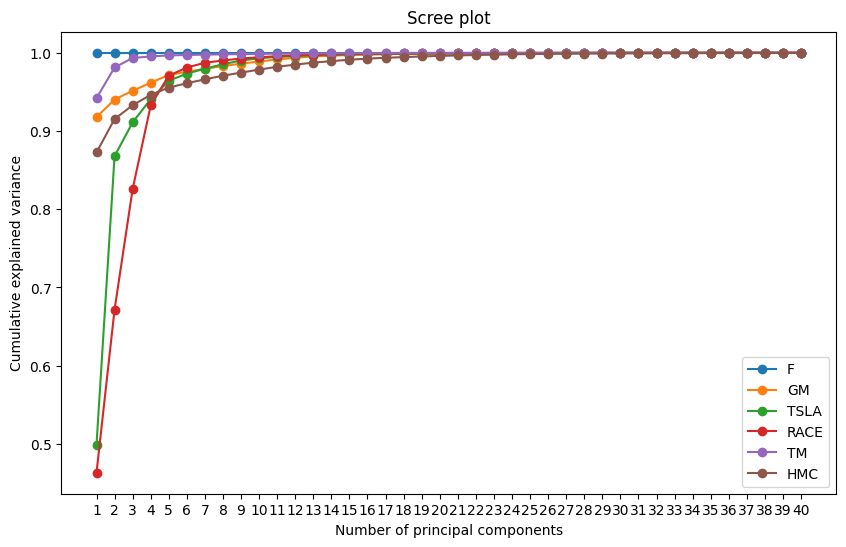

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

# Define el mapa de colores
color_map = plt.get_cmap('tab10')

# Itera a través de cada marca
for i, brand in enumerate(brands):
    # Extrae el DataFrame correspondiente a la marca actual
    dfs = stationary_dataframes[brand].copy()

    # Separa las características y la variable objetivo
    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)

    # Define el modelo PCA
    pca = PCA()

    # Escala las características
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Ajusta el modelo PCA
    pca.fit(df_features_scaled)

    # Calcula la varianza acumulada
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Dibuja la línea de la varianza acumulada para la marca actual
    plt.plot(range(1, len(cumulative_variance[:40]) + 1), cumulative_variance[:40], '-o', label=brand, color=color_map(i))

    # Imprime las 5 variables más importantes para cada una de las 5 primeras componentes
    print(f'Brand: {brand}')
    for j in range(5):
        # Recupera los coeficientes de la componente principal
        component = pca.components_[j]

        # Asocia cada coeficiente con el nombre de la característica correspondiente
        feature_weights = dict(zip(df_features.columns, component))

        # Ordena las características por el valor absoluto de su peso y toma las 5 primeras
        top_features = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

        print(f'Component {j+1}: {cumulative_variance[j]}')
        for feature, weight in top_features:
            print(f'  {feature}: {weight}')

    print('\n')

# Añade etiquetas y título
plt.title('Scree plot')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.xticks(range(1, 41))
plt.show()


Brand: F
Component 1: 0.31073304160504545
  Net Income Growth_lag2: -0.9573240664062573
  Net Income Growth_lag1: 0.2853033193300718
  Net Income Growth: 0.04576910395523177
  Net Income Growth_lag3: 0.006151030547284368
  Other Current Liabilities_lag5: -3.574656904407928e-05
Component 2: 0.6086744066247467
  Net Income Growth_lag1: -0.9538057409734565
  Net Income Growth_lag2: -0.27886651122293904
  Net Income Growth: 0.1111538241064724
  Net Income Growth_lag3: 0.011528289472726678
  Other Current Liabilities_lag4: -3.583729591738978e-05
Component 3: 0.8709291667094191
  Net Income Growth: -0.9926824737328613
  Net Income Growth_lag1: -0.09352538056988884
  Net Income Growth_lag2: -0.07524782528374946
  Net Income Growth_lag3: 0.013125192395647417
  Other Current Liabilities_lag3: 3.313073476989692e-05
Component 4: 0.9999999312796983
  Net Income Growth_lag3: -0.9998284810119565
  Net Income Growth: -0.011468173897741398
  Net Income Growth_lag1: -0.010470174703680795
  Net Income G

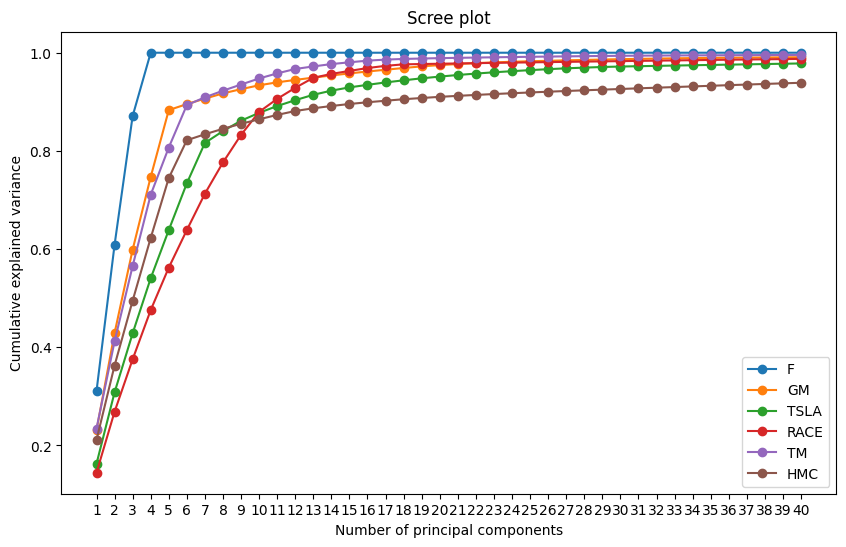

In [109]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

# Define el mapa de colores
color_map = plt.get_cmap('tab10')

# Itera a través de cada marca
for i, brand in enumerate(brands):
    # Extrae el DataFrame correspondiente a la marca actual
    dfs = lagged_stationary_dataframes[brand].copy()

    # Separa las características y la variable objetivo
    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)

    # Define el modelo PCA
    pca = PCA()

    # Escala las características
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Ajusta el modelo PCA
    pca.fit(df_features_scaled)

    # Calcula la varianza acumulada
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Dibuja la línea de la varianza acumulada para la marca actual
    plt.plot(range(1, len(cumulative_variance[:40]) + 1), cumulative_variance[:40], '-o', label=brand, color=color_map(i))

    # Imprime las 5 variables más importantes para cada una de las 5 primeras componentes
    print(f'Brand: {brand}')
    for j in range(5):
        # Recupera los coeficientes de la componente principal
        component = pca.components_[j]

        # Asocia cada coeficiente con el nombre de la característica correspondiente
        feature_weights = dict(zip(df_features.columns, component))

        # Ordena las características por el valor absoluto de su peso y toma las 5 primeras
        top_features = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

        print(f'Component {j+1}: {cumulative_variance[j]}')
        for feature, weight in top_features:
            print(f'  {feature}: {weight}')

    print('\n')

# Añade etiquetas y título
plt.title('Scree plot')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.xticks(range(1, 41))

plt.show()



# FUNCIONES AUXILIARES

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def errors(y_test, y_pred):

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100

    RMSE = math.sqrt(mean_squared_error(y_test,y_pred))
        # Mean Absolute Error (MAE)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 4)}')

    # Mean Absolute Percentage Error (MAPE)
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 4)} %')

    # Median Absolute Percentage Error (MDAPE)
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 4)} %')

    # Mean Quatratic Error(RMSE)
    print(f'Mean Quatratic Error (RMSE): {np.round(RMSE, 4)}')

    return MAE, MAPE, MDAPE, RMSE


In [ ]:
for brand in brands:
  print('-----------------------------------------', brand, '-------------------------------------')
  dfs = stationary_dataframes[brand].copy()
  train_data_len = math.ceil(dfs.shape[0] * 0.8)
  train_date_limit = dfs.index[train_data_len]
  dfs.loc[train_data_len:, 'Target'] = dfs.loc[train_date_limit:, 'Target'] * dfs.loc[train_date_limit:, 'Nominal_Close'] + dfs.loc[train_date_limit:, 'Nominal_Close']
  _, _, _, _ = errors(dfs['Target'][train_date_limit:], dfs['Nominal_Close'][train_date_limit:])

----------------------------------------- F -------------------------------------
Mean Absolute Error (MAE): 0.5705
Mean Absolute Percentage Error (MAPE): 4.9611 %
Median Absolute Percentage Error (MDAPE): 3.5857 %
Mean Quatratic Error (RMSE): 0.85
----------------------------------------- GM -------------------------------------
Mean Absolute Error (MAE): 2.2125
Mean Absolute Percentage Error (MAPE): 4.9345 %
Median Absolute Percentage Error (MDAPE): 4.0888 %
Mean Quatratic Error (RMSE): 2.8248
----------------------------------------- TSLA -------------------------------------
Mean Absolute Error (MAE): 18.583
Mean Absolute Percentage Error (MAPE): 7.6412 %
Median Absolute Percentage Error (MDAPE): 6.2745 %
Mean Quatratic Error (RMSE): 24.3238
----------------------------------------- RACE -------------------------------------
Mean Absolute Error (MAE): 7.8271
Mean Absolute Percentage Error (MAPE): 3.5909 %
Median Absolute Percentage Error (MDAPE): 2.8933 %
Mean Quatratic Error (RMSE

<ipython-input-18-aec2ec831d5c>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dfs.loc[train_data_len:, 'Target'] = dfs.loc[train_date_limit:, 'Target'] * dfs.loc[train_date_limit:, 'Nominal_Close'] + dfs.loc[train_date_limit:, 'Nominal_Close']
<ipython-input-18-aec2ec831d5c>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dfs.loc[train_data_len:, 'Target'] = dfs.loc[train_date_limit:, 'Target'] * dfs.loc[train_date_limit:, 'Nominal_Close'] + dfs.loc[train_date_limit:, 'Nominal_Close']
<ipython-input-18-aec2ec831d5c>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dfs.loc[train_data_len:, 'Target'] = dfs.loc

In [9]:
def transform_targets(df, train_perc, close_col='Nominal_Close'):
    # Obteniendo las fechas correspondientes a las posiciones de train_data_len - 1 y train_data_len
    train_data_len = math.ceil(df.shape[0] * train_perc)
    train_date_limit = df.index[train_data_len]
    for col in df.columns:
        if col == 'residuals':
            df.loc[train_date_limit:, col] = df.loc[train_date_limit:, col] * df.loc[train_date_limit:, close_col]
        elif col == 'y_train':
           df.loc[:train_date_limit, col] = df.loc[:train_date_limit, col] * df.loc[:train_date_limit, close_col] + df.loc[:train_date_limit, close_col]
        elif col != close_col:
            df.loc[train_date_limit:, col] = df.loc[train_date_limit:, col] * df.loc[train_date_limit:, close_col] + df.loc[train_date_limit:, close_col]
    return df


In [10]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [11]:
def partition_dataset(sequence_length, data, target):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i]) # contains sequence_length values 0-sequence_length from feature columns
        y.append(target[i]) # contains the prediction values for validation, for single-step prediction

    x = np.array(x)
    y = np.array(y)
    return x, y


In [12]:
from sklearn.model_selection import GridSearchCV

def feature_scaling_and_selection(df, stockname=None, stationary=False, lagged = False, use_Lasso=False, use_PCA=False):
    # Separate the target variable from the features
    dfs = df.copy()
    if stationary:
        df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
        df_target = dfs['Target']
        df_Nominal_Close = dfs['Nominal_Close']
    else:
        df_features = dfs.drop('Target', axis=1)
        df_target = dfs['Target']


    # Scaling the features
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = RobustScaler()
    df_target_scaled = pd.Series(scaler_pred.fit_transform(df_target.values.reshape(-1, 1)).flatten())



        # Apply Lasso transformation if Lasso is set to True
    if use_Lasso:
        # Selecciona las características importantes
        if lagged:
          df_features_scaled = df_features_scaled[lassofeatures_lags[stockname]]
        else:
          df_features_scaled = df_features_scaled[lassofeatures_nolags[stockname]]

    # Apply PCA transformation if PCA is set to True
    if use_PCA:
        pca = PCA(n_components=0.93)
        np_data_scaled = pca.fit_transform(df_features_scaled)
        scaler = RobustScaler()
        np_data_scaled = scaler.fit_transform(np_data_scaled)
    else:
        # Converting the dataframe to arrays
        nrows = df_features.shape[0]
        np_data_scaled = np.reshape(np.array(df_features_scaled), (nrows, -1))
    np_target_scaled = df_target_scaled.values.reshape(-1,1)


    return np_data_scaled, np_target_scaled, scaler_pred


In [ ]:
def train_test_transform(df, train_perc = 0.8):
  dfs = df.copy()

  df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
  df_target = dfs['Target']


  train_data_len = math.ceil(dfs.shape[0] * train_perc)
  X_train, X_test, y_train, y_test = df_features[:train_data_len], df_features[train_data_len:], df_target[:train_data_len], df_target[train_data_len:]


  scaler_X = RobustScaler()
  # Ajusta el escalador a los datos de entrenamiento y transforma los conjuntos de datos
  X_train_scaled = scaler_X.fit_transform(X_train)
  X_test_scaled = scaler_X.transform(X_test)
  return X_train_scaled, X_test_scaled, y_train, y_test




In [13]:
def train_test_split(np_data, np_target_scaled, train_perc, for_LSTM = False, sequence_length = 0):

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data
    train_data_len = math.ceil(np_data.shape[0] * train_perc)

    # Create the training and test data
    train_data = np_data[:train_data_len]
    train_target = np_target_scaled[:train_data_len]

    if for_LSTM == True:
        test_data = np_data[train_data_len - sequence_length:, :]
        test_target = np_target_scaled[train_data_len - sequence_length:, :]

        # Generate training data and test data
        X_train, y_train = partition_dataset(sequence_length, train_data, train_target)
        X_test, y_test = partition_dataset(sequence_length, test_data, test_target)
        # Validate that the prediction value and the input match up
        # The last close price of the second input sample should equal the first prediction value
        print(X_train[1][sequence_length-1][0])
        print(y_train[0])

    else :
        X_train, X_test, y_train, y_test = train_data, np_data[train_data_len:], train_target, np_target_scaled[train_data_len:]


    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)


    return X_train, X_test, y_train, y_test

In [20]:
def results_df(df, stockname, train_perc, stationary, y_pred):

    train_data_len = math.ceil(df.shape[0] * train_perc)
    train = pd.DataFrame(df['Target'][:train_data_len]).rename(columns={'Target': 'y_train'})
    valid = pd.DataFrame(df['Target'][train_data_len:]).rename(columns={'Target': 'y_test'})
    valid.insert(1, "y_pred", y_pred, True)
    valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
    df_union = pd.concat([train, valid])
    if stationary:
            df_union['Nominal_Close'] = df['Nominal_Close']
            df_union = transform_targets(df_union, train_perc)
    return df_union

In [14]:
def model_LSTM(x_train, neurons=50, optimizer='adam', loss='mean_squared_error', learn_rate="standard", dropout_rate=0.1, dense_rate=32, activation='relu'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(dense_rate))
    model.add(Dense(1, activation))
    model.compile(optimizer=optimizer, loss=loss)
    return model


In [15]:

def final_LSTM(df, stockname, display_start_date = "2019-01-01" , stationary = False, train_perc = 0.8, sequence_length=50,
                neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error',
               learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1, lagged = False):

    np_data, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, stockname, stationary, lagged, use_Lasso, use_PCA)
    x_train, x_test, y_train, y_test = train_test_split(np_data, np_target_scaled, train_perc,  for_LSTM = True, sequence_length = sequence_length)

    # Configure the neural network model
    model = model_LSTM(x_train, neurons, optimizer, loss, learn_rate, dropout_rate, dense_rate, activation)



    early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
    history = model.fit(x_train, y_train,  batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop], shuffle = True)

    # history = model.fit(x_train, y_train, validation_split=0.33,  batch_size=batch_size, epochs=epochs)


    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
    MAE, MAPE, MDAPE, RMSE = errors(y_pred, y_test_unscaled)

    df_union = results_df(df, stockname, train_perc, stationary, y_pred)


    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())


    # Zoom in to a closer timeframe
    df_union_zoom = df_union[df_union.index > display_start_date]

    # Create the lineplot
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    # Create the barplot for the absolute errors
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()
    plt.show()

    return df_union


In [ ]:
for brand in brands:
  r1 = final_LSTM(stationary_dataframes[brand], brand, display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


0.9822145778611905
[-0.58929341]
(5008, 50, 96) (5008, 1)
(1264, 50, 96) (1264, 1)
Epoch 1/50
157/157 [==============================] - 21s 96ms/step - loss: 0.9190 - val_loss: 1.1256
Epoch 2/50
157/157 [==============================] - 14s 92ms/step - loss: 0.9095 - val_loss: 1.1246
Epoch 3/50
157/157 [==============================] - 15s 98ms/step - loss: 0.8985 - val_loss: 1.1200
Epoch 4/50
157/157 [==============================] - 14s 92ms/step - loss: 0.8878 - val_loss: 1.1244
Epoch 5/50
157/157 [==============================] - 14s 89ms/step - loss: 0.8787 - val_loss: 1.1212
Epoch 6/50
157/157 [==============================] - 14s 92ms/step - loss: 0.8726 - val_loss: 1.1118
Epoch 7/50
157/157 [==============================] - 15s 93ms/step - loss: 0.8649 - val_loss: 1.1020
Epoch 8/50
157/157 [==============================] - 13s 83ms/step - loss: 0.8550 - val_loss: 1.1204
Epoch 9/50
157/157 [==============================] - 15s 93ms/step - loss: 0.8561 - val_loss: 1.1107

KeyboardInterrupt: ignored

In [ ]:
r1 = final_LSTM(stationary_dataframes['GM'], 'GM', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=100,
               neurons = 50, epochs=100, batch_size=45, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.3)


-0.1806755069856988
[-1.41002212]
(2330, 50, 2) (2330, 1)
(595, 50, 2) (595, 1)
Epoch 1/3
73/73 [==============================] - 16s 111ms/step - loss: 0.6137 - val_loss: 1.0026
Epoch 2/3
73/73 [==============================] - 7s 97ms/step - loss: 0.6048 - val_loss: 1.0419
Epoch 3/3
73/73 [==============================] - 6s 86ms/step - loss: 0.5918 - val_loss: 1.0494


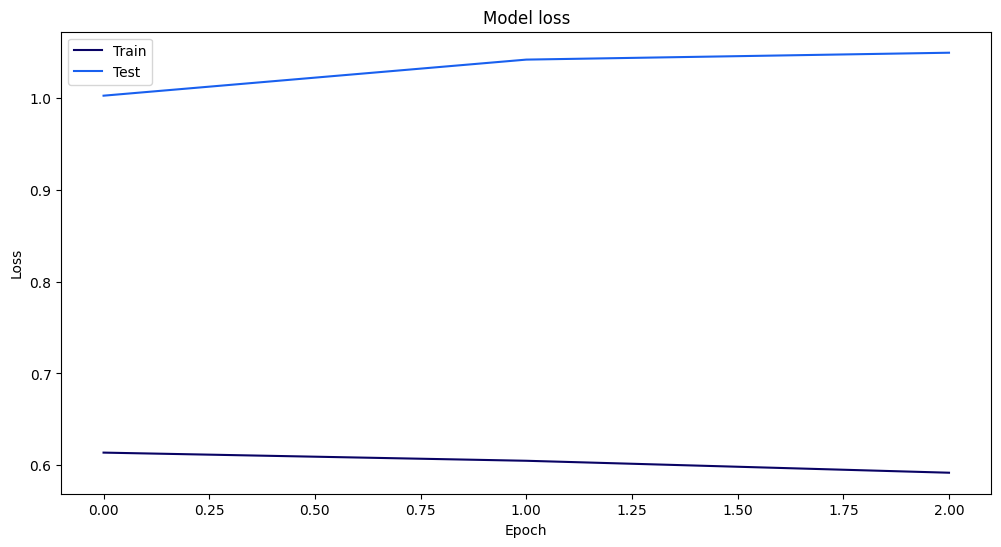

19/19 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.0496
Mean Absolute Percentage Error (MAPE): 12721.2877 %
Median Absolute Percentage Error (MDAPE): 9159.1296 %
Mean Quatratic Error (RMSE): 0.0628
Mean Absolute Error (MAE): 2.2848
Mean Absolute Percentage Error (MAPE): 5.0708 %
Median Absolute Percentage Error (MDAPE): 4.3091 %
Mean Quatratic Error (RMSE): 2.9386


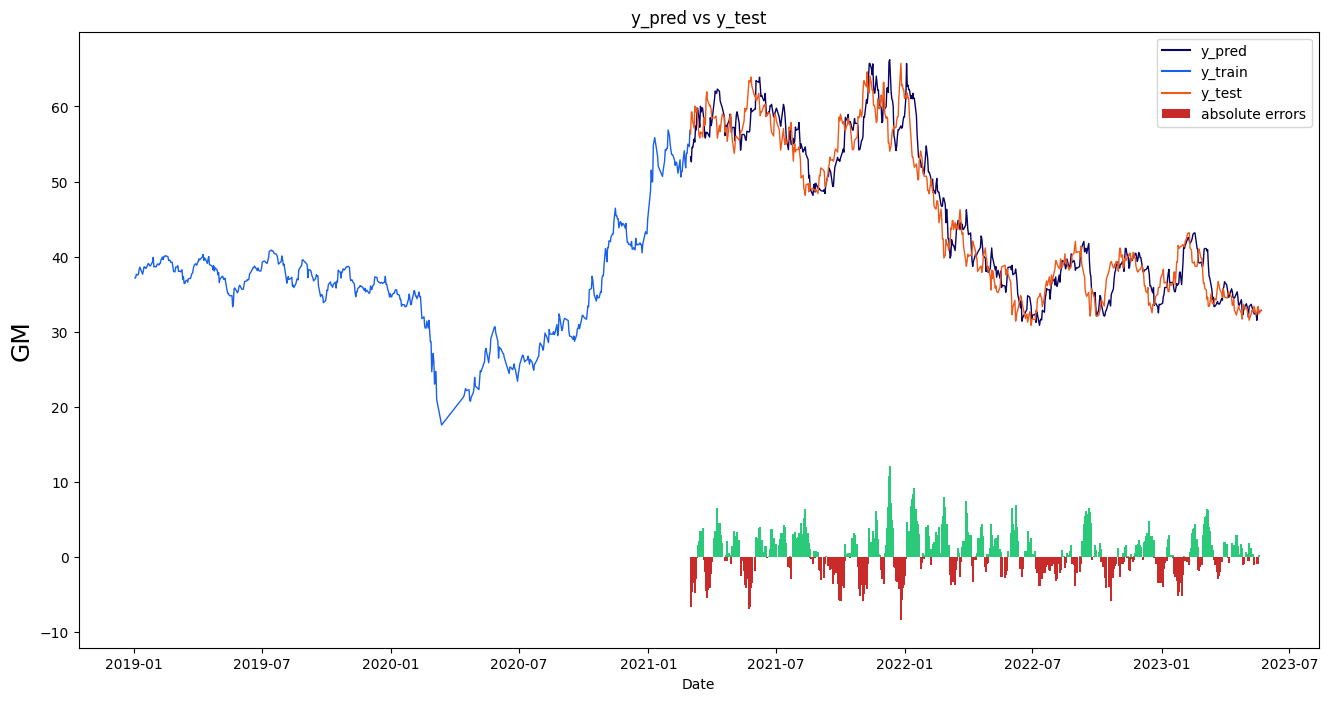

In [ ]:
r1 = final_LSTM(stationary_dataframes['GM'][['Close', 'Nominal_Close', 'LBOLLINGER', 'Target']], 'GM', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=3, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.3)


In [ ]:
r1 = final_LSTM(stationary_dataframes['F'], 'F', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=3,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


ValueError: ignored

In [ ]:
r1 = final_LSTM(stationary_dataframes['F'], 'F', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


OTHER ML MODELS

In [16]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,TimeSeriesSplit



In [17]:

def plot_predictions(df_union, stockname, display_start_date="2023-01-01"):
    df_union_zoom = df_union[df_union.index > display_start_date]
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [ ]:
import xgboost as xgb
grid_xgb = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': np.arange(2, 7, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'objective': ['reg:linear']
}
for brand in brands:
  print('----------------------------------------------', brand, '-------------------------------------------------------------')
  np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, lagged = True)
  X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, 0.8)
  rscv = RandomizedSearchCV(estimator=xgb.XGBRegressor(), param_distributions=grid_xgb, cv=2, n_jobs=-1, verbose=2, n_iter=25)
  rscv_fit = rscv.fit(X_train, y_train)
  best_parameters = rscv_fit.best_params_
  print(best_parameters)

---------------------------------------------- F -------------------------------------------------------------
(4114, 393) (4114, 1)
(1028, 393) (1028, 1)
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[14:13:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
{'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'booster': 'dart'}
---------------------------------------------- GM -------------------------------------------------------------
(1500, 102) (1500, 1)
(374, 102) (374, 1)
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[14:19:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
{'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.05, 'booster': 'gbtree'}
---------------------------------------------- TSLA -------------------------------------------------------------
(1

In [ ]:
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],
'max_depth': np.arange(1, 15, 1),
'min_samples_split': [2, 10, 9],
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
'bootstrap': [True, False],
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

NameError: ignored

In [ ]:
np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(stationary_dataframes['F'], 'F', stationary = True, use_Lasso = False, use_PCA= False, lagged= False)
np_data_scaled.size

606912

In [21]:
import xgboost as xgb
def xgboost_model(df, brand, booster = 'gbtree',base_score=0.5, objective='reg:linear',  early_stopping_rounds=50, n_estimators = 1000, max_depth = 3, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True ):
  np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

  X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

  reg = xgb.XGBRegressor(base_score = base_score, booster = booster,
                        n_estimators = n_estimators,
                        early_stopping_rounds = early_stopping_rounds,
                        objective = objective,
                        max_depth = max_depth,
                        learning_rate = learning_rate)
  reg.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],eval_metric='rmse',
          verbose=False)
    # Obtiene las métricas de evaluación
  results = reg.evals_result()

  # Obtiene la pérdida de entrenamiento
  train_loss = results['validation_0']['rmse']

  # Obtiene la pérdida de validación
  val_loss = results['validation_0']['rmse']

  # Crea una lista de épocas
  epochs = range(1, len(train_loss) + 1)

  # Crea el gráfico
  plt.plot(epochs, train_loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  y_pred = reg.predict(X_test)
  # Convert the arrays back to the original scale
  y_test = scaler_pred.inverse_transform(y_test)
  y_pred= scaler_pred.inverse_transform(y_pred.reshape(-1,1))

  print('Con pct_change')
  MAE, MAPE, MDAPE, RMSE = errors(y_test, y_pred)
  df_union = results_df(df, brand, train_perc, stationary, y_pred)
  print('Sin pct_change')


  MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())
  y2 = y_test[:100]
  y_pred2 = y_pred[:100]

  x = range(len(y2))
  fig, ax = plt.subplots(figsize=(10, 5))
  ci = 1.96*RMSE
  for i,v in enumerate(y_pred2):
      plt.plot([x[i],x[i]], [v,y2[i]],color="green")
  #ax.fill_between(x, ( y_pred2-ci), ( y_pred2+ci), color='b', alpha=.1)
  ax.scatter(x,y_pred2,color="red",s=8,label="predicho")
  ax.scatter(x,y2,color="blue",s=8,label="real")
  plt.legend()
  plt.show()


  df_union_zoom = df_union[df_union.index > display_start_date]
  # Plot the actual values
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("y_pred vs y_test")
  plt.ylabel(brand, fontsize=18)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

  plt.xlabel('Time')
  plt.ylabel(brand)
  plt.legend()
  df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
  plt.legend()

  plt.show()

(5058, 1) (5058, 1)
(1264, 1) (1264, 1)
[14:07:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


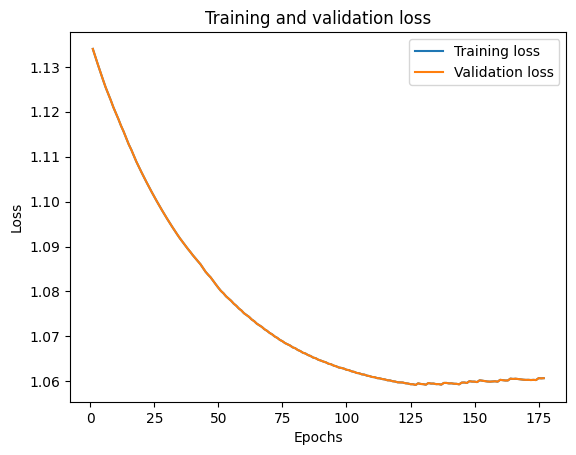

Con pct_change
Mean Absolute Error (MAE): 0.0501
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.8748 %
Mean Quatratic Error (RMSE): 0.0681
Sin pct_change
Mean Absolute Error (MAE): 0.5762
Mean Absolute Percentage Error (MAPE): 5.0451 %
Median Absolute Percentage Error (MDAPE): 3.6993 %
Mean Quatratic Error (RMSE): 0.8527


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


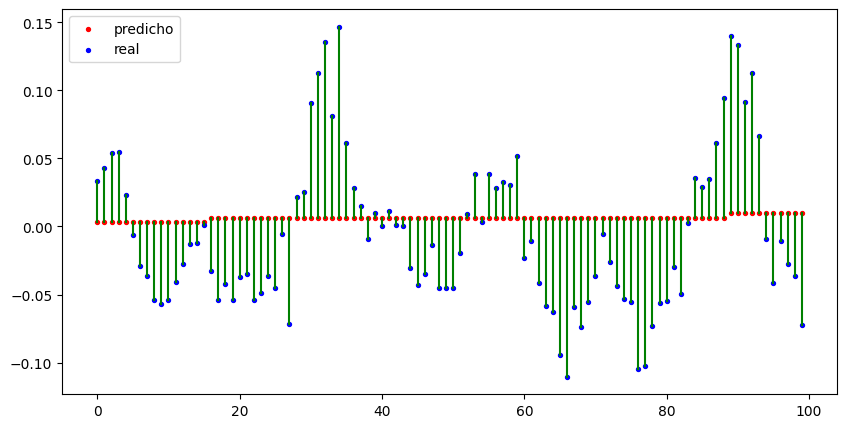

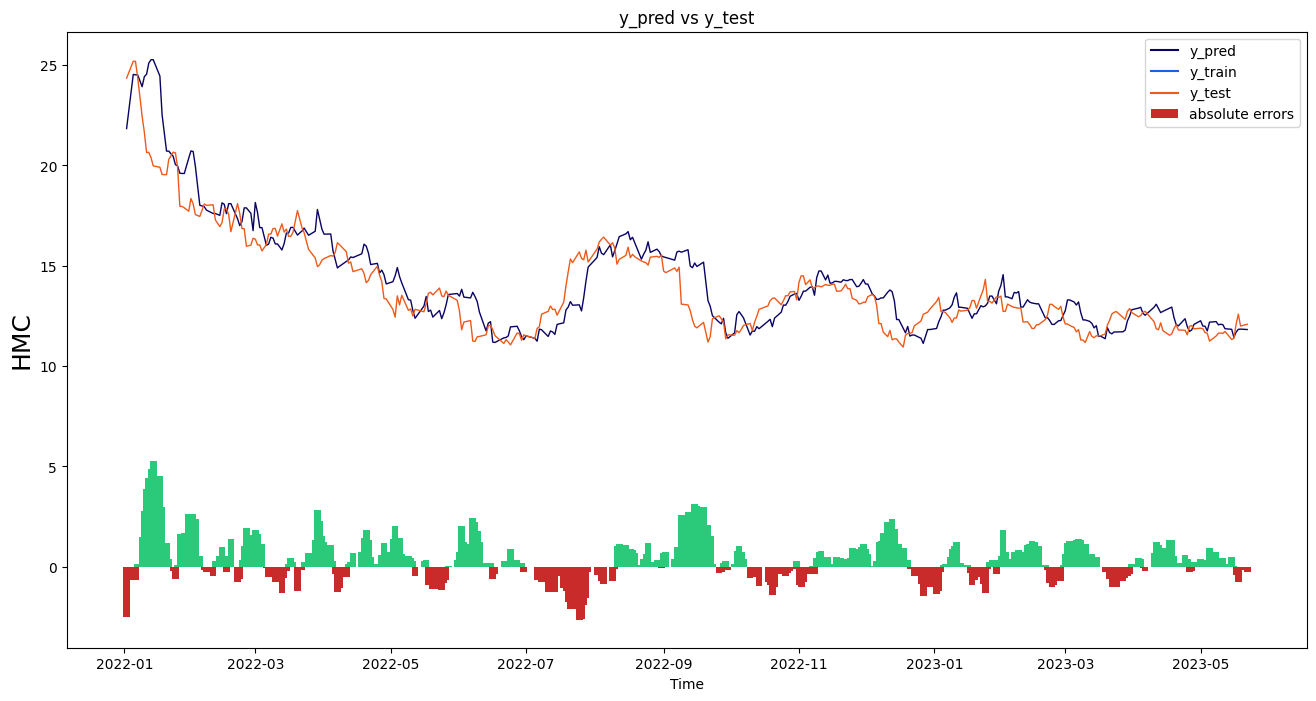

In [22]:
xgboost_model(stationary_dataframes['F'], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
[14:07:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


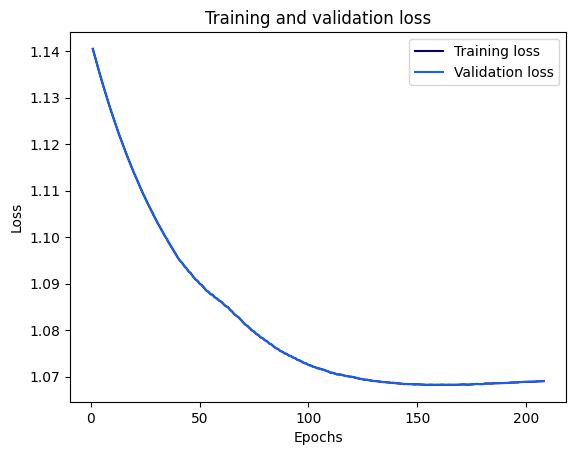

Con pct_change
Mean Absolute Error (MAE): 0.05
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 99.2675 %
Mean Quatratic Error (RMSE): 0.0689
Sin pct_change
Mean Absolute Error (MAE): 0.5811
Mean Absolute Percentage Error (MAPE): 5.0137 %
Median Absolute Percentage Error (MDAPE): 3.4509 %
Mean Quatratic Error (RMSE): 0.8687


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


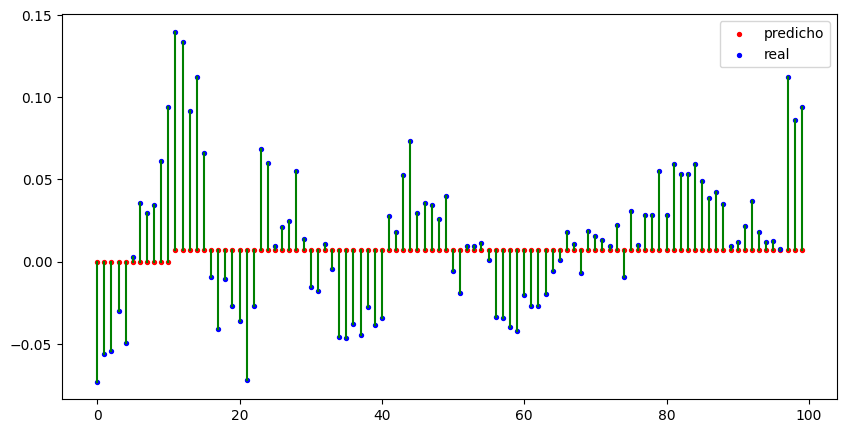

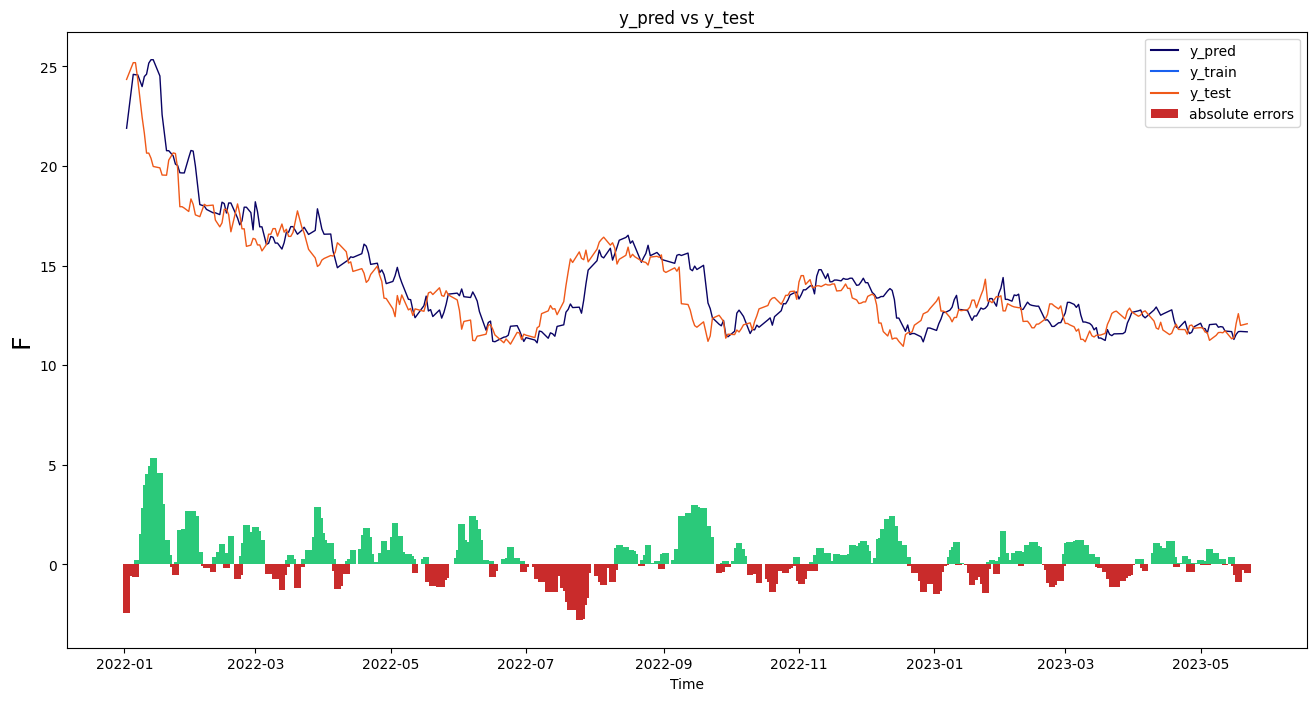

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 10) (2067, 1)
(516, 10) (516, 1)
[14:07:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


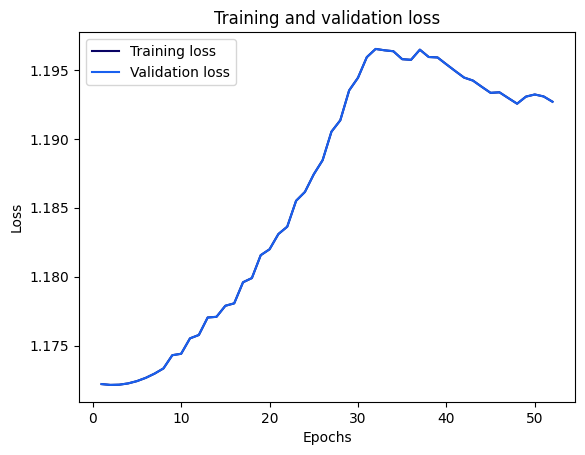

Con pct_change
Mean Absolute Error (MAE): 0.0573
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 137.4553 %
Mean Quatratic Error (RMSE): 0.0718
Sin pct_change
Mean Absolute Error (MAE): 2.5684
Mean Absolute Percentage Error (MAPE): 5.9995 %
Median Absolute Percentage Error (MDAPE): 4.6125 %
Mean Quatratic Error (RMSE): 3.3087


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


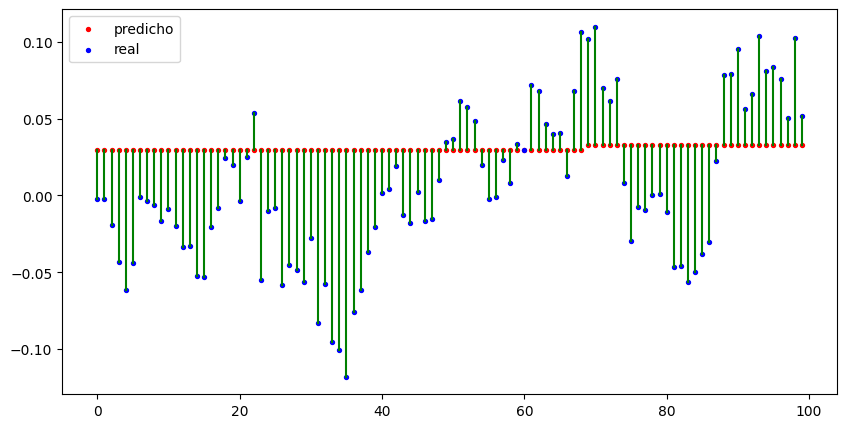

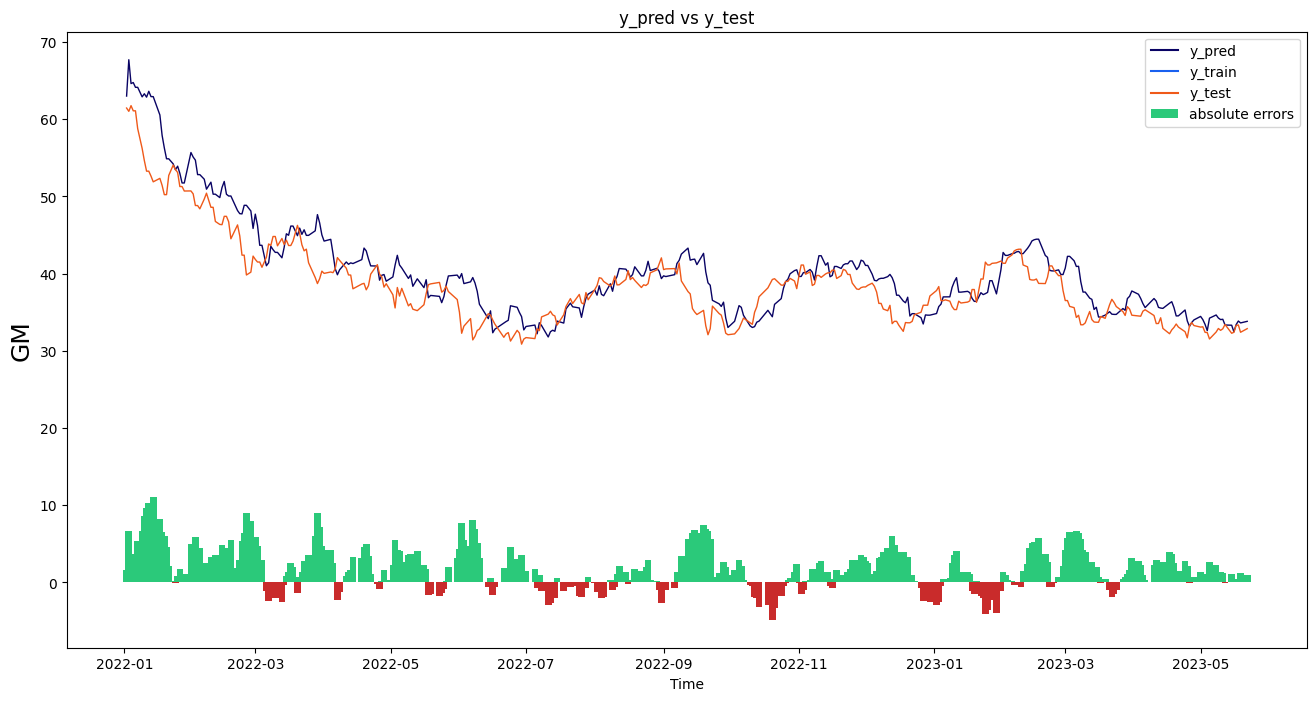

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 16) (2132, 1)
(533, 16) (533, 1)
[14:07:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


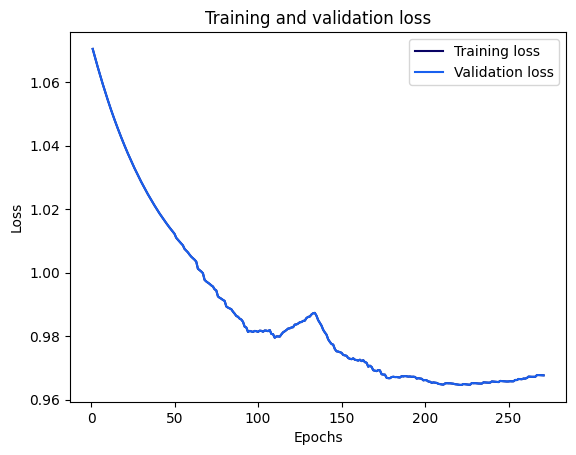

Con pct_change
Mean Absolute Error (MAE): 0.0802
Mean Absolute Percentage Error (MAPE): 193.6023 %
Median Absolute Percentage Error (MDAPE): 108.1856 %
Mean Quatratic Error (RMSE): 0.1035
Sin pct_change
Mean Absolute Error (MAE): 20.0032
Mean Absolute Percentage Error (MAPE): 8.167 %
Median Absolute Percentage Error (MDAPE): 6.3888 %
Mean Quatratic Error (RMSE): 26.4699


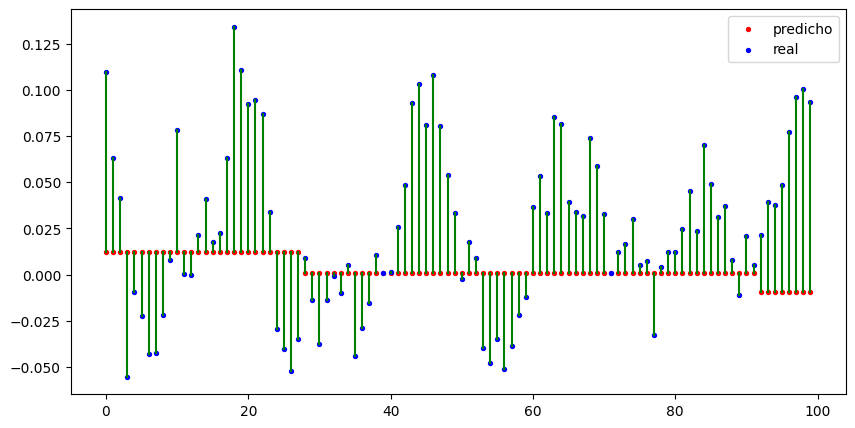

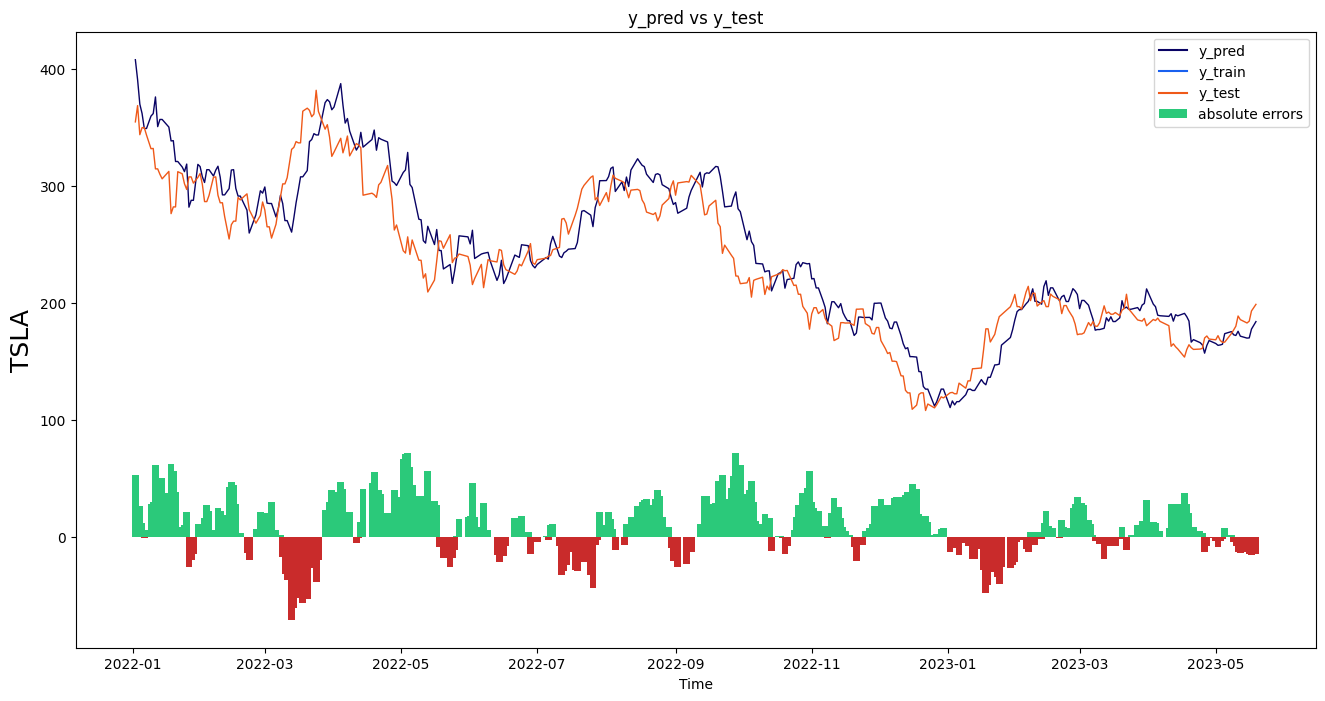

----------------------------------------------------- RACE ----------------------------------------------------------------------------------------
(978, 13) (978, 1)
(244, 13) (244, 1)
[14:07:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


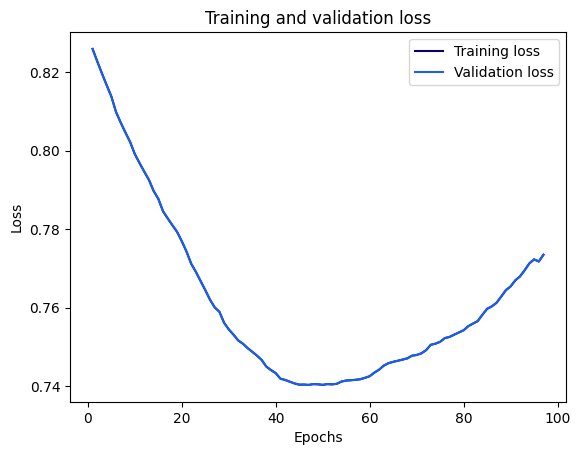

Con pct_change
Mean Absolute Error (MAE): 0.0294
Mean Absolute Percentage Error (MAPE): 312.8293 %
Median Absolute Percentage Error (MDAPE): 79.341 %
Mean Quatratic Error (RMSE): 0.0371
Sin pct_change
Mean Absolute Error (MAE): 6.6348
Mean Absolute Percentage Error (MAPE): 2.9126 %
Median Absolute Percentage Error (MDAPE): 2.4678 %
Mean Quatratic Error (RMSE): 8.2685


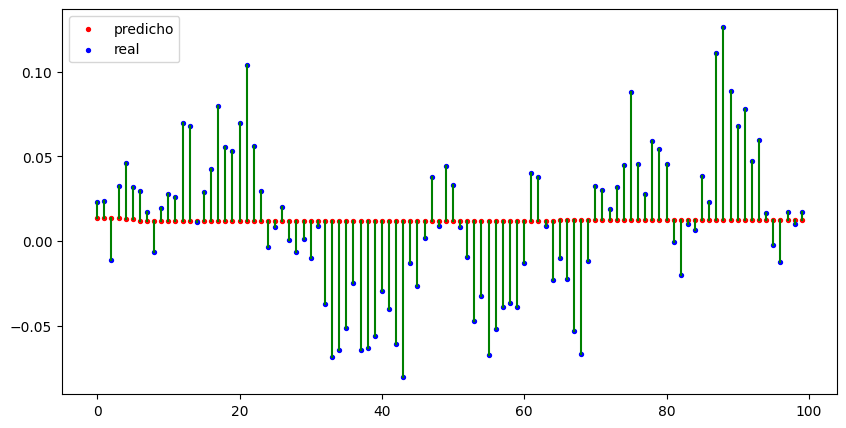

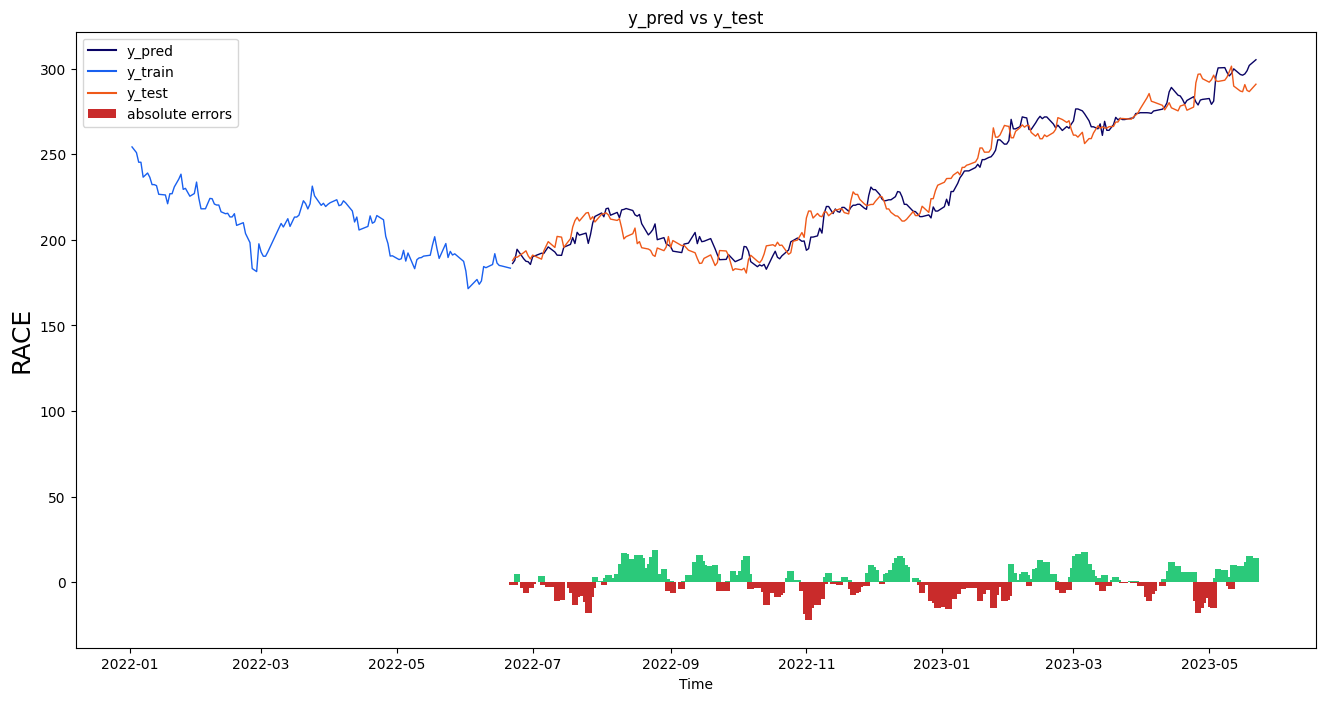

----------------------------------------------------- TM ----------------------------------------------------------------------------------------
(3840, 9) (3840, 1)
(960, 9) (960, 1)
[14:07:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


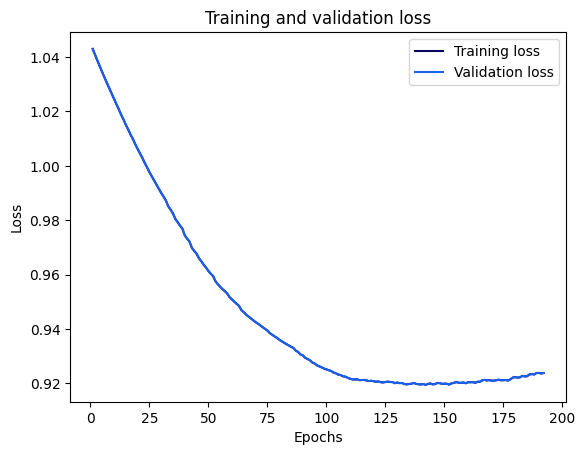

Con pct_change
Mean Absolute Error (MAE): 0.0282
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 108.1356 %
Mean Quatratic Error (RMSE): 0.0372
Sin pct_change
Mean Absolute Error (MAE): 4.3169
Mean Absolute Percentage Error (MAPE): 2.8274 %
Median Absolute Percentage Error (MDAPE): 2.156 %
Mean Quatratic Error (RMSE): 5.7836


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


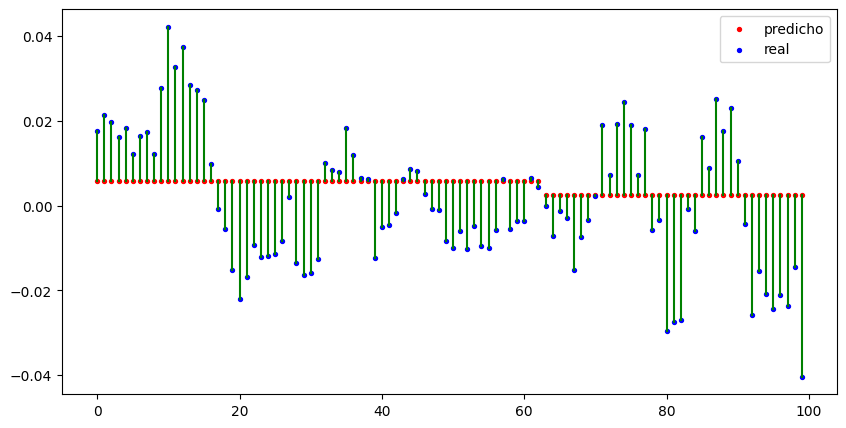

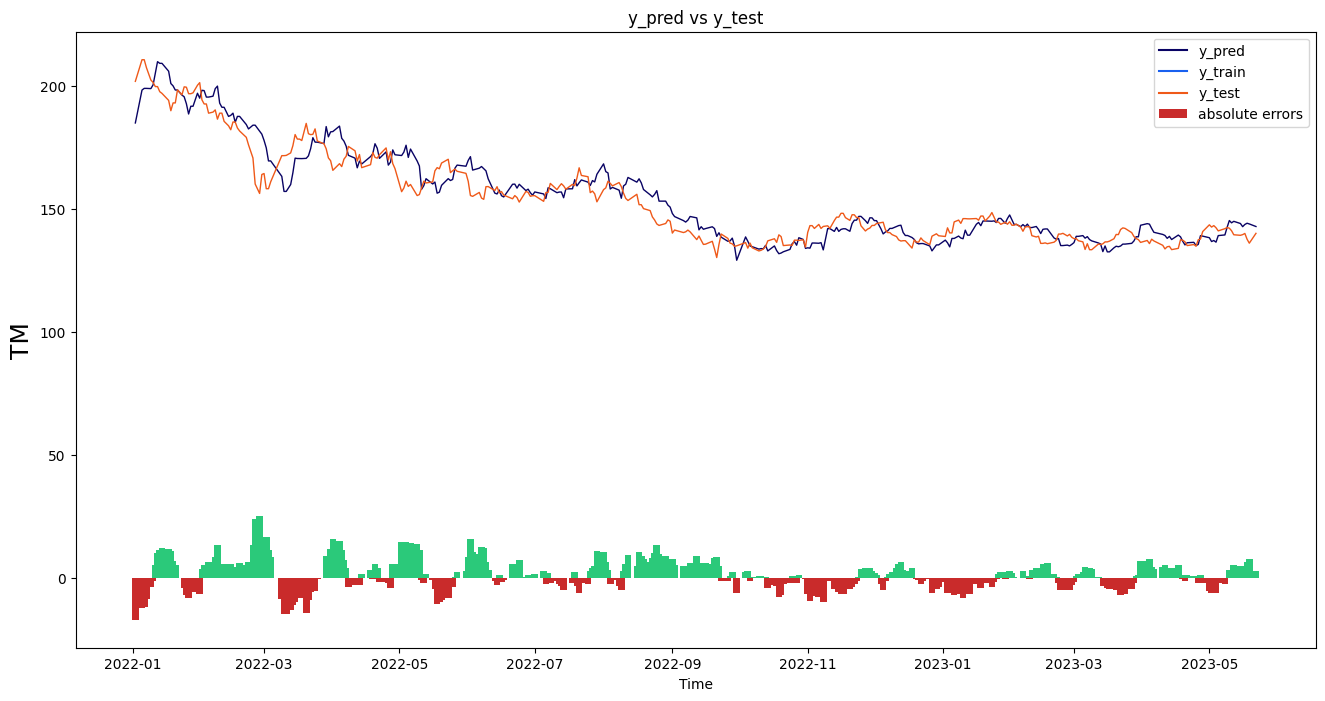

----------------------------------------------------- HMC ----------------------------------------------------------------------------------------
(4192, 33) (4192, 1)
(1047, 33) (1047, 1)
[14:07:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


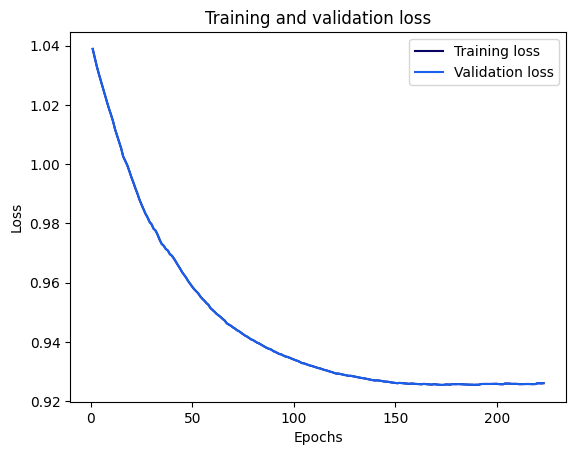

Con pct_change
Mean Absolute Error (MAE): 0.031
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 102.7799 %
Mean Quatratic Error (RMSE): 0.0418
Sin pct_change
Mean Absolute Error (MAE): 0.8278
Mean Absolute Percentage Error (MAPE): 3.1083 %
Median Absolute Percentage Error (MDAPE): 2.3746 %
Mean Quatratic Error (RMSE): 1.1015


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


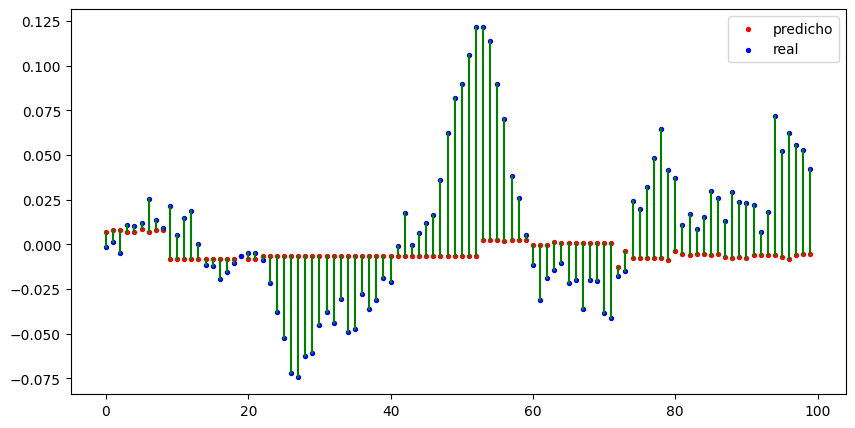

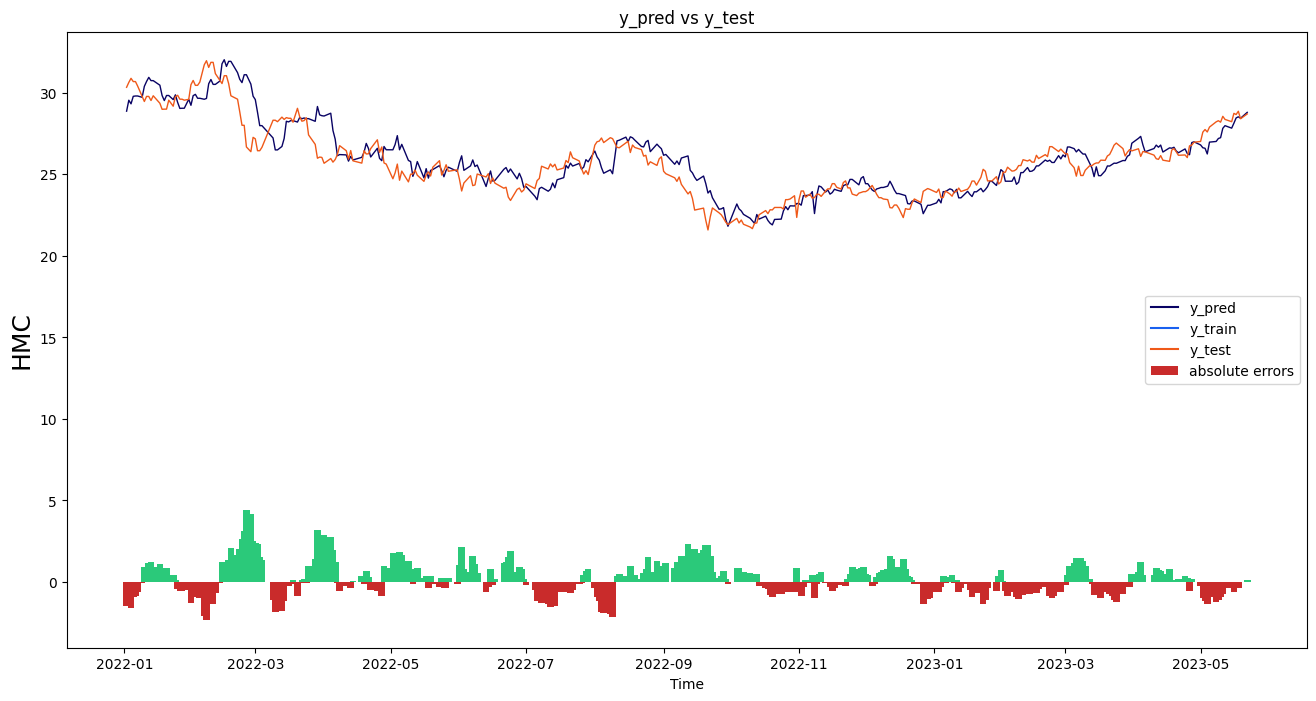

In [23]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
[14:08:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


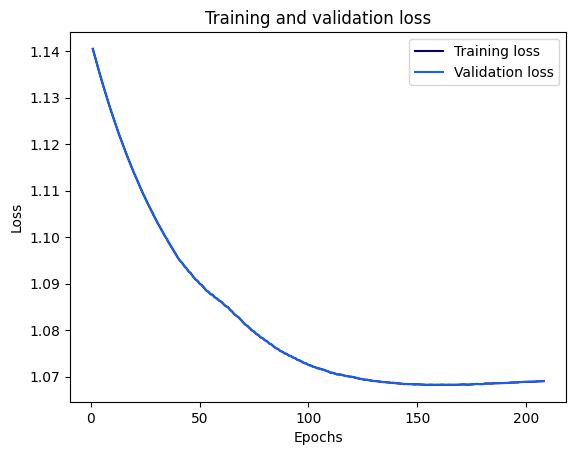

Con pct_change
Mean Absolute Error (MAE): 0.05
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 99.2675 %
Mean Quatratic Error (RMSE): 0.0689
Sin pct_change
Mean Absolute Error (MAE): 0.5811
Mean Absolute Percentage Error (MAPE): 5.0137 %
Median Absolute Percentage Error (MDAPE): 3.4509 %
Mean Quatratic Error (RMSE): 0.8687


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


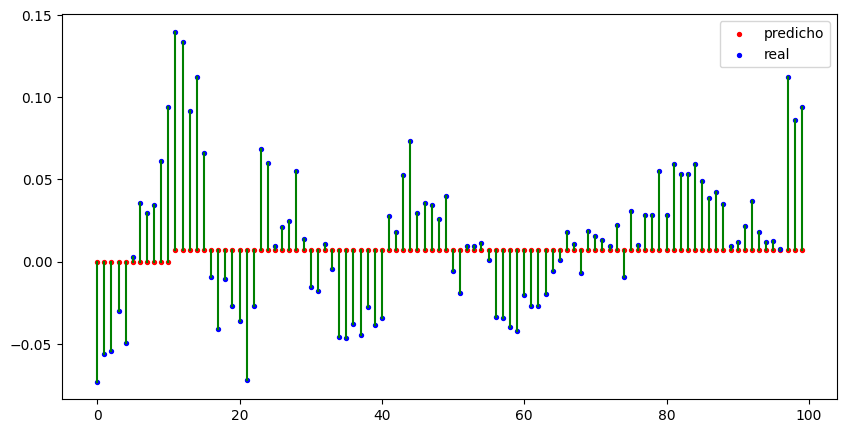

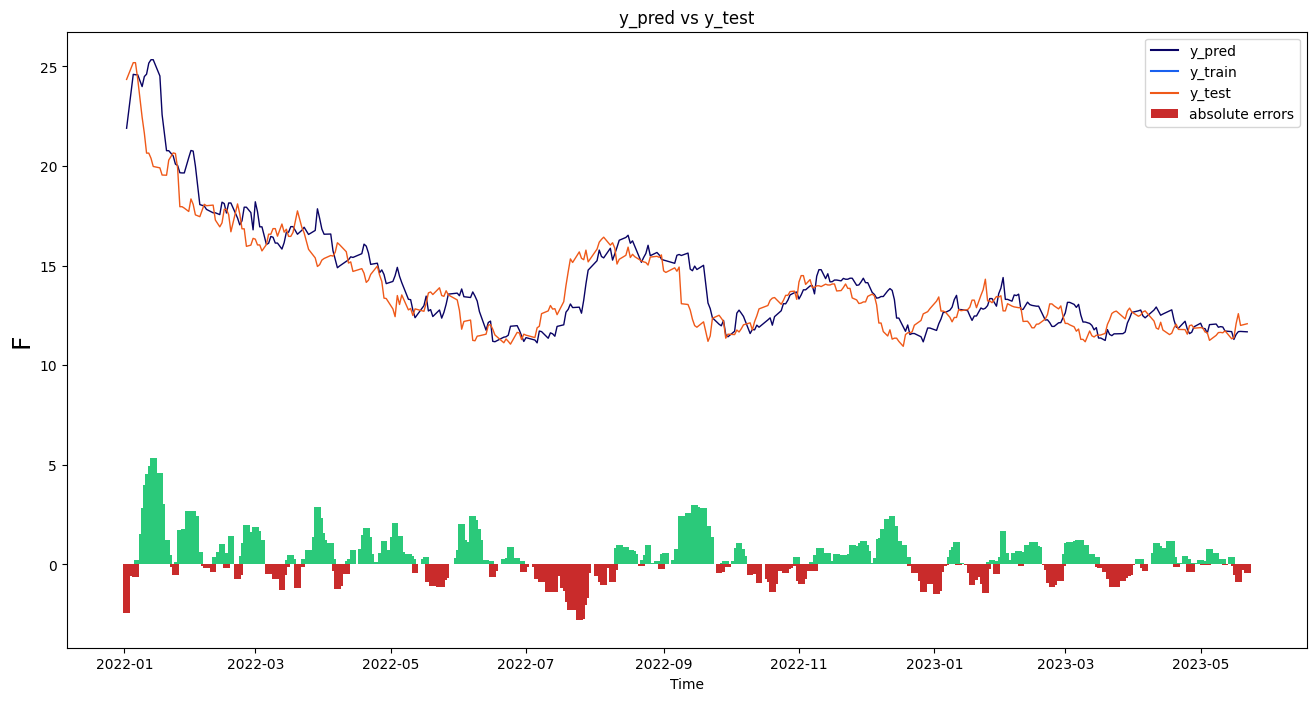

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 10) (2067, 1)
(516, 10) (516, 1)
[14:08:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


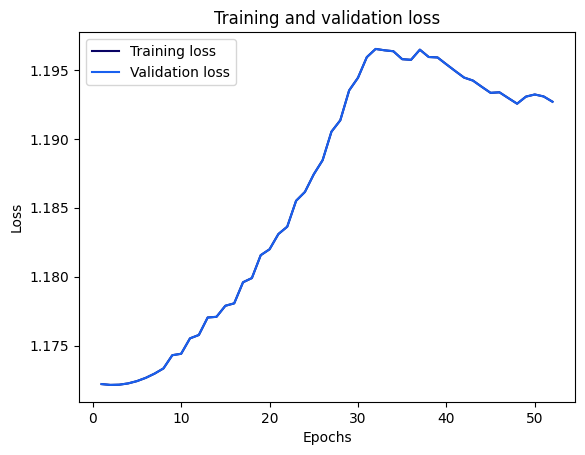

Con pct_change
Mean Absolute Error (MAE): 0.0573
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 137.4553 %
Mean Quatratic Error (RMSE): 0.0718
Sin pct_change
Mean Absolute Error (MAE): 2.5684
Mean Absolute Percentage Error (MAPE): 5.9995 %
Median Absolute Percentage Error (MDAPE): 4.6125 %
Mean Quatratic Error (RMSE): 3.3087


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


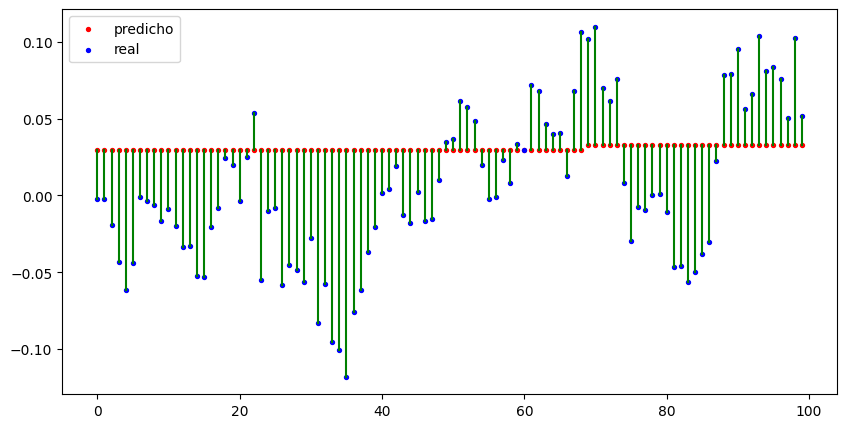

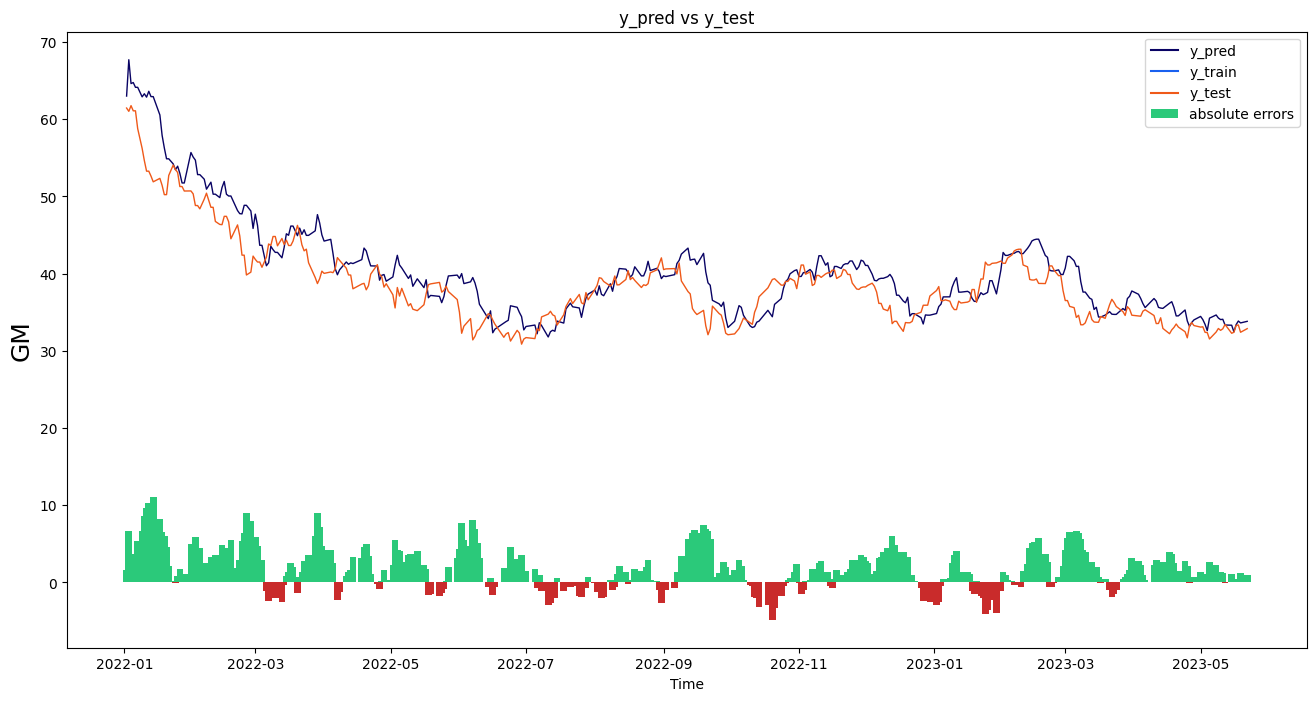

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 16) (2132, 1)
(533, 16) (533, 1)
[14:08:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


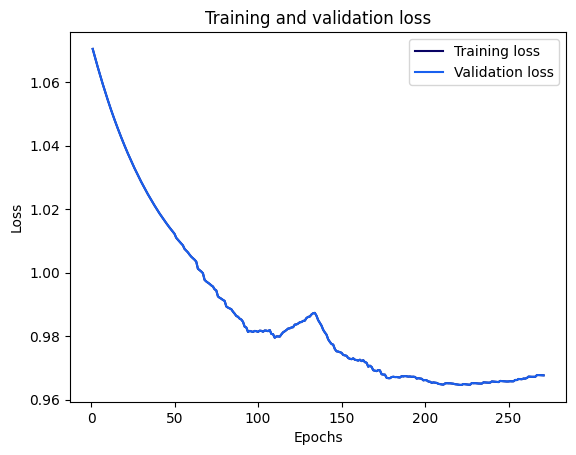

Con pct_change
Mean Absolute Error (MAE): 0.0802
Mean Absolute Percentage Error (MAPE): 193.6023 %
Median Absolute Percentage Error (MDAPE): 108.1856 %
Mean Quatratic Error (RMSE): 0.1035
Sin pct_change
Mean Absolute Error (MAE): 20.0032
Mean Absolute Percentage Error (MAPE): 8.167 %
Median Absolute Percentage Error (MDAPE): 6.3888 %
Mean Quatratic Error (RMSE): 26.4699


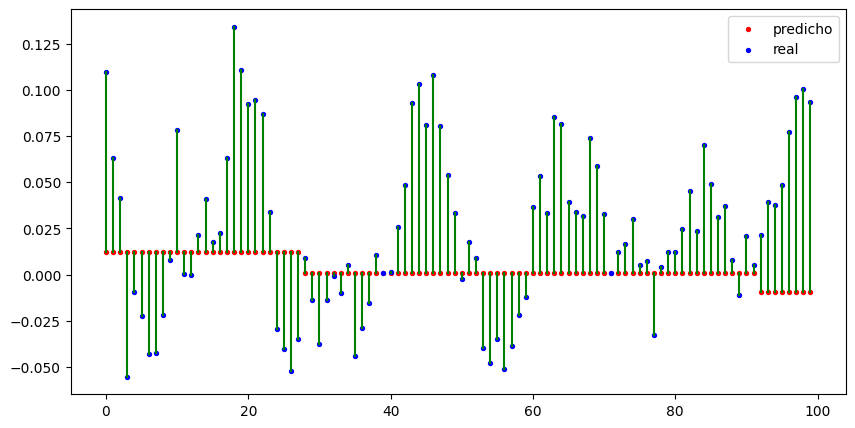

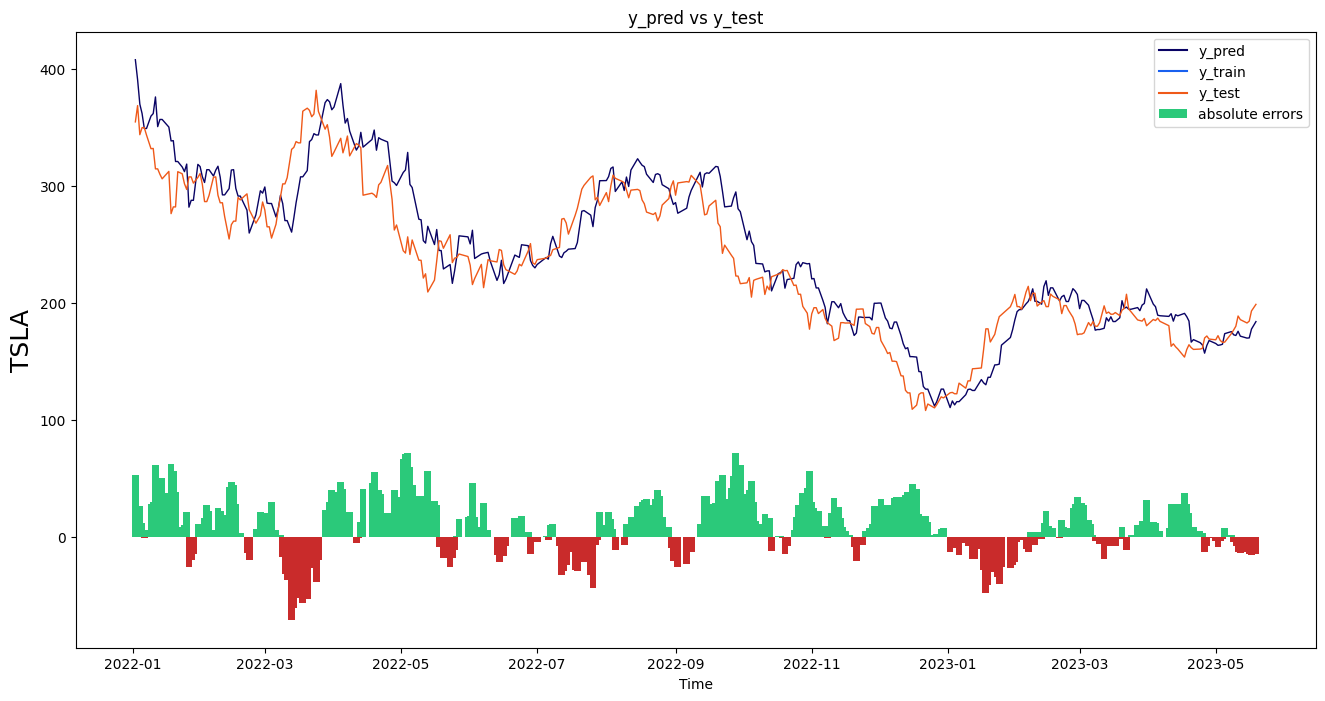

----------------------------------------------------- RACE ----------------------------------------------------------------------------------------
(978, 13) (978, 1)
(244, 13) (244, 1)
[14:08:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


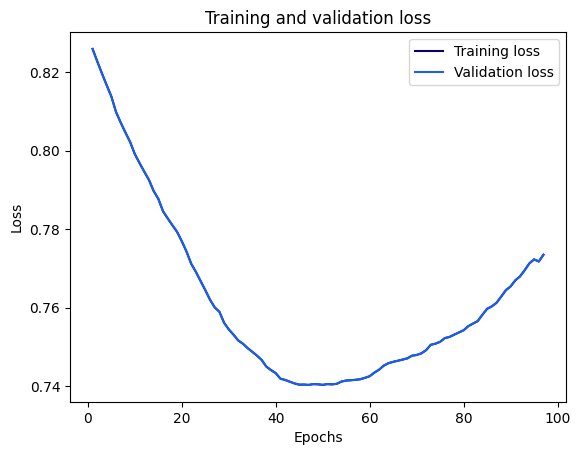

Con pct_change
Mean Absolute Error (MAE): 0.0294
Mean Absolute Percentage Error (MAPE): 312.8293 %
Median Absolute Percentage Error (MDAPE): 79.341 %
Mean Quatratic Error (RMSE): 0.0371
Sin pct_change
Mean Absolute Error (MAE): 6.6348
Mean Absolute Percentage Error (MAPE): 2.9126 %
Median Absolute Percentage Error (MDAPE): 2.4678 %
Mean Quatratic Error (RMSE): 8.2685


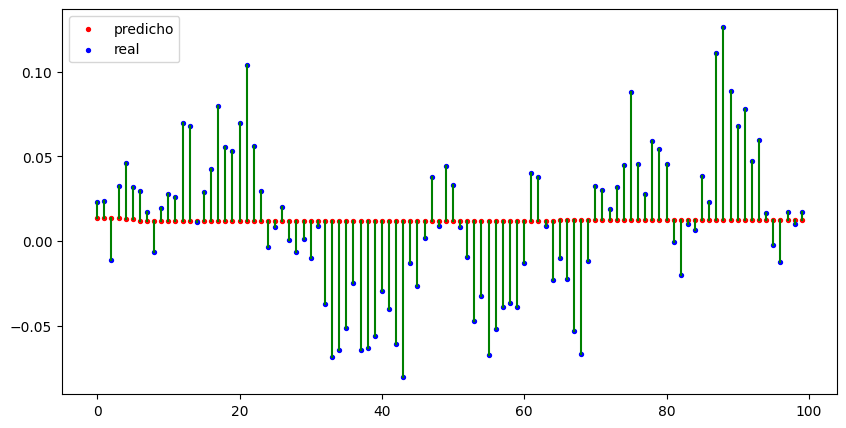

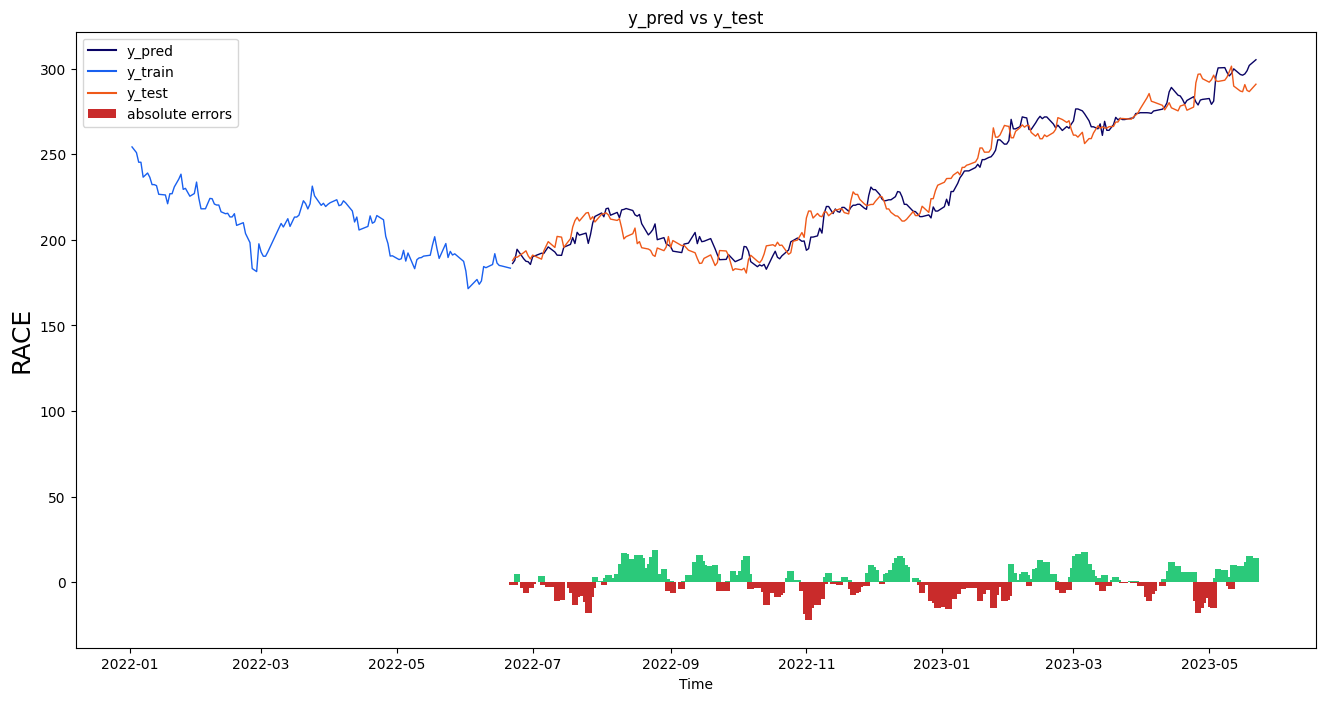

----------------------------------------------------- TM ----------------------------------------------------------------------------------------
(3840, 9) (3840, 1)
(960, 9) (960, 1)
[14:09:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


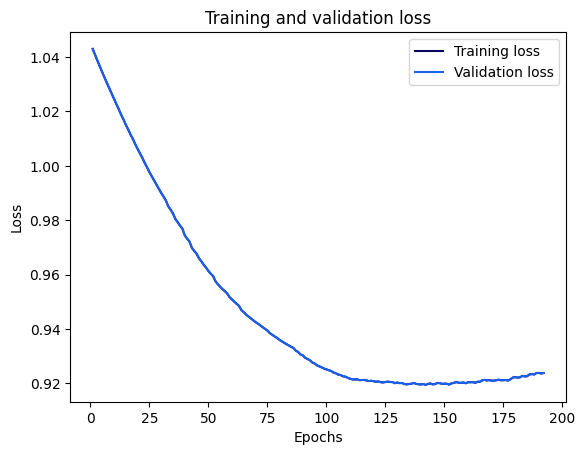

Con pct_change
Mean Absolute Error (MAE): 0.0282
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 108.1356 %
Mean Quatratic Error (RMSE): 0.0372
Sin pct_change
Mean Absolute Error (MAE): 4.3169
Mean Absolute Percentage Error (MAPE): 2.8274 %
Median Absolute Percentage Error (MDAPE): 2.156 %
Mean Quatratic Error (RMSE): 5.7836


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


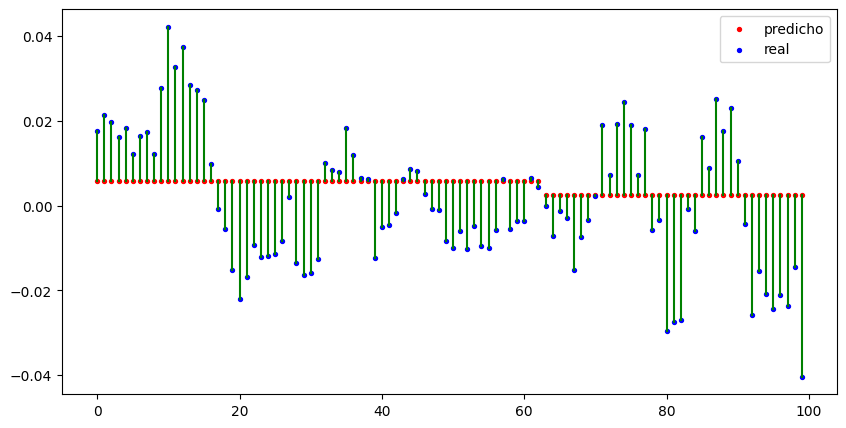

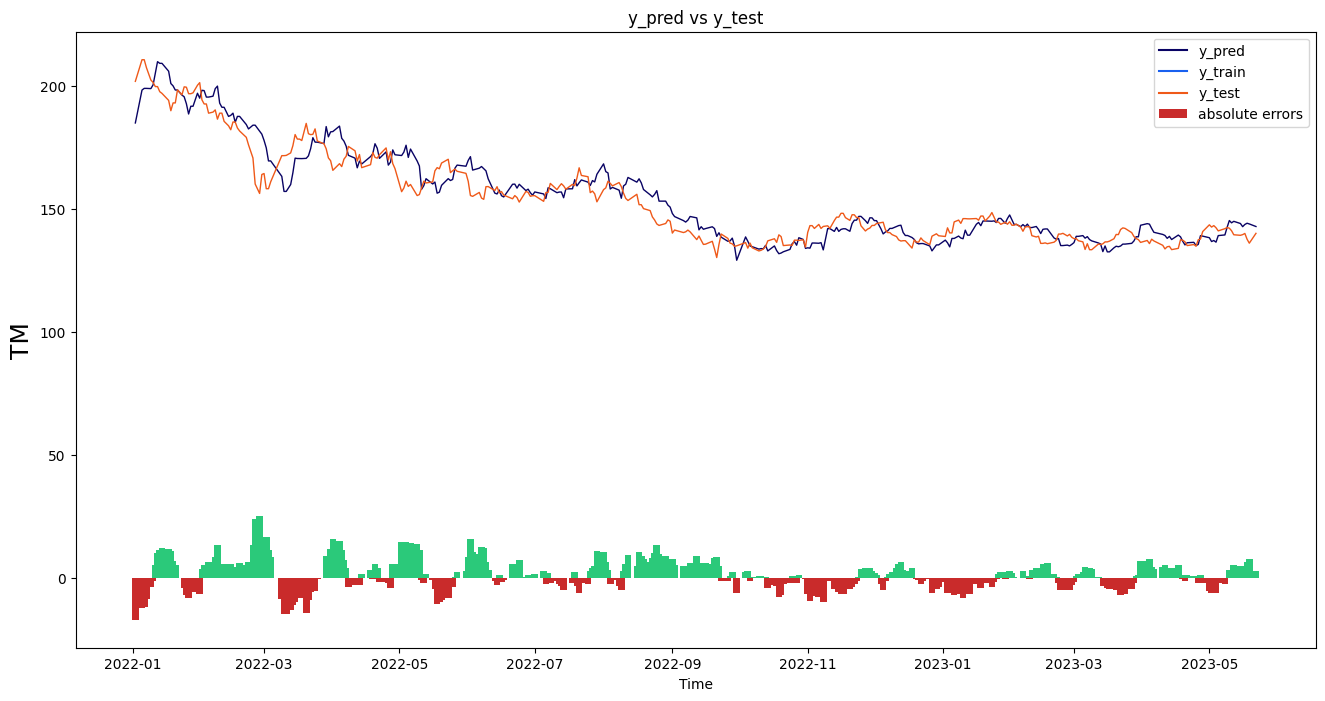

----------------------------------------------------- HMC ----------------------------------------------------------------------------------------
(4192, 33) (4192, 1)
(1047, 33) (1047, 1)
[14:09:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


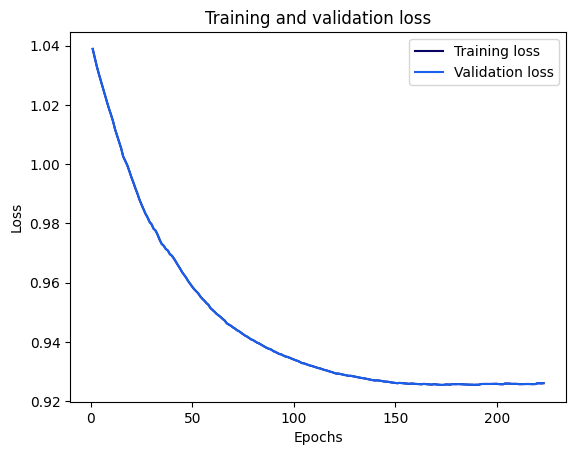

Con pct_change
Mean Absolute Error (MAE): 0.031
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 102.7799 %
Mean Quatratic Error (RMSE): 0.0418
Sin pct_change
Mean Absolute Error (MAE): 0.8278
Mean Absolute Percentage Error (MAPE): 3.1083 %
Median Absolute Percentage Error (MDAPE): 2.3746 %
Mean Quatratic Error (RMSE): 1.1015


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


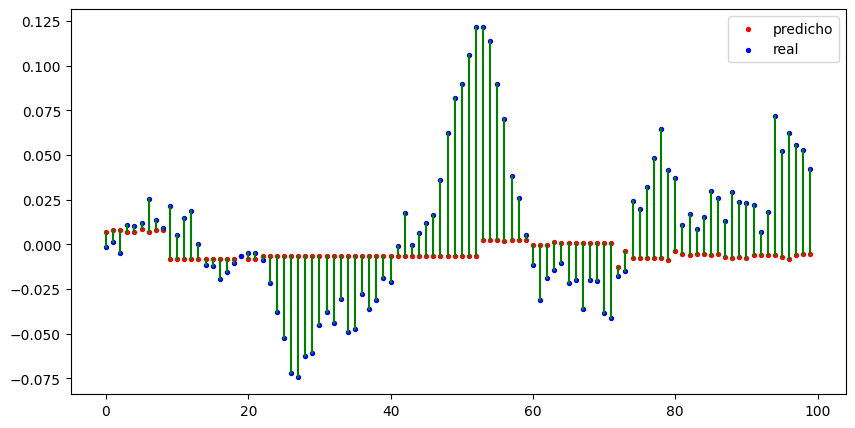

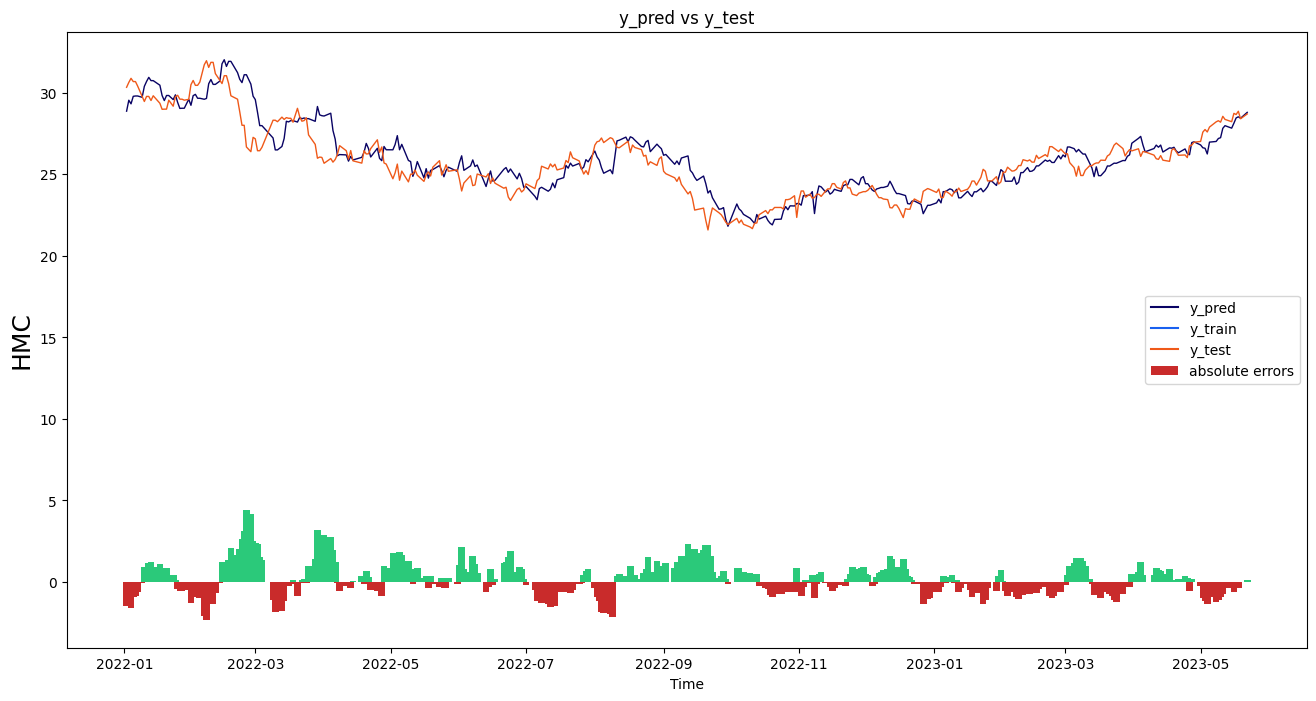

In [25]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8 )

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
[14:08:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


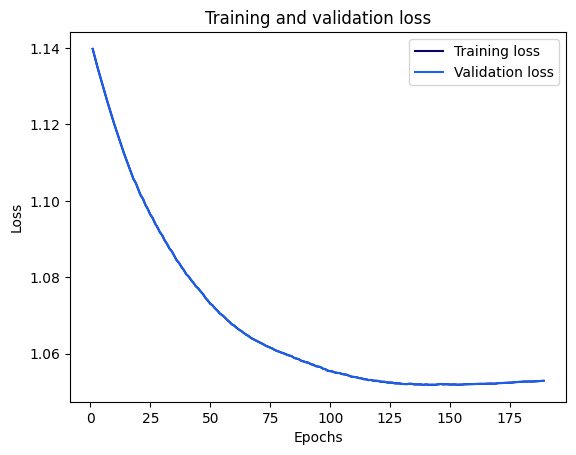

Con pct_change
Mean Absolute Error (MAE): 0.0493
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 95.4776 %
Mean Quatratic Error (RMSE): 0.0678
Sin pct_change
Mean Absolute Error (MAE): 0.5712
Mean Absolute Percentage Error (MAPE): 4.9351 %
Median Absolute Percentage Error (MDAPE): 3.4404 %
Mean Quatratic Error (RMSE): 0.8559


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


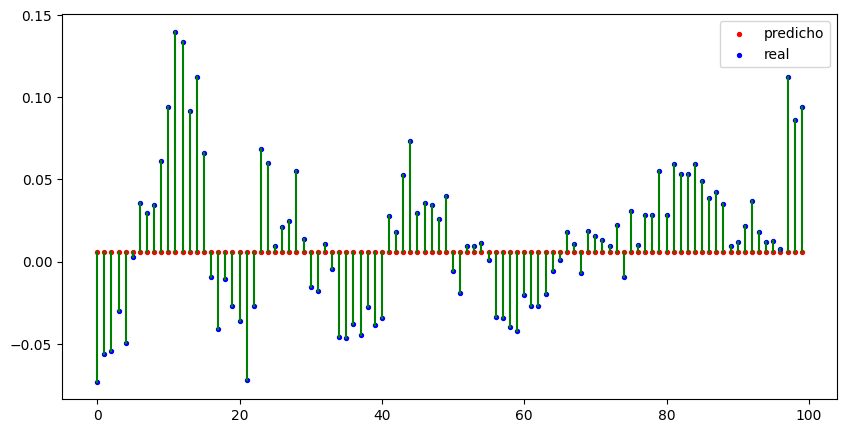

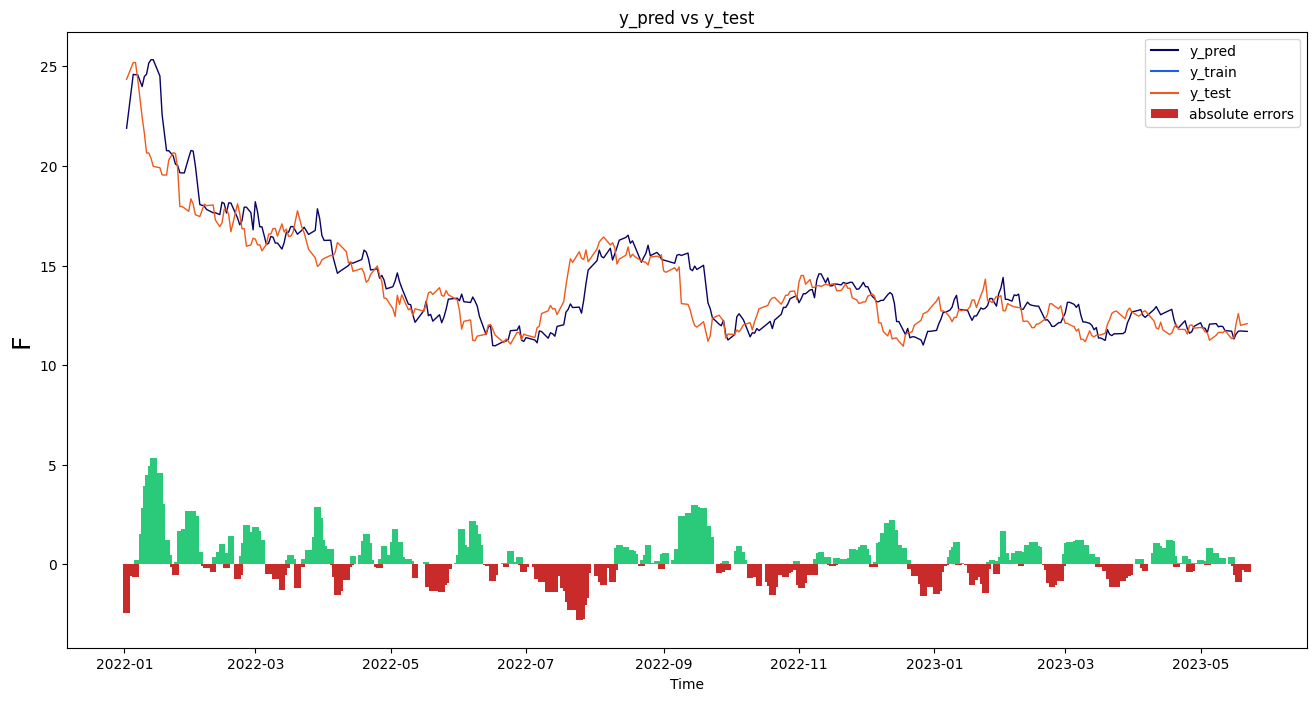

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 9) (2067, 1)
(516, 9) (516, 1)
[14:08:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


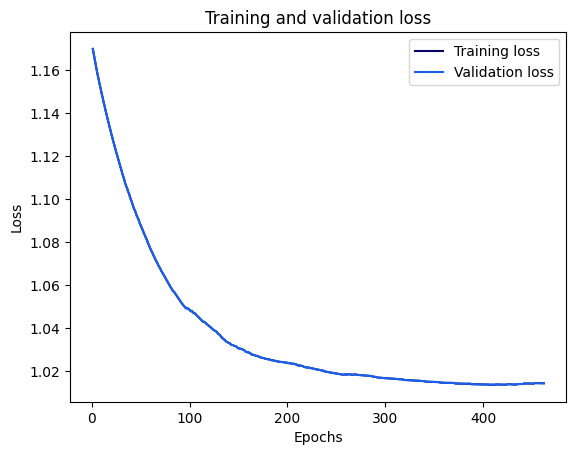

Con pct_change
Mean Absolute Error (MAE): 0.0493
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 100.0856 %
Mean Quatratic Error (RMSE): 0.0621
Sin pct_change
Mean Absolute Error (MAE): 2.1707
Mean Absolute Percentage Error (MAPE): 5.0579 %
Median Absolute Percentage Error (MDAPE): 4.209 %
Mean Quatratic Error (RMSE): 2.7876


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


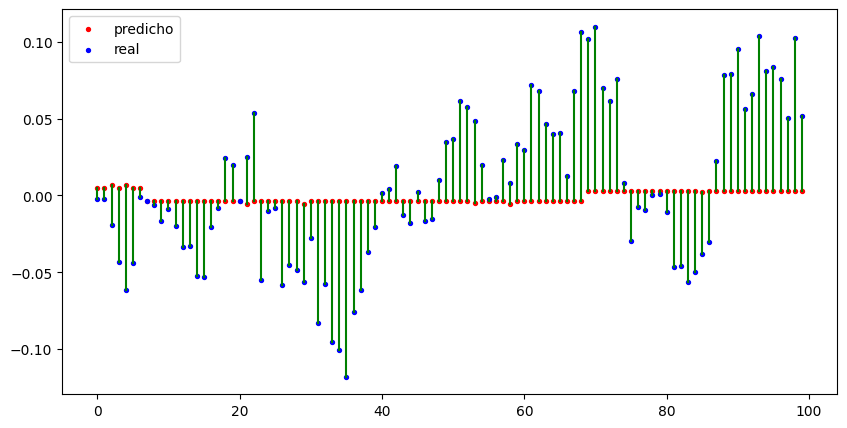

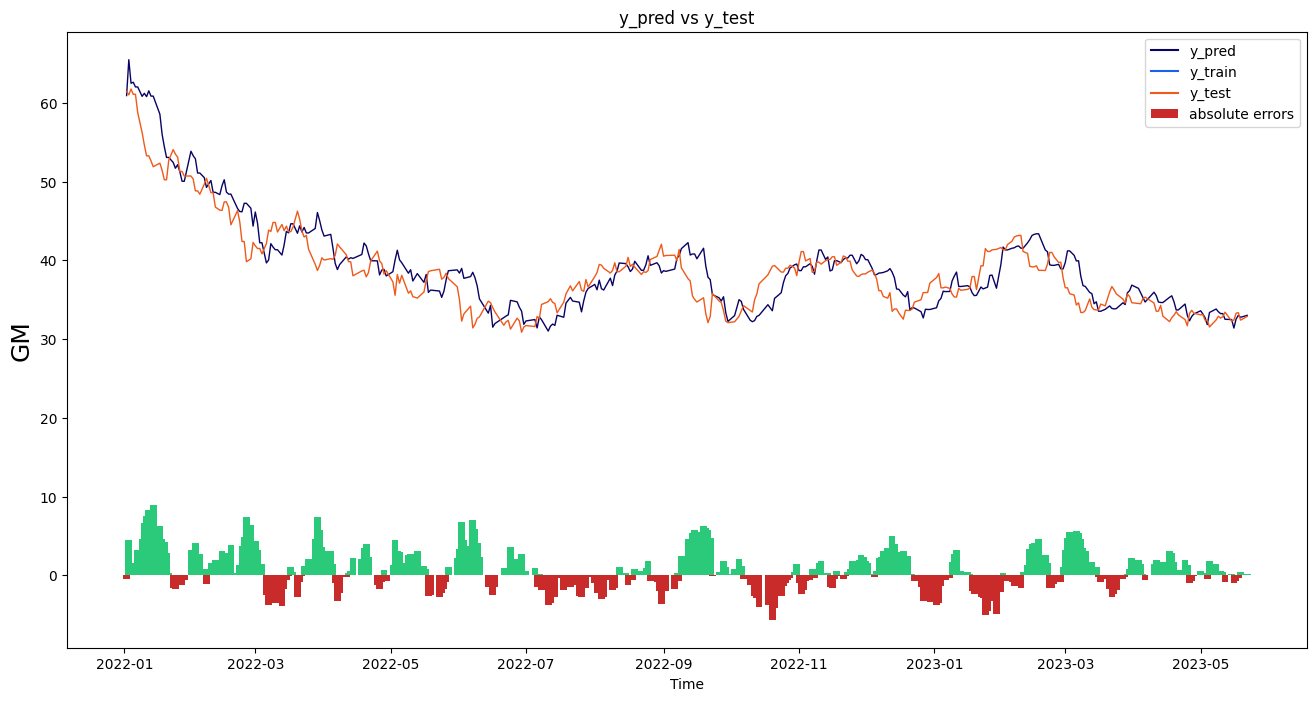

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 5) (2132, 1)
(533, 5) (533, 1)
[14:08:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


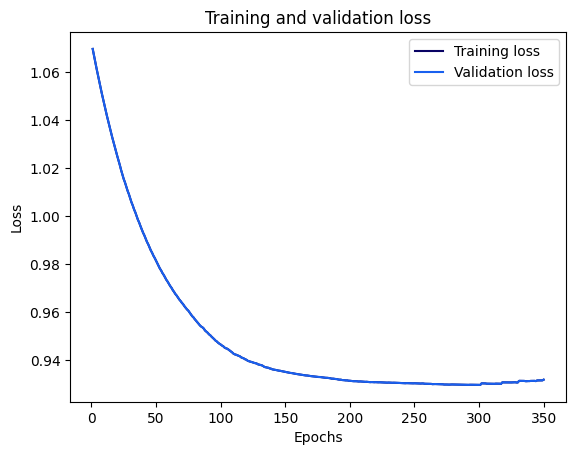

Con pct_change
Mean Absolute Error (MAE): 0.0766
Mean Absolute Percentage Error (MAPE): 139.5347 %
Median Absolute Percentage Error (MDAPE): 102.8124 %
Mean Quatratic Error (RMSE): 0.0998
Sin pct_change
Mean Absolute Error (MAE): 18.9788
Mean Absolute Percentage Error (MAPE): 7.7335 %
Median Absolute Percentage Error (MDAPE): 6.0906 %
Mean Quatratic Error (RMSE): 25.2954


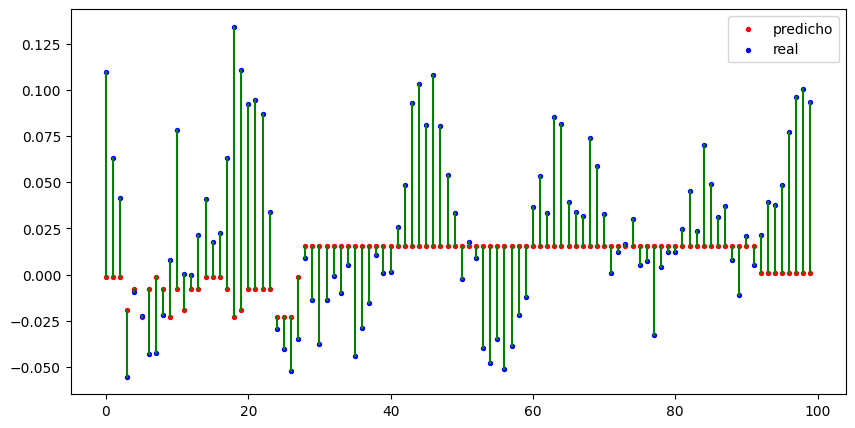

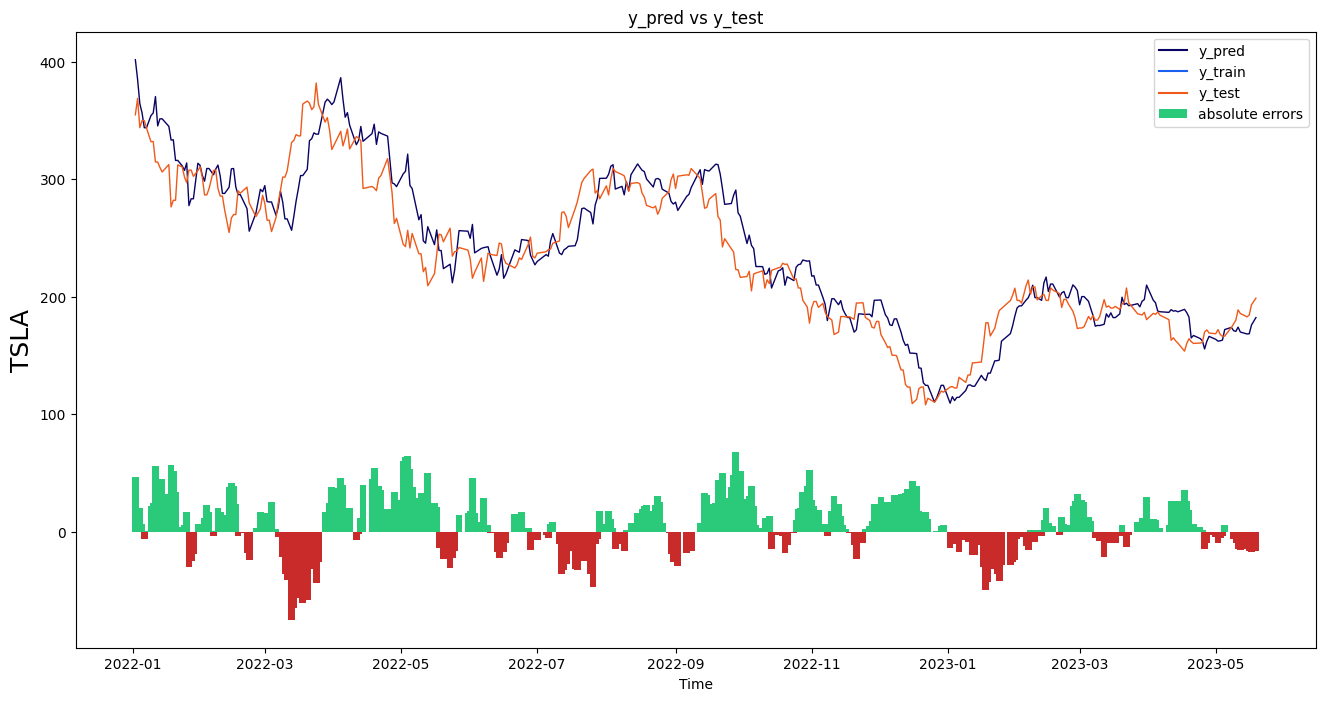

----------------------------------------------------- RACE ----------------------------------------------------------------------------------------
(978, 3) (978, 1)
(244, 3) (244, 1)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14:08:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


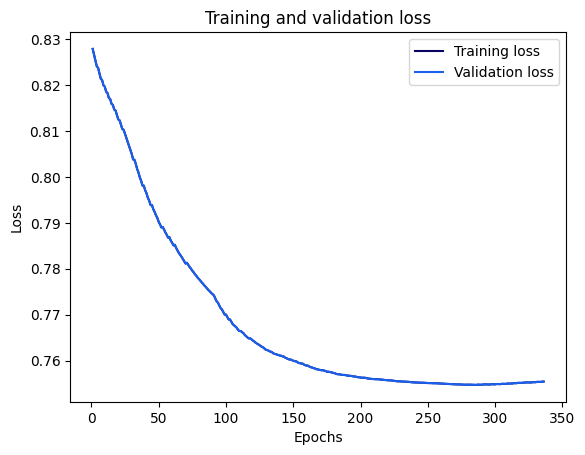

Con pct_change
Mean Absolute Error (MAE): 0.0302
Mean Absolute Percentage Error (MAPE): 342.5374 %
Median Absolute Percentage Error (MDAPE): 78.1841 %
Mean Quatratic Error (RMSE): 0.0378
Sin pct_change
Mean Absolute Error (MAE): 6.7917
Mean Absolute Percentage Error (MAPE): 2.9906 %
Median Absolute Percentage Error (MDAPE): 2.5169 %
Mean Quatratic Error (RMSE): 8.3957


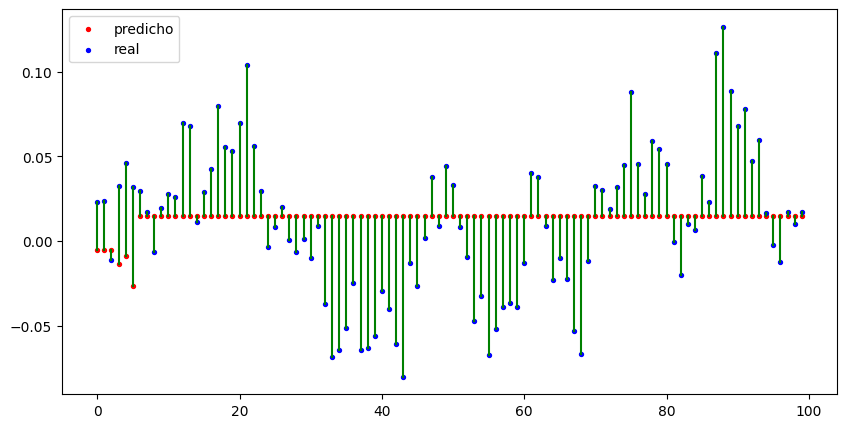

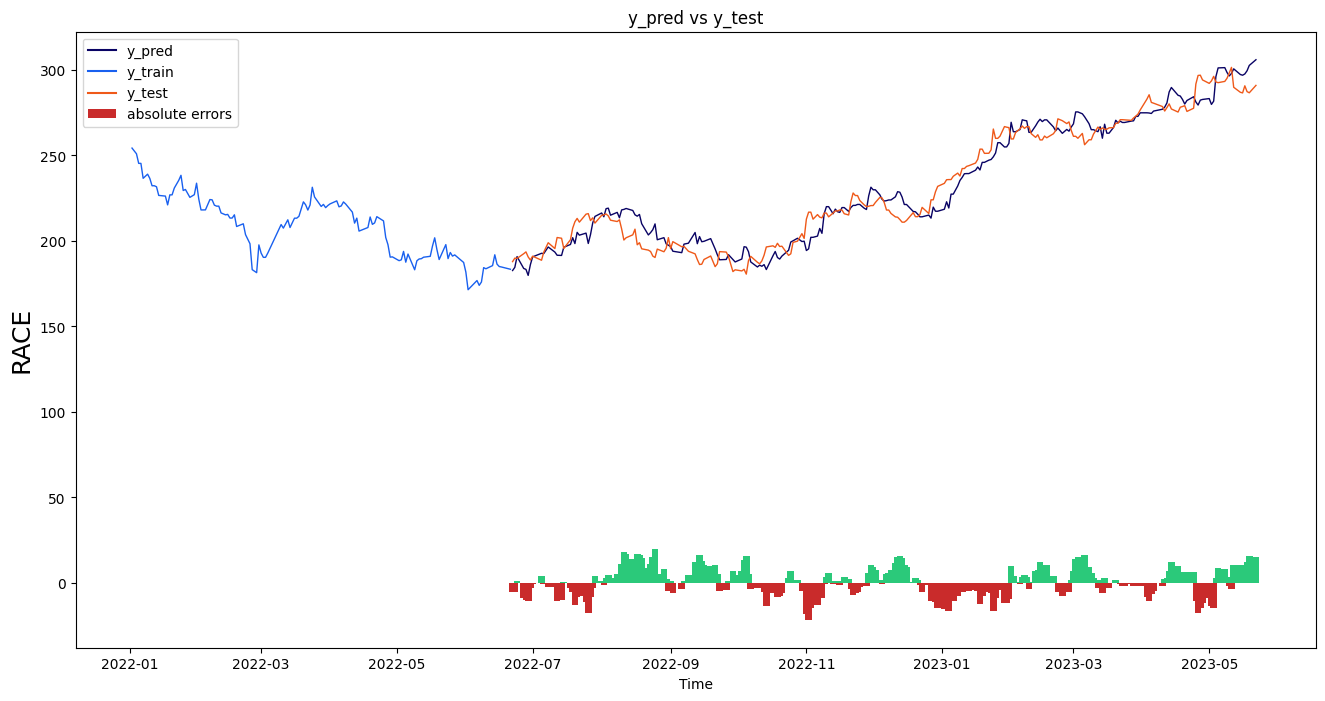

----------------------------------------------------- TM ----------------------------------------------------------------------------------------
(3840, 2) (3840, 1)
(960, 2) (960, 1)
[14:08:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


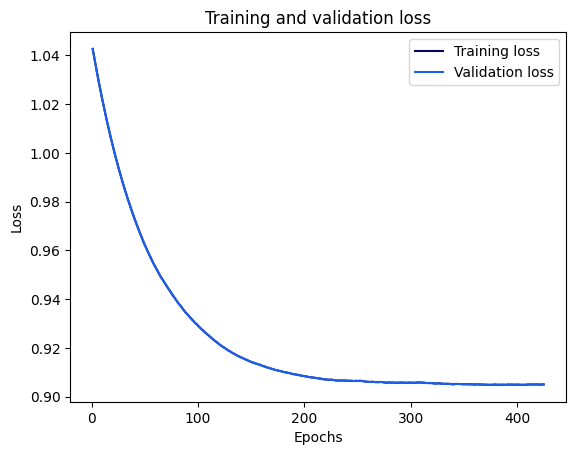

Con pct_change
Mean Absolute Error (MAE): 0.0278
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 100.9795 %
Mean Quatratic Error (RMSE): 0.0366
Sin pct_change
Mean Absolute Error (MAE): 4.2672
Mean Absolute Percentage Error (MAPE): 2.7837 %
Median Absolute Percentage Error (MDAPE): 2.1754 %
Mean Quatratic Error (RMSE): 5.7232


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


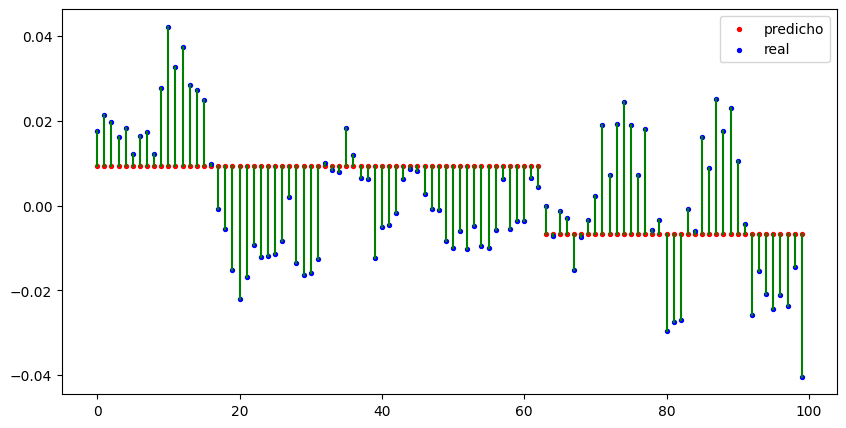

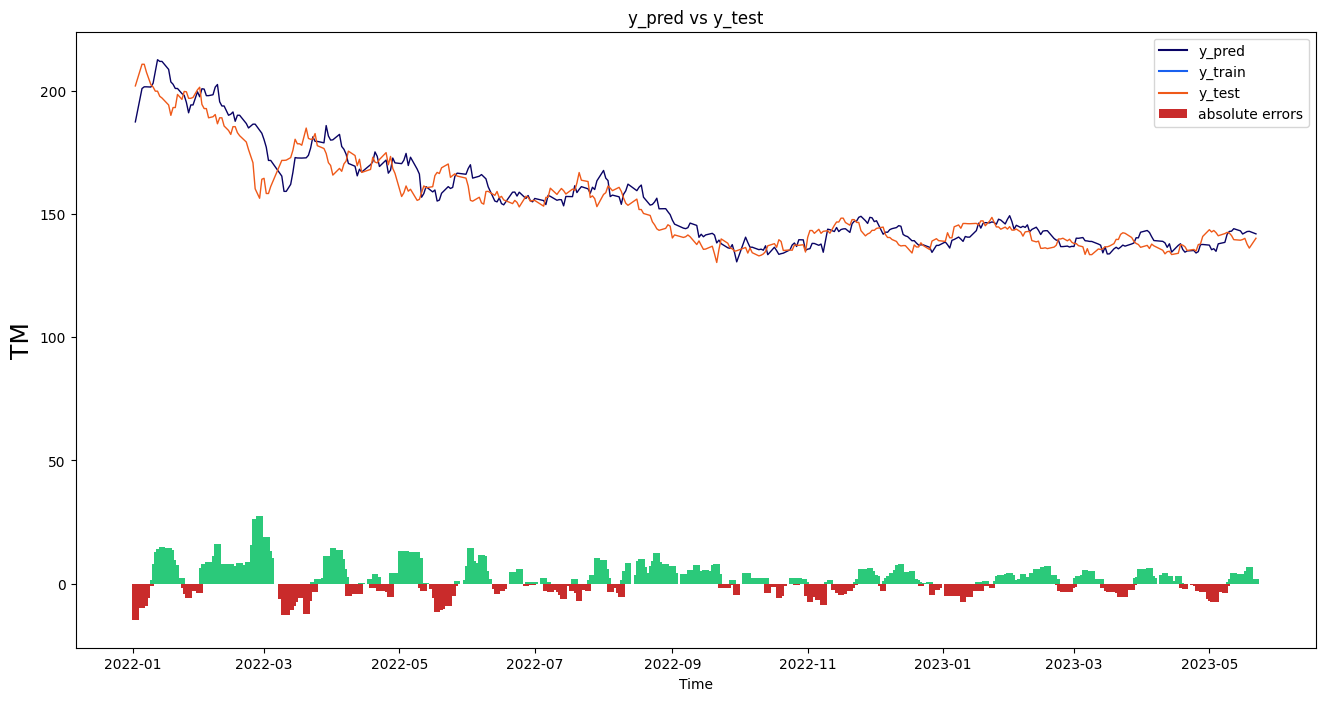

----------------------------------------------------- HMC ----------------------------------------------------------------------------------------
(4192, 3) (4192, 1)
(1047, 3) (1047, 1)
[14:08:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


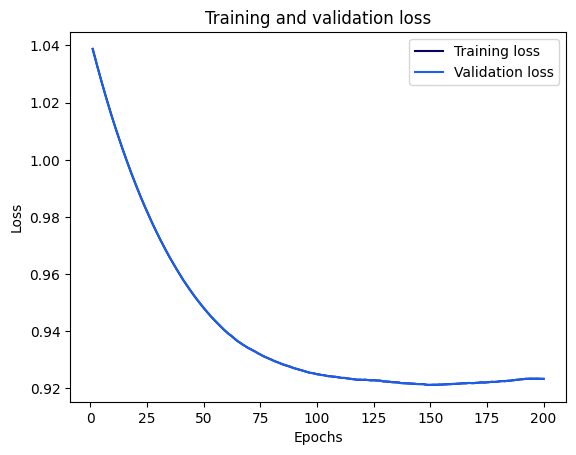

Con pct_change
Mean Absolute Error (MAE): 0.0303
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.2527 %
Mean Quatratic Error (RMSE): 0.0416
Sin pct_change
Mean Absolute Error (MAE): 0.8085
Mean Absolute Percentage Error (MAPE): 3.0375 %
Median Absolute Percentage Error (MDAPE): 2.1862 %
Mean Quatratic Error (RMSE): 1.0917


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


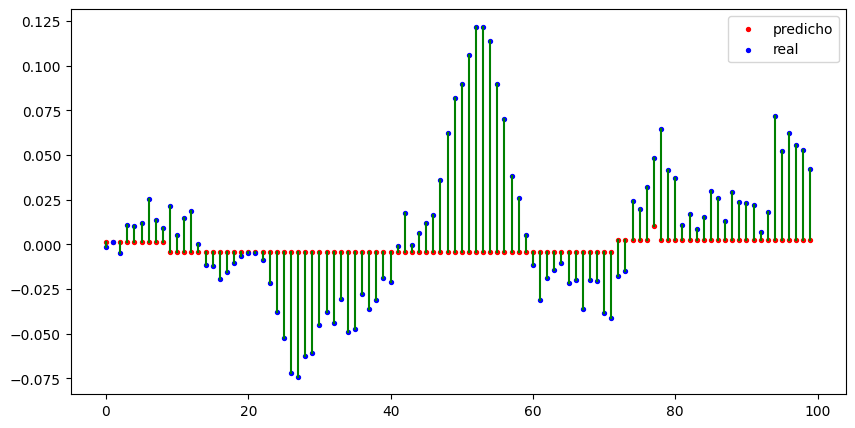

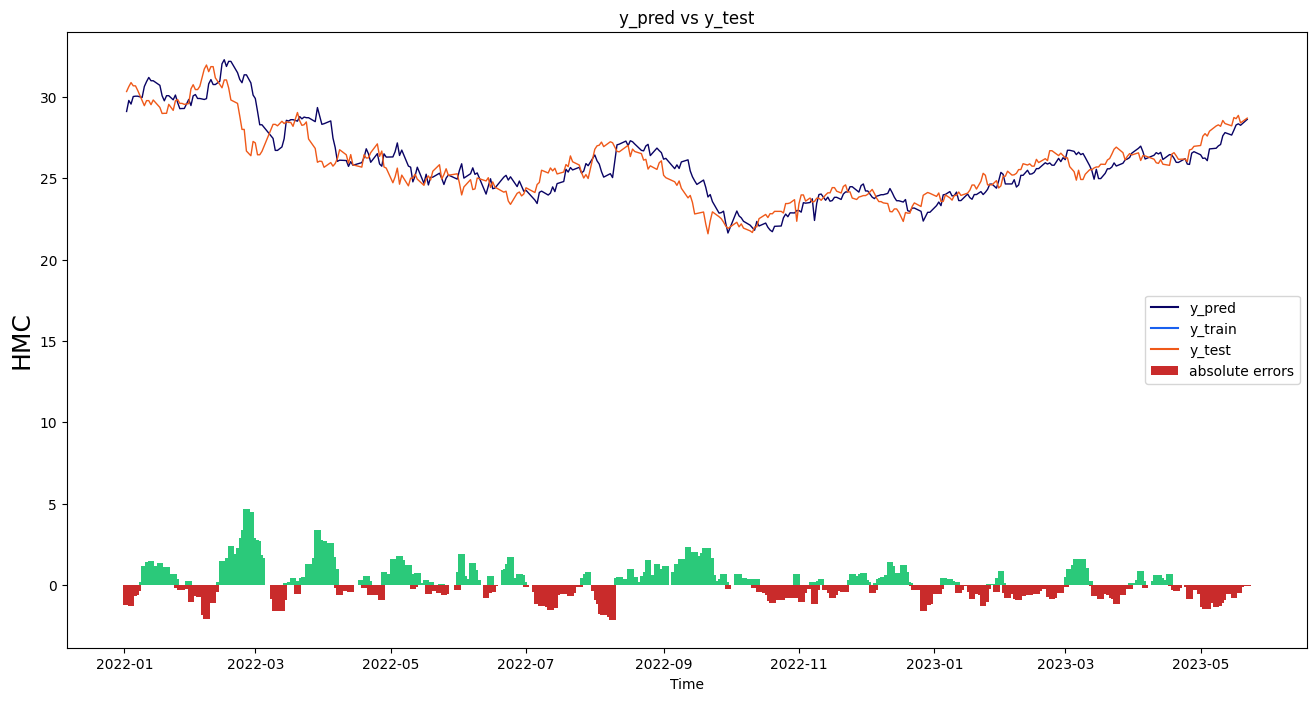

In [24]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8 )

# Optimización XGboost

(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
[15:39:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


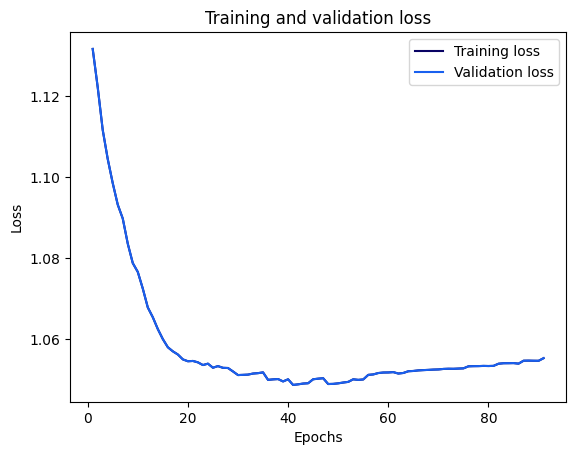

Con pct_change
Mean Absolute Error (MAE): 0.0491
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 98.1828 %
Mean Quatratic Error (RMSE): 0.0676
Sin pct_change
Mean Absolute Error (MAE): 0.5677
Mean Absolute Percentage Error (MAPE): 4.8985 %
Median Absolute Percentage Error (MDAPE): 3.5535 %
Mean Quatratic Error (RMSE): 0.8453


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


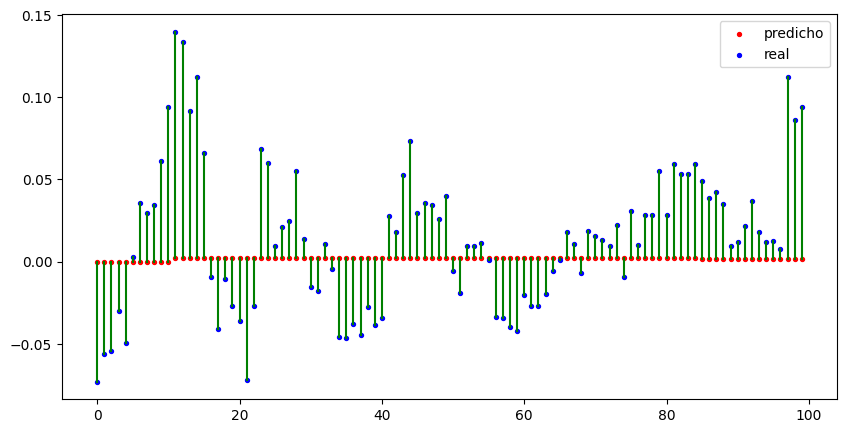

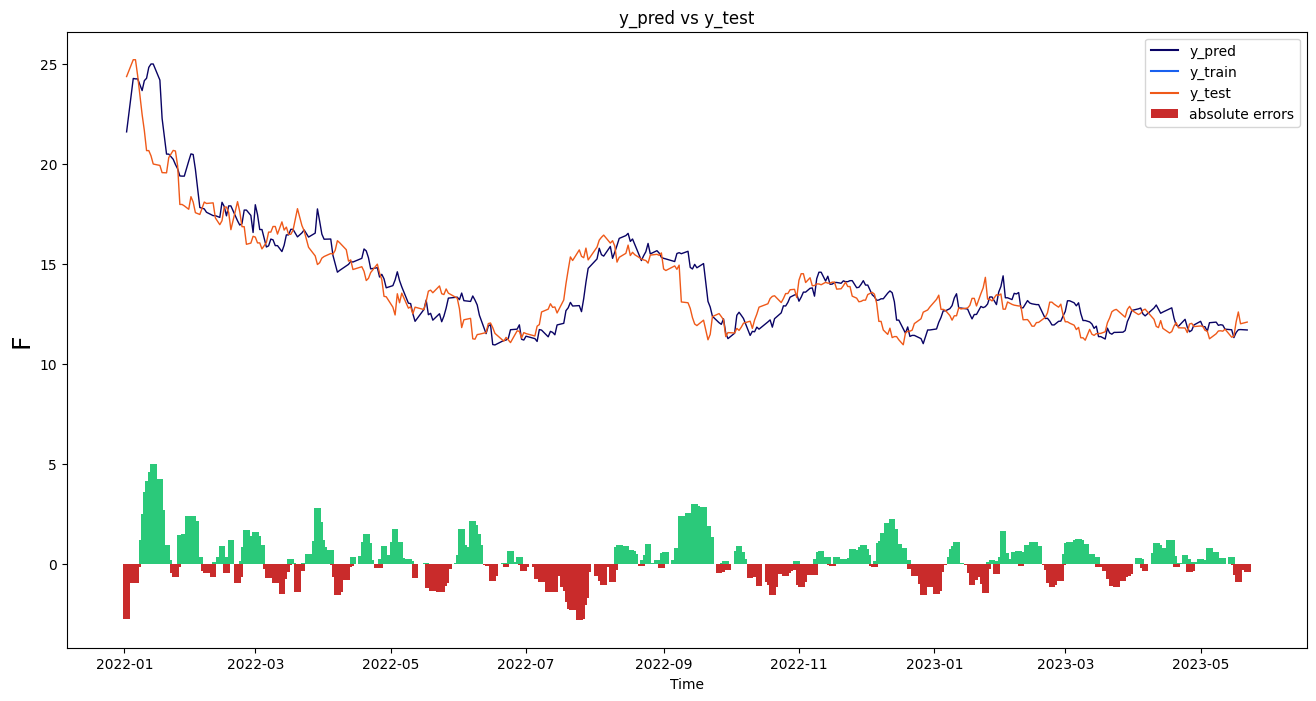

In [44]:
xgboost_model(lagged_stationary_dataframes['F'], 'F', booster = 'dart', n_estimators = 500, max_depth = 4, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(2067, 9) (2067, 1)
(516, 9) (516, 1)
[15:42:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


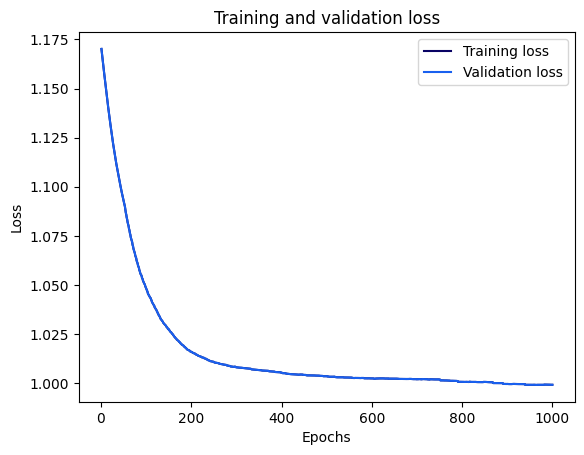

Con pct_change
Mean Absolute Error (MAE): 0.0485
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 96.4026 %
Mean Quatratic Error (RMSE): 0.0612
Sin pct_change
Mean Absolute Error (MAE): 2.1405
Mean Absolute Percentage Error (MAPE): 4.9727 %
Median Absolute Percentage Error (MDAPE): 4.1067 %
Mean Quatratic Error (RMSE): 2.7513


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


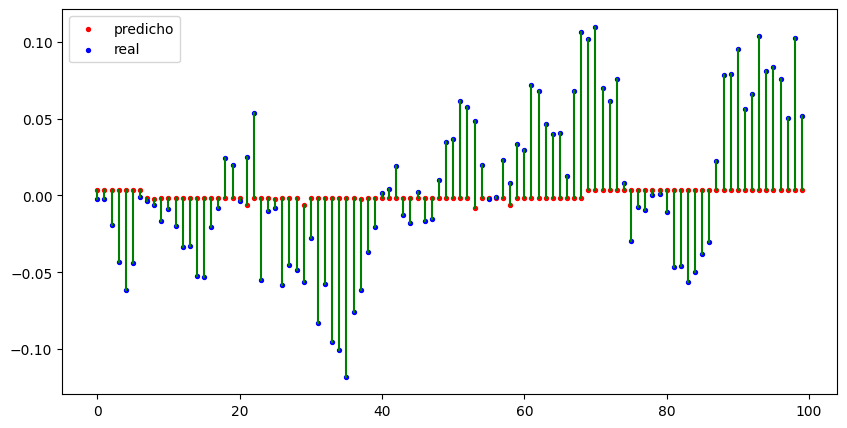

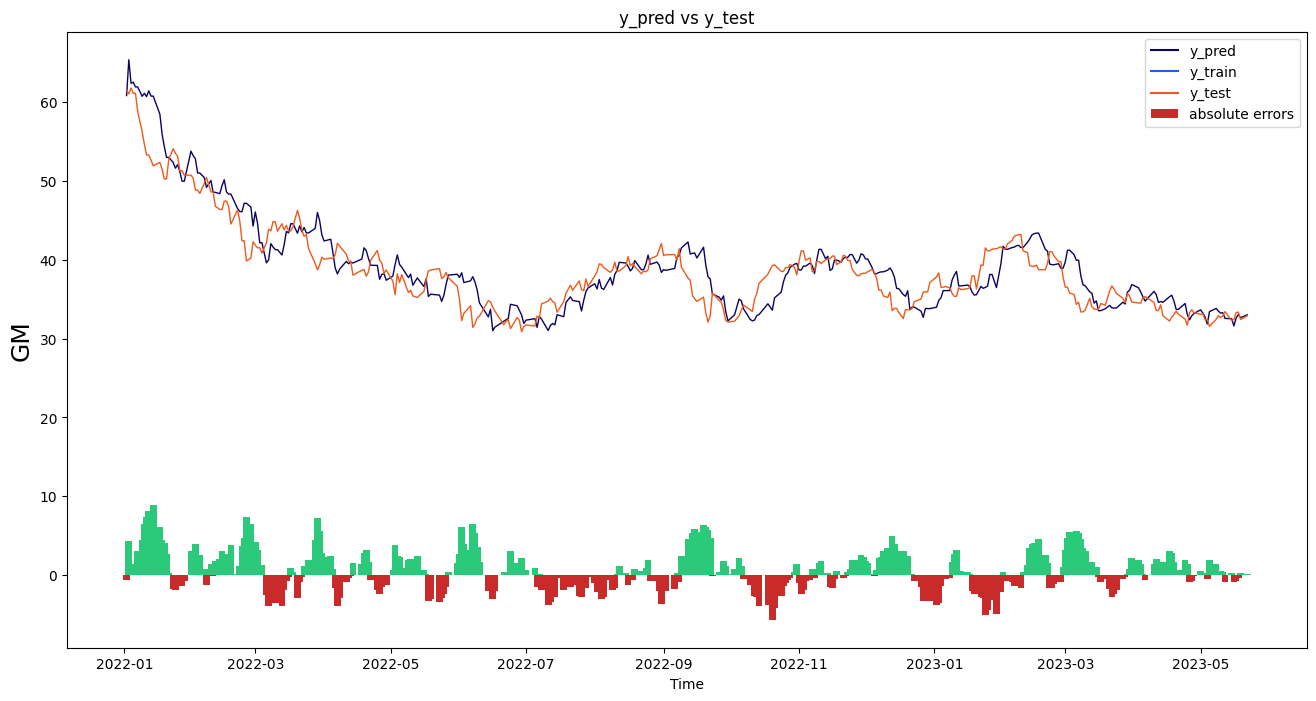

In [53]:
xgboost_model(lagged_stationary_dataframes['GM'], 'GM', booster = 'gbtree', n_estimators = 1000, max_depth = 2, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(2132, 5) (2132, 1)
(533, 5) (533, 1)
[15:47:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


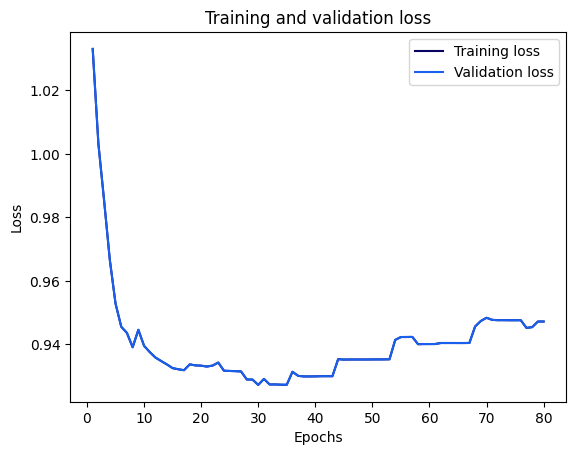

Con pct_change
Mean Absolute Error (MAE): 0.0767
Mean Absolute Percentage Error (MAPE): 154.4342 %
Median Absolute Percentage Error (MDAPE): 105.4145 %
Mean Quatratic Error (RMSE): 0.0995
Sin pct_change
Mean Absolute Error (MAE): 19.0662
Mean Absolute Percentage Error (MAPE): 7.7576 %
Median Absolute Percentage Error (MDAPE): 6.1402 %
Mean Quatratic Error (RMSE): 25.2895


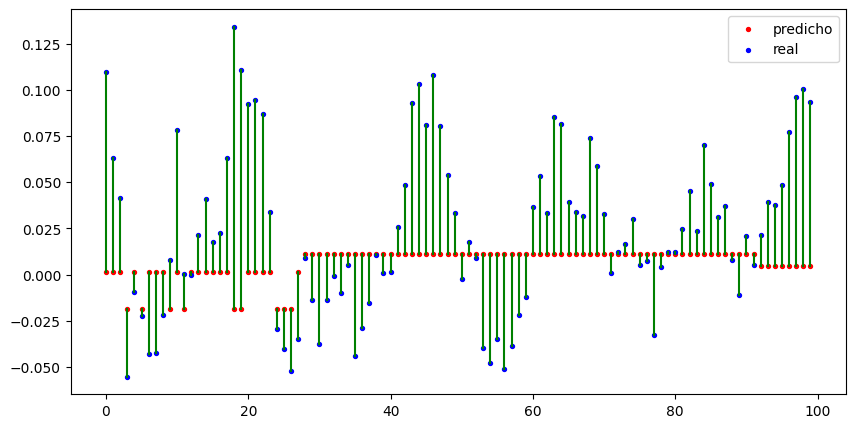

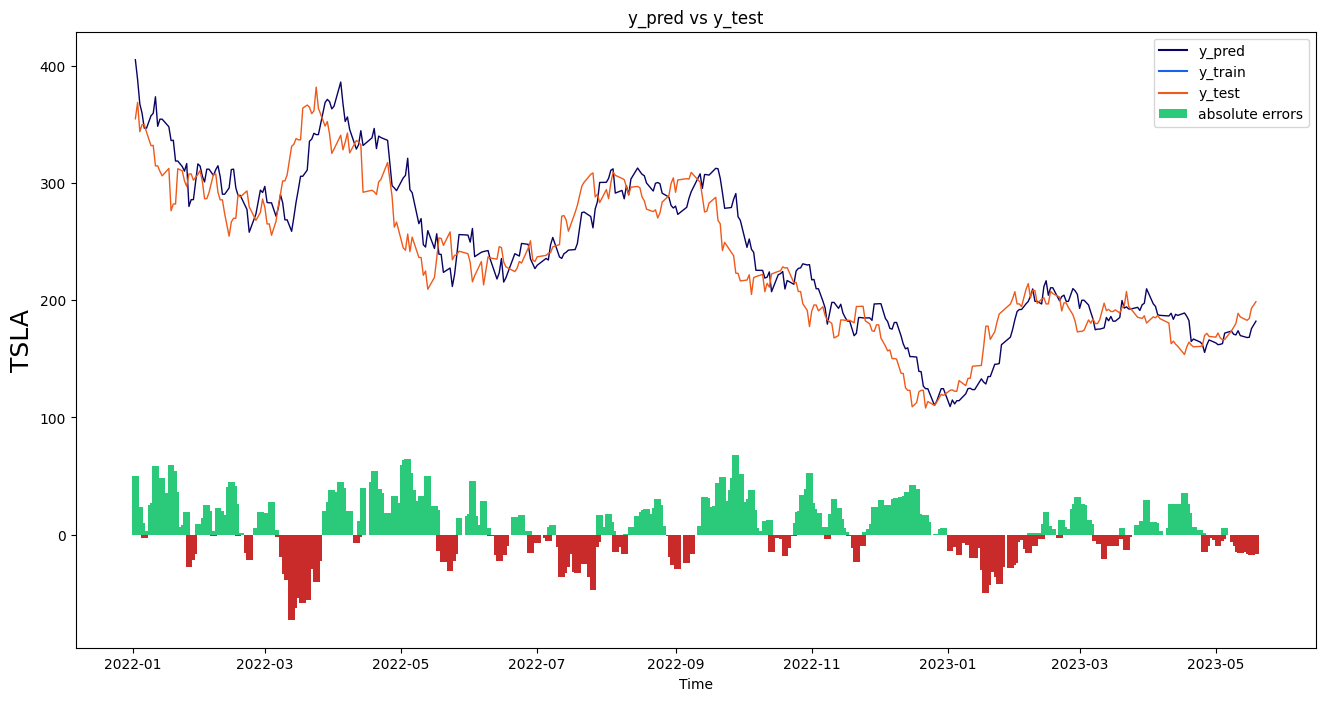

In [67]:
xgboost_model(lagged_stationary_dataframes['TSLA'], 'TSLA', booster = 'dart', n_estimators = 1000, max_depth = 2, learning_rate = 0.15,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(978, 3) (978, 1)
(244, 3) (244, 1)
[15:49:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


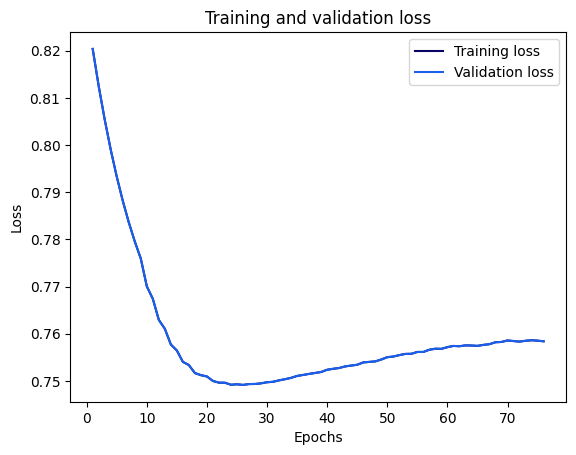

Con pct_change
Mean Absolute Error (MAE): 0.03
Mean Absolute Percentage Error (MAPE): 322.5263 %
Median Absolute Percentage Error (MDAPE): 79.7226 %
Mean Quatratic Error (RMSE): 0.0375
Sin pct_change
Mean Absolute Error (MAE): 6.7527
Mean Absolute Percentage Error (MAPE): 2.9691 %
Median Absolute Percentage Error (MDAPE): 2.4175 %
Mean Quatratic Error (RMSE): 8.3417


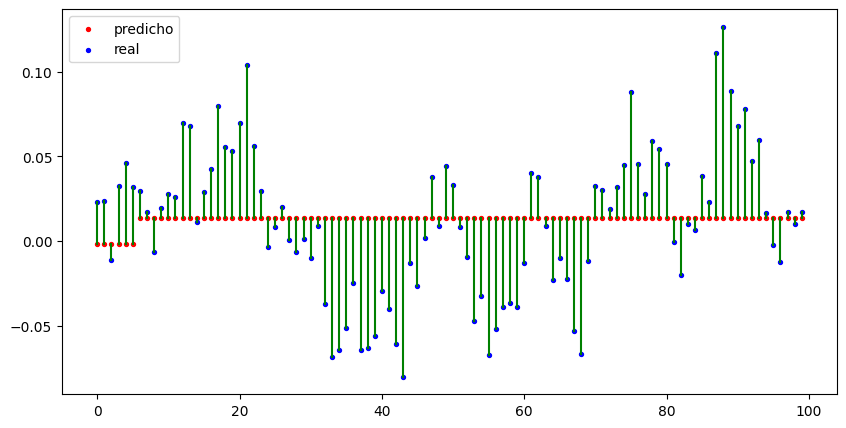

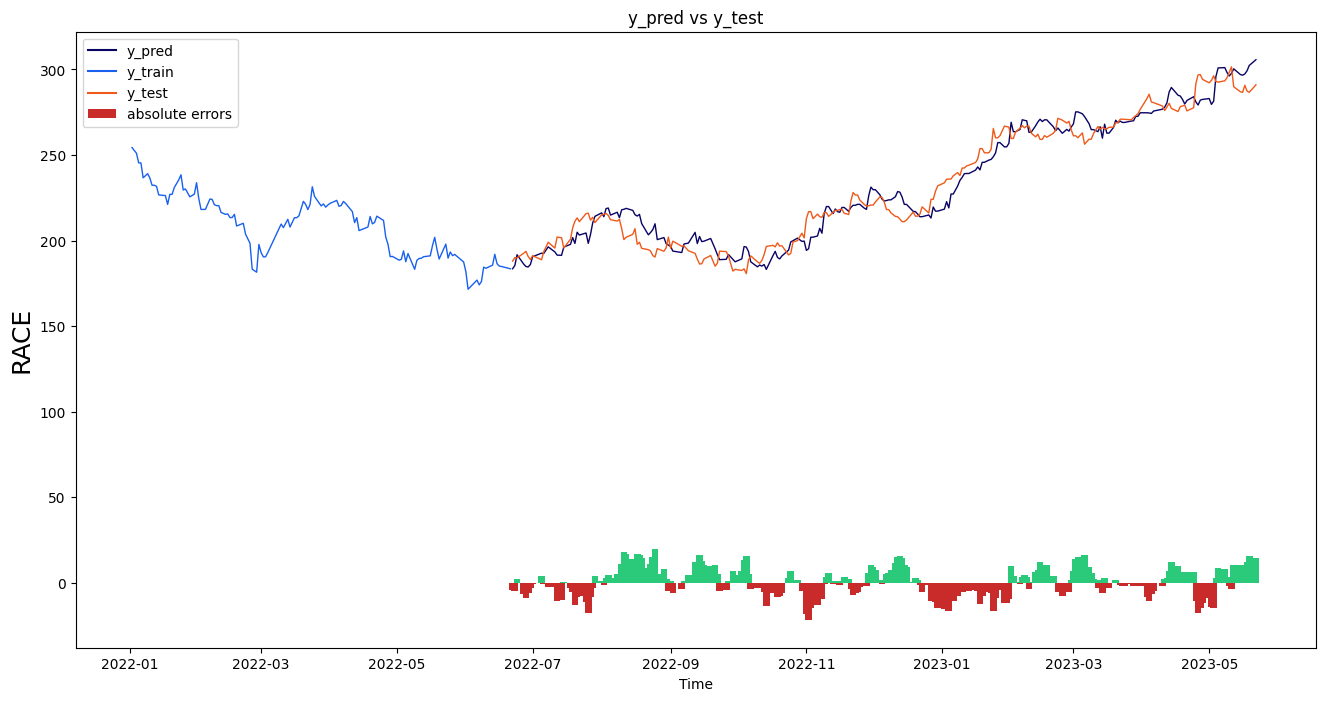

In [75]:
xgboost_model(lagged_stationary_dataframes['RACE'], 'RACE', booster = 'gbtree', n_estimators = 100, max_depth = 1, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(3840, 2) (3840, 1)
(960, 2) (960, 1)
[15:50:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


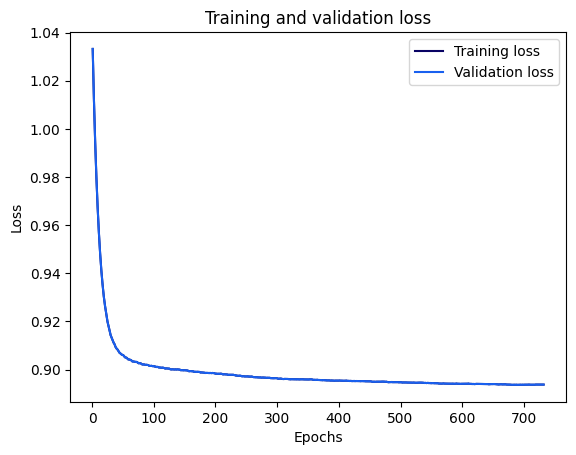

Con pct_change
Mean Absolute Error (MAE): 0.0274
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.2623 %
Mean Quatratic Error (RMSE): 0.0361
Sin pct_change
Mean Absolute Error (MAE): 4.2097
Mean Absolute Percentage Error (MAPE): 2.7453 %
Median Absolute Percentage Error (MDAPE): 2.1716 %
Mean Quatratic Error (RMSE): 5.629


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


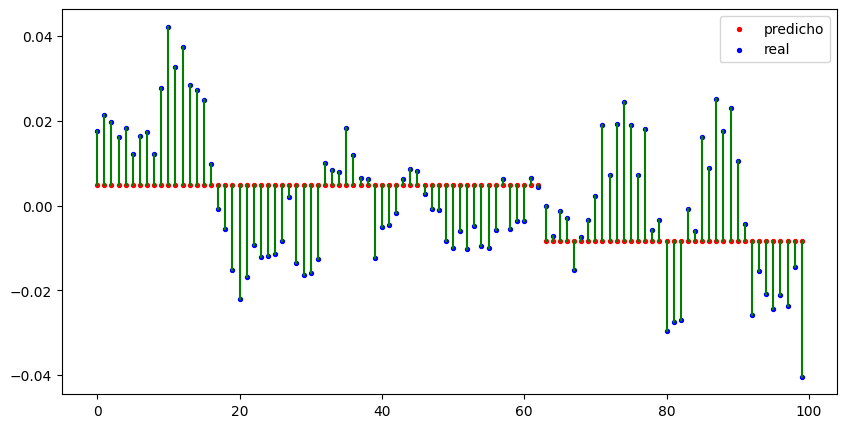

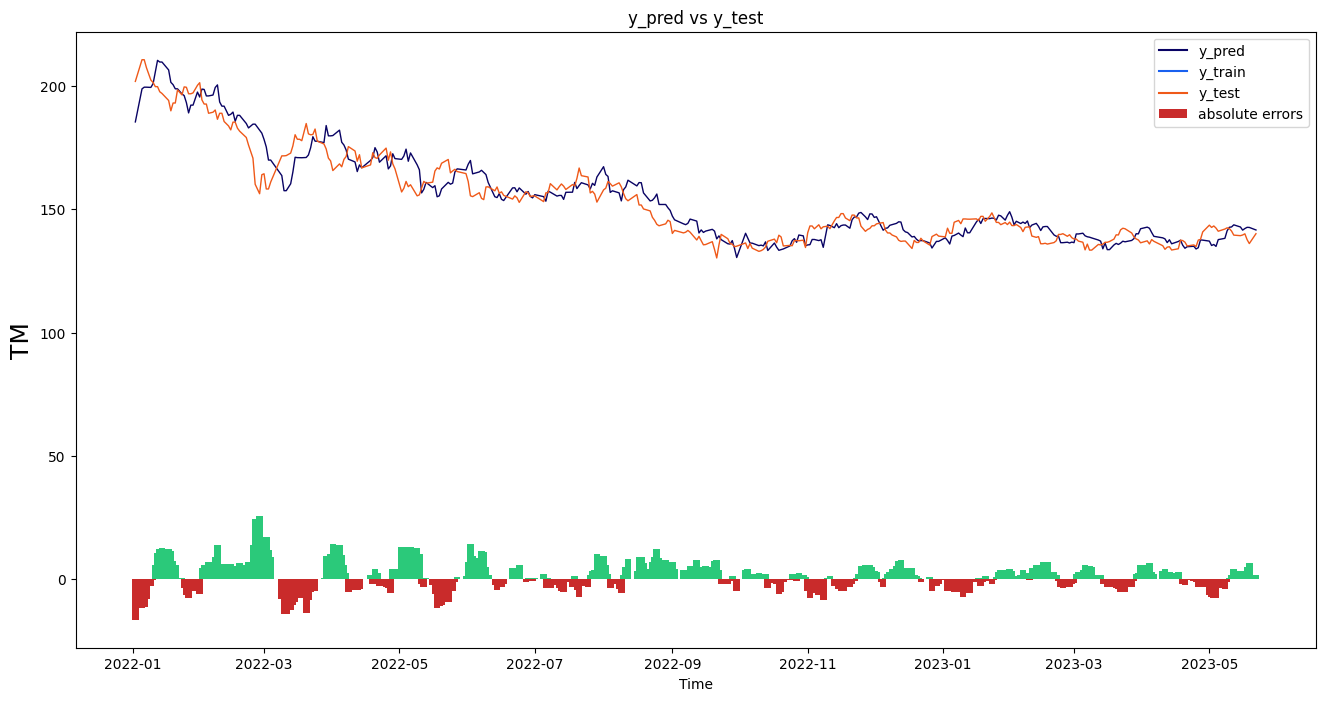

In [80]:
xgboost_model(lagged_stationary_dataframes['TM'], 'TM', booster = 'gbtree', n_estimators = 1000, max_depth = 1, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(4192, 3) (4192, 1)
(1047, 3) (1047, 1)
[15:55:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


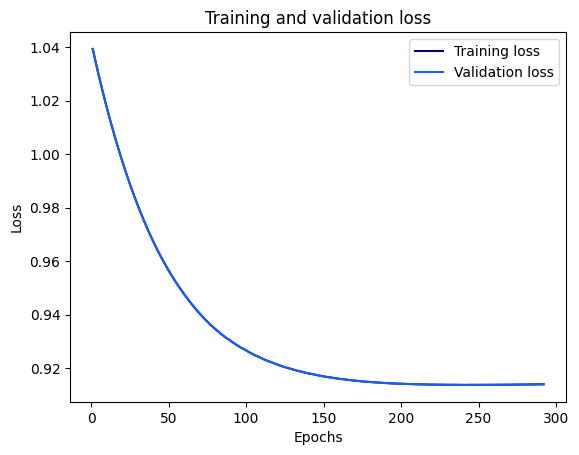

Con pct_change
Mean Absolute Error (MAE): 0.0305
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 100.4359 %
Mean Quatratic Error (RMSE): 0.0412
Sin pct_change
Mean Absolute Error (MAE): 0.812
Mean Absolute Percentage Error (MAPE): 3.0503 %
Median Absolute Percentage Error (MDAPE): 2.3217 %
Mean Quatratic Error (RMSE): 1.0836


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


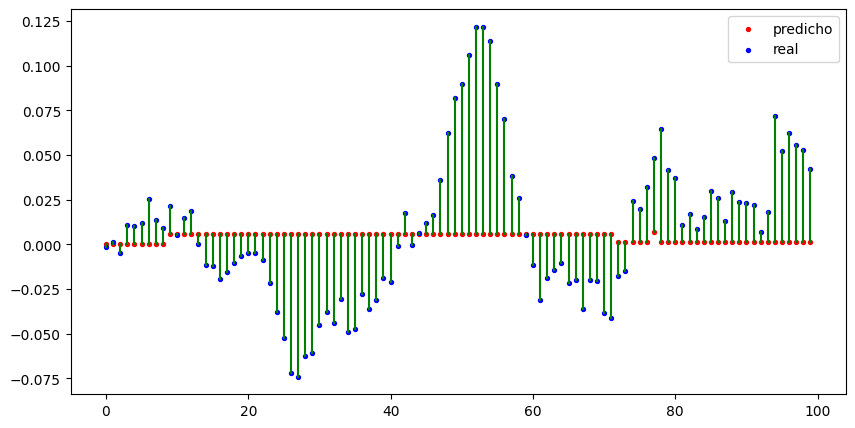

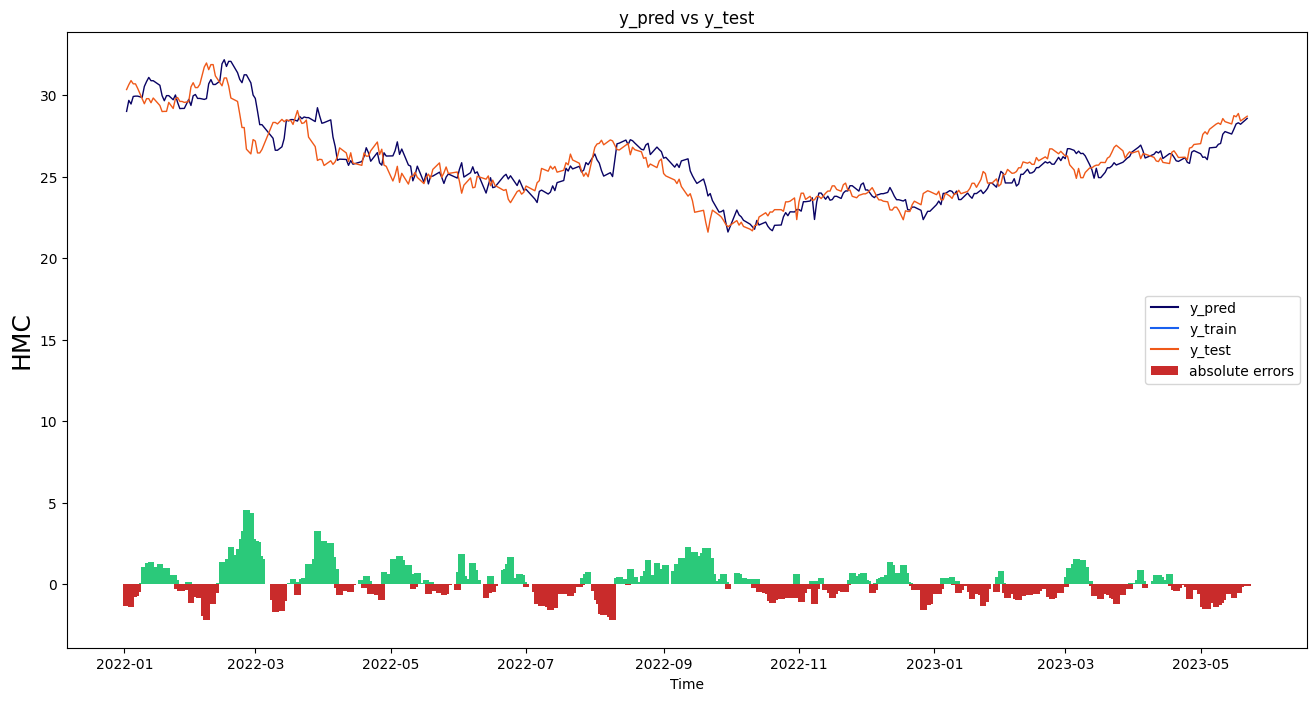

In [99]:
xgboost_model(lagged_stationary_dataframes['HMC'], 'HMC', booster = 'dart', n_estimators = 1000, max_depth = 1, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [27]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_model(df, brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True ):
    np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

    X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

    reg = RandomForestRegressor(n_estimators=1000)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    # Convert the arrays back to the original scale
    y_test = scaler_pred.inverse_transform(y_test)
    y_pred= scaler_pred.inverse_transform(y_pred.reshape(-1,1))

    print('Con pct_change')
    MAE, MAPE, MDAPE, RMSE = errors(y_test, y_pred)
    df_union = results_df(df, brand, train_perc, stationary, y_pred)
    print('Sin pct_change')

    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())

    df_union_zoom = df_union[df_union.index > display_start_date]
    # Plot the actual values
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(brand, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    plt.xlabel('Time')
    plt.ylabel(brand)
    plt.legend()
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()

    plt.show()


(4744, 4) (4744, 1)
(1186, 4) (1186, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0537
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 107.9832 %
Mean Quatratic Error (RMSE): 0.0727
Sin pct_change
Mean Absolute Error (MAE): 0.6238
Mean Absolute Percentage Error (MAPE): 5.3424 %
Median Absolute Percentage Error (MDAPE): 3.9353 %
Mean Quatratic Error (RMSE): 0.9127


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


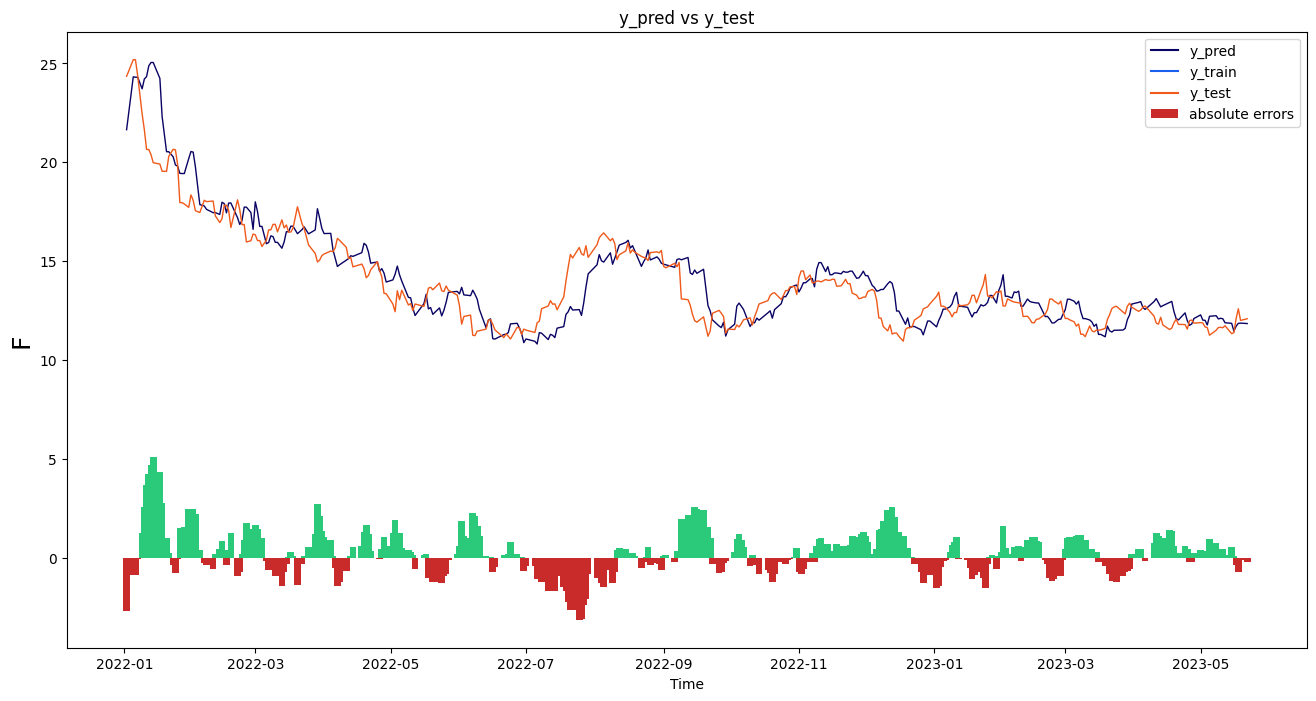

(2067, 10) (2067, 1)
(516, 10) (516, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0669
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 125.4037 %
Mean Quatratic Error (RMSE): 0.0867
Sin pct_change
Mean Absolute Error (MAE): 3.0657
Mean Absolute Percentage Error (MAPE): 6.9765 %
Median Absolute Percentage Error (MDAPE): 4.9026 %
Mean Quatratic Error (RMSE): 4.157


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


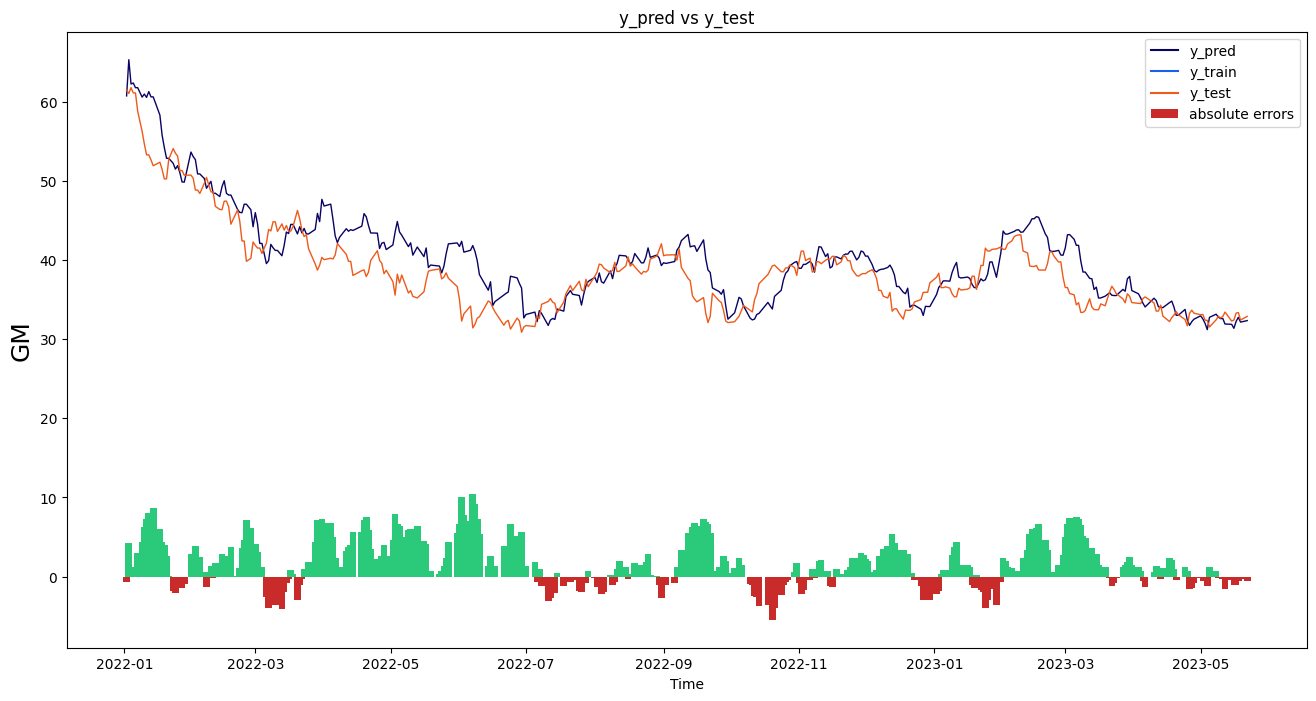

(2132, 16) (2132, 1)
(533, 16) (533, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0804
Mean Absolute Percentage Error (MAPE): 277.5076 %
Median Absolute Percentage Error (MDAPE): 112.8007 %
Mean Quatratic Error (RMSE): 0.1016
Sin pct_change
Mean Absolute Error (MAE): 20.1405
Mean Absolute Percentage Error (MAPE): 8.1968 %
Median Absolute Percentage Error (MDAPE): 6.6828 %
Mean Quatratic Error (RMSE): 26.164


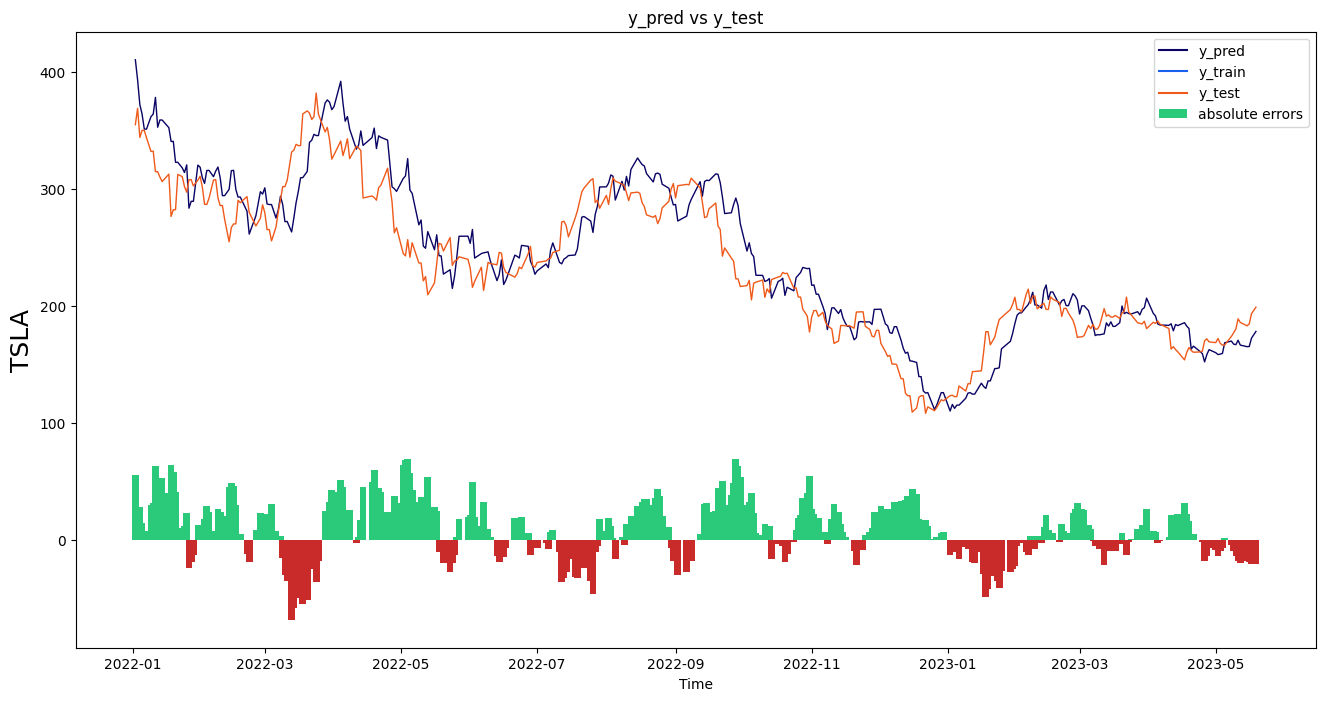

(978, 13) (978, 1)
(244, 13) (244, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0401
Mean Absolute Percentage Error (MAPE): 572.7011 %
Median Absolute Percentage Error (MDAPE): 138.9041 %
Mean Quatratic Error (RMSE): 0.0488
Sin pct_change
Mean Absolute Error (MAE): 9.0506
Mean Absolute Percentage Error (MAPE): 3.8889 %
Median Absolute Percentage Error (MDAPE): 3.508 %
Mean Quatratic Error (RMSE): 10.9847


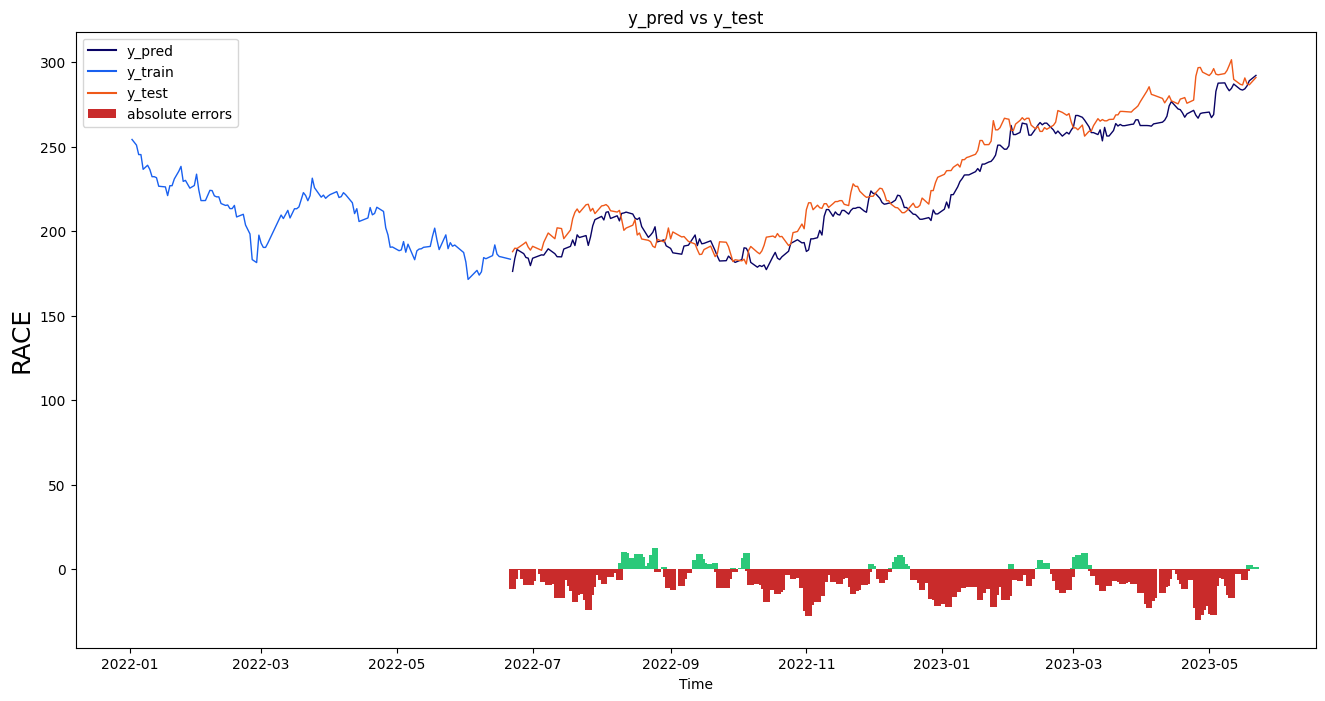

(3840, 9) (3840, 1)
(960, 9) (960, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0303
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 108.1163 %
Mean Quatratic Error (RMSE): 0.0403
Sin pct_change
Mean Absolute Error (MAE): 4.6267
Mean Absolute Percentage Error (MAPE): 3.0172 %
Median Absolute Percentage Error (MDAPE): 2.2775 %
Mean Quatratic Error (RMSE): 6.2126


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


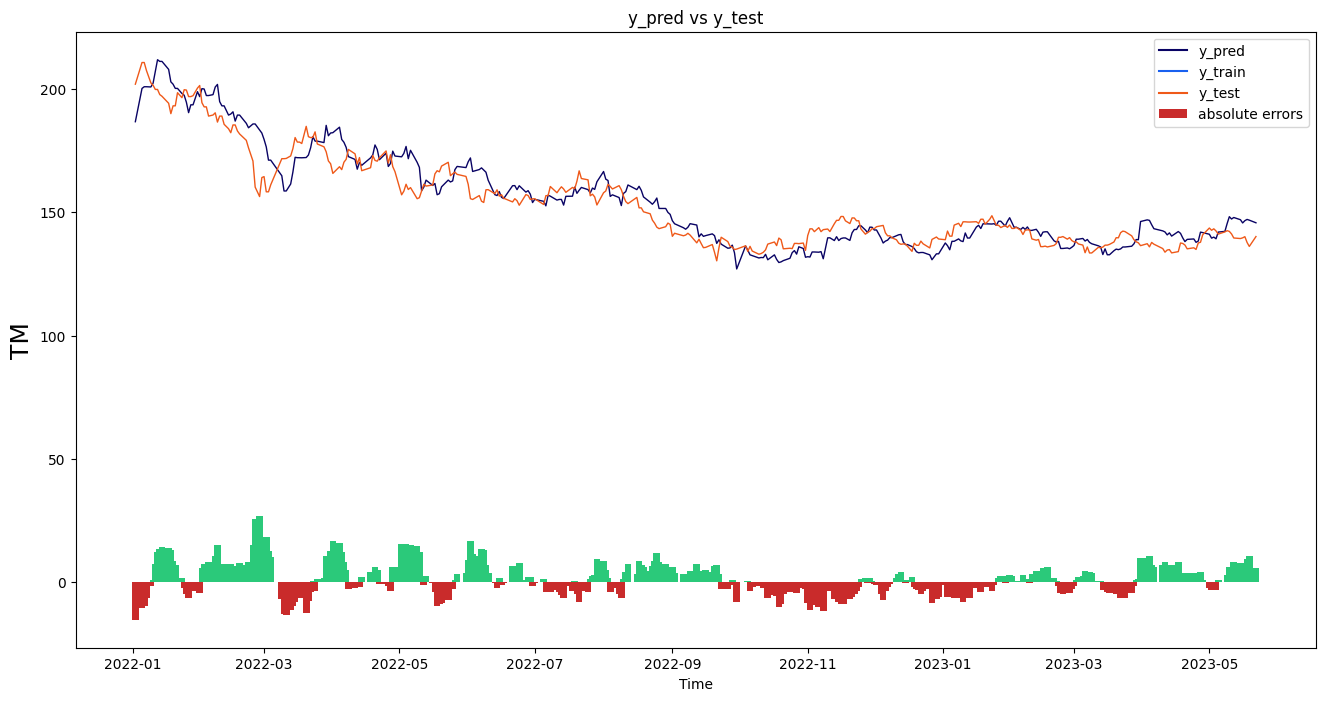

(4192, 33) (4192, 1)
(1047, 33) (1047, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0327
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 109.6035 %
Mean Quatratic Error (RMSE): 0.0433
Sin pct_change
Mean Absolute Error (MAE): 0.8727
Mean Absolute Percentage Error (MAPE): 3.2635 %
Median Absolute Percentage Error (MDAPE): 2.6013 %
Mean Quatratic Error (RMSE): 1.1409


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


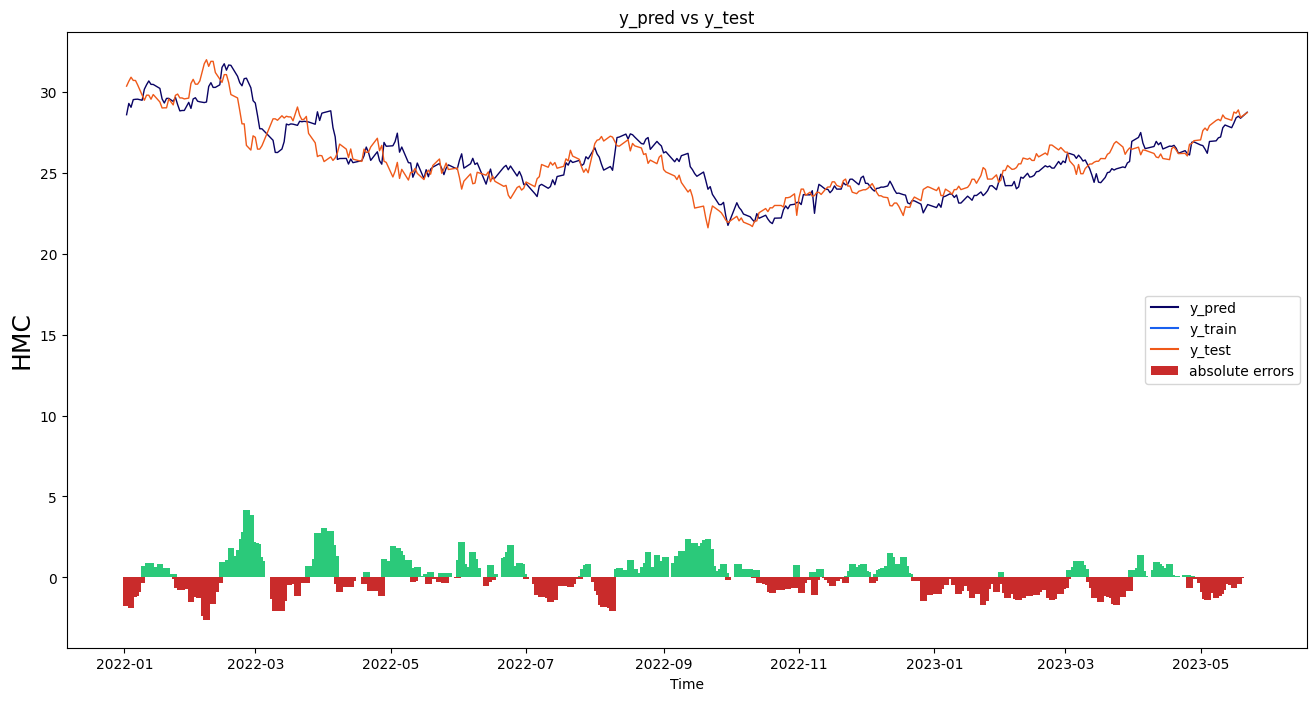

In [28]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(4744, 4) (4744, 1)
(1186, 4) (1186, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0538
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 107.3591 %
Mean Quatratic Error (RMSE): 0.0728
Sin pct_change
Mean Absolute Error (MAE): 0.6239
Mean Absolute Percentage Error (MAPE): 5.3525 %
Median Absolute Percentage Error (MDAPE): 3.9368 %
Mean Quatratic Error (RMSE): 0.9096


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


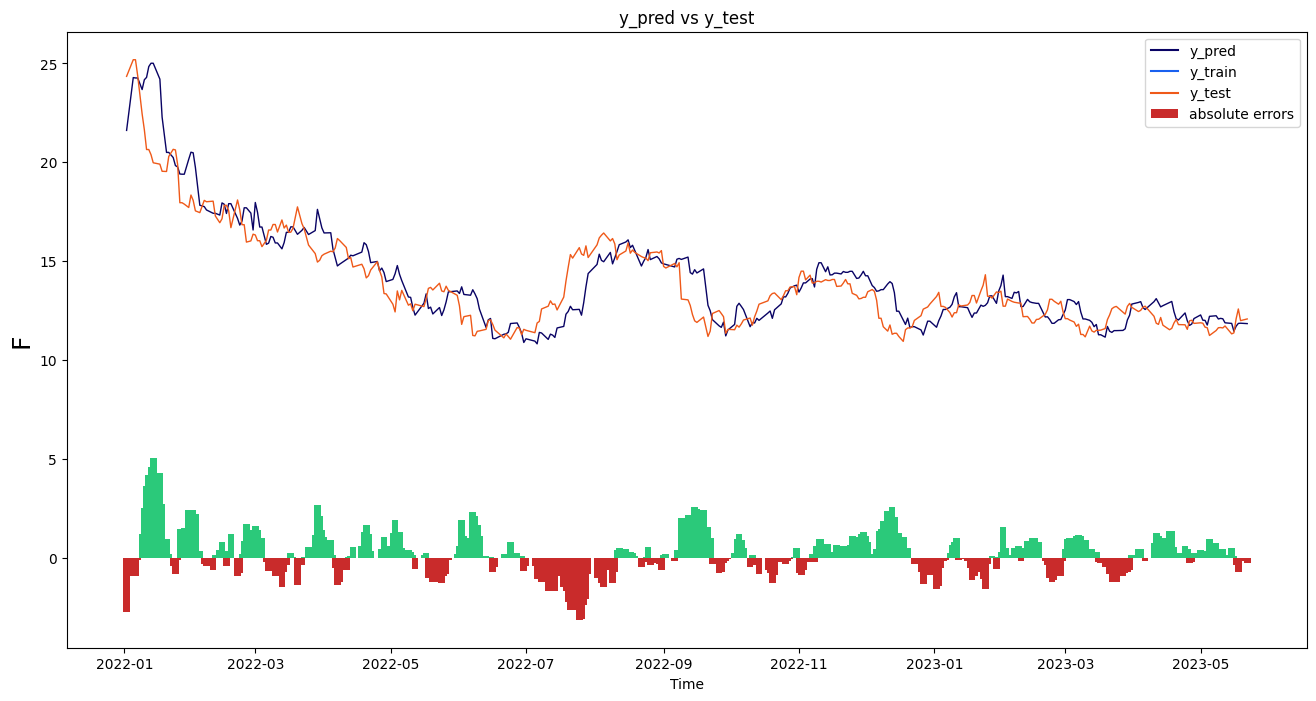

(2067, 10) (2067, 1)
(516, 10) (516, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0667
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 125.7336 %
Mean Quatratic Error (RMSE): 0.0865
Sin pct_change
Mean Absolute Error (MAE): 3.0554
Mean Absolute Percentage Error (MAPE): 6.9591 %
Median Absolute Percentage Error (MDAPE): 4.8806 %
Mean Quatratic Error (RMSE): 4.1449


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


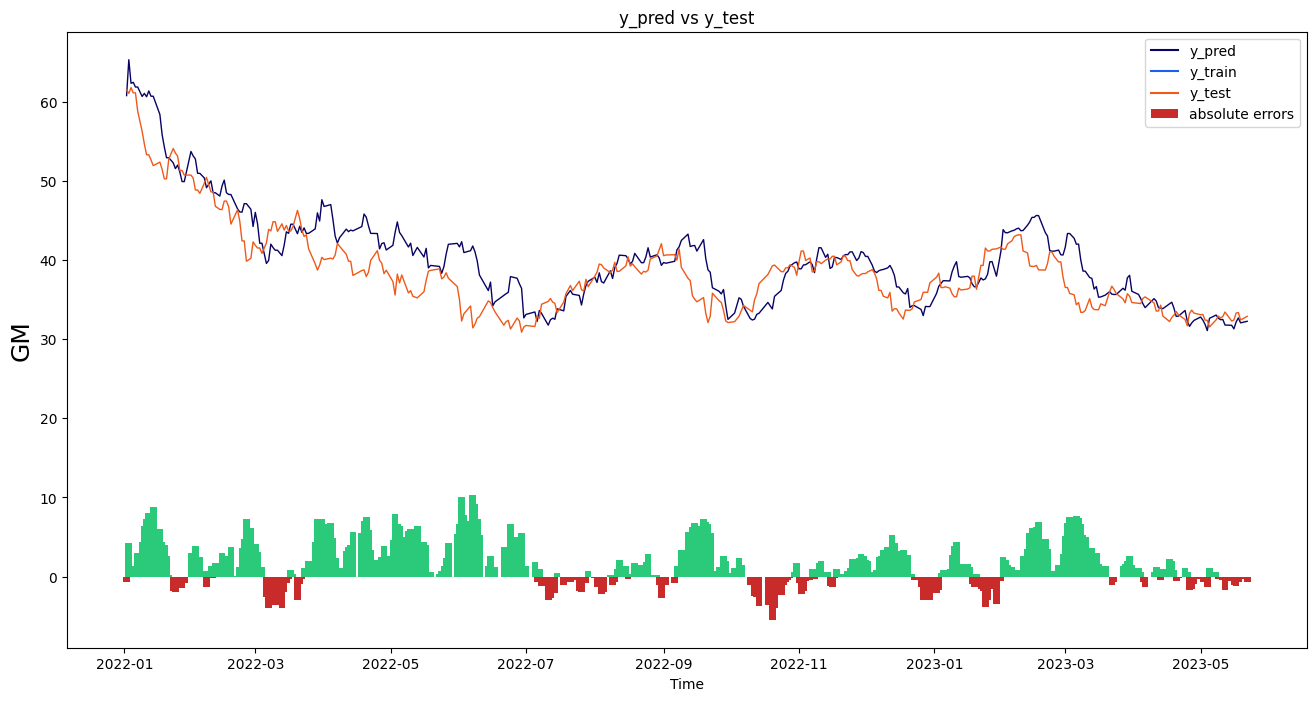

(2132, 16) (2132, 1)
(533, 16) (533, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0804
Mean Absolute Percentage Error (MAPE): 278.627 %
Median Absolute Percentage Error (MDAPE): 113.8803 %
Mean Quatratic Error (RMSE): 0.1016
Sin pct_change
Mean Absolute Error (MAE): 20.0862
Mean Absolute Percentage Error (MAPE): 8.183 %
Median Absolute Percentage Error (MDAPE): 6.6273 %
Mean Quatratic Error (RMSE): 26.0697


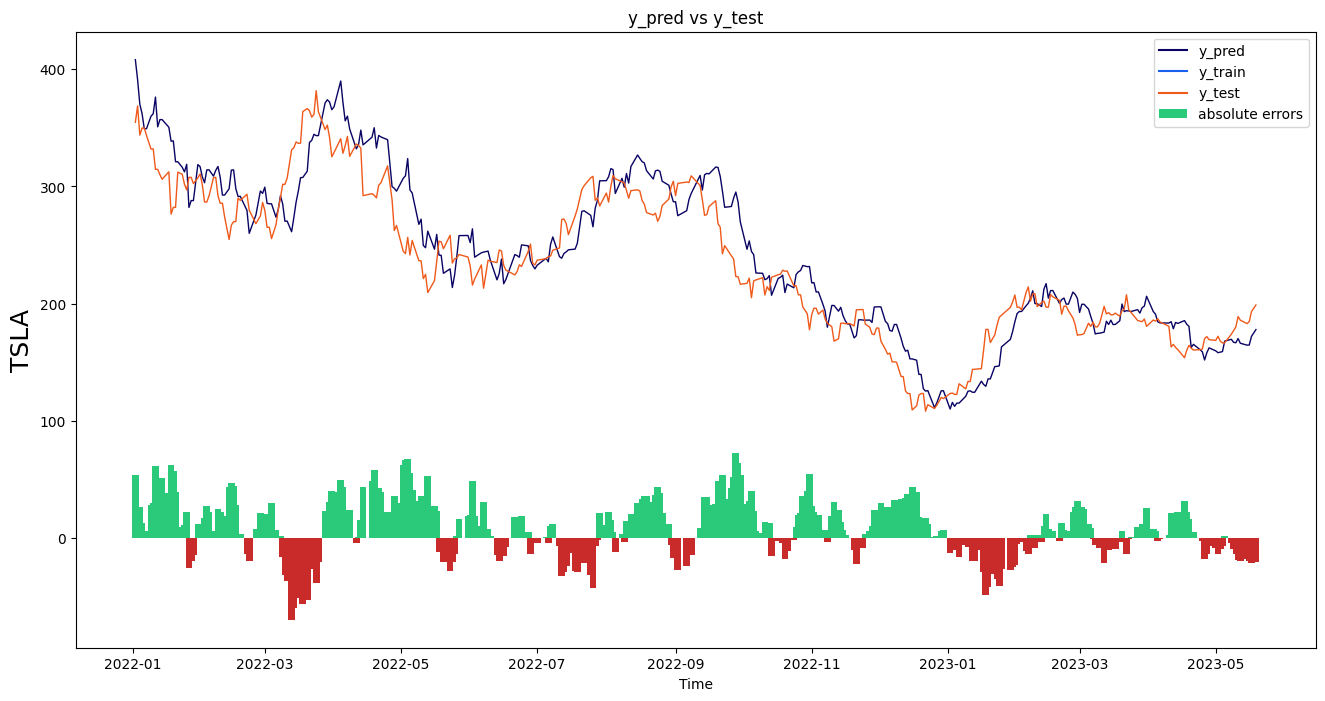

(978, 13) (978, 1)
(244, 13) (244, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0392
Mean Absolute Percentage Error (MAPE): 531.4707 %
Median Absolute Percentage Error (MDAPE): 135.7984 %
Mean Quatratic Error (RMSE): 0.0479
Sin pct_change
Mean Absolute Error (MAE): 8.8404
Mean Absolute Percentage Error (MAPE): 3.8035 %
Median Absolute Percentage Error (MDAPE): 3.4808 %
Mean Quatratic Error (RMSE): 10.747


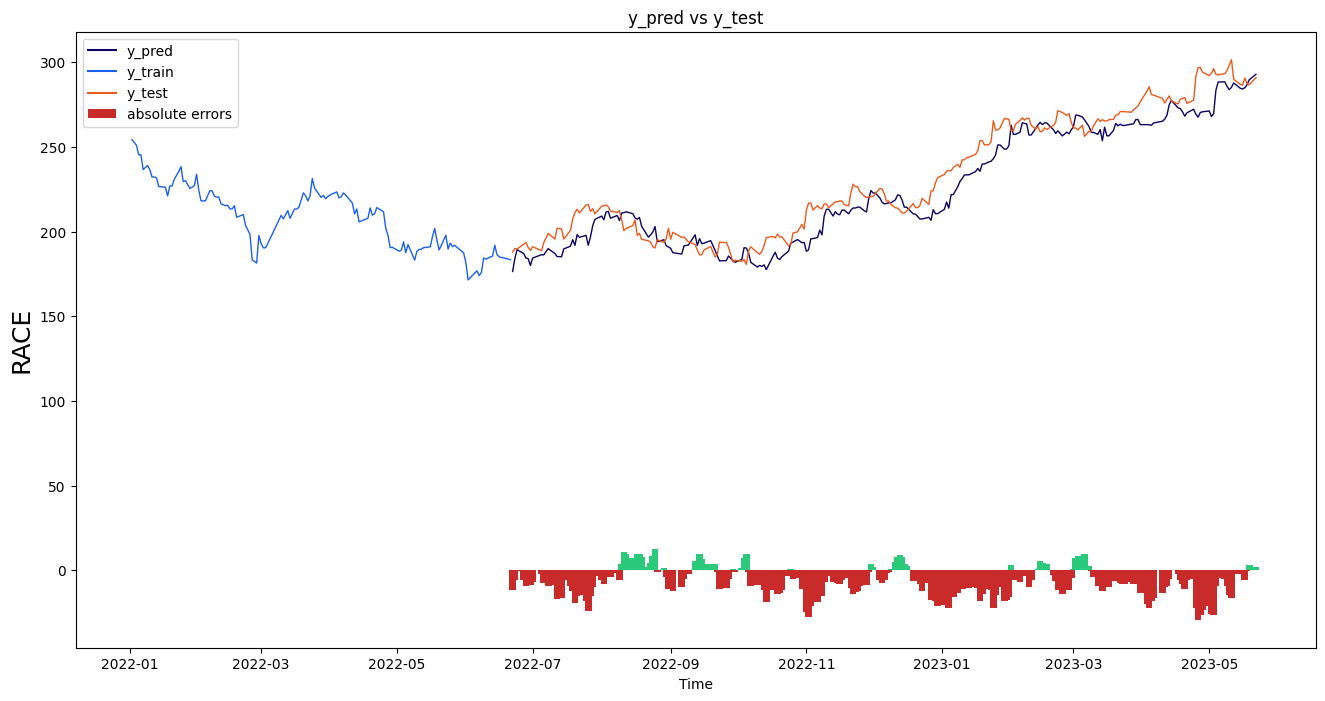

(3840, 9) (3840, 1)
(960, 9) (960, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0305
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 112.5248 %
Mean Quatratic Error (RMSE): 0.0406
Sin pct_change
Mean Absolute Error (MAE): 4.6616
Mean Absolute Percentage Error (MAPE): 3.0391 %
Median Absolute Percentage Error (MDAPE): 2.3365 %
Mean Quatratic Error (RMSE): 6.2616


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


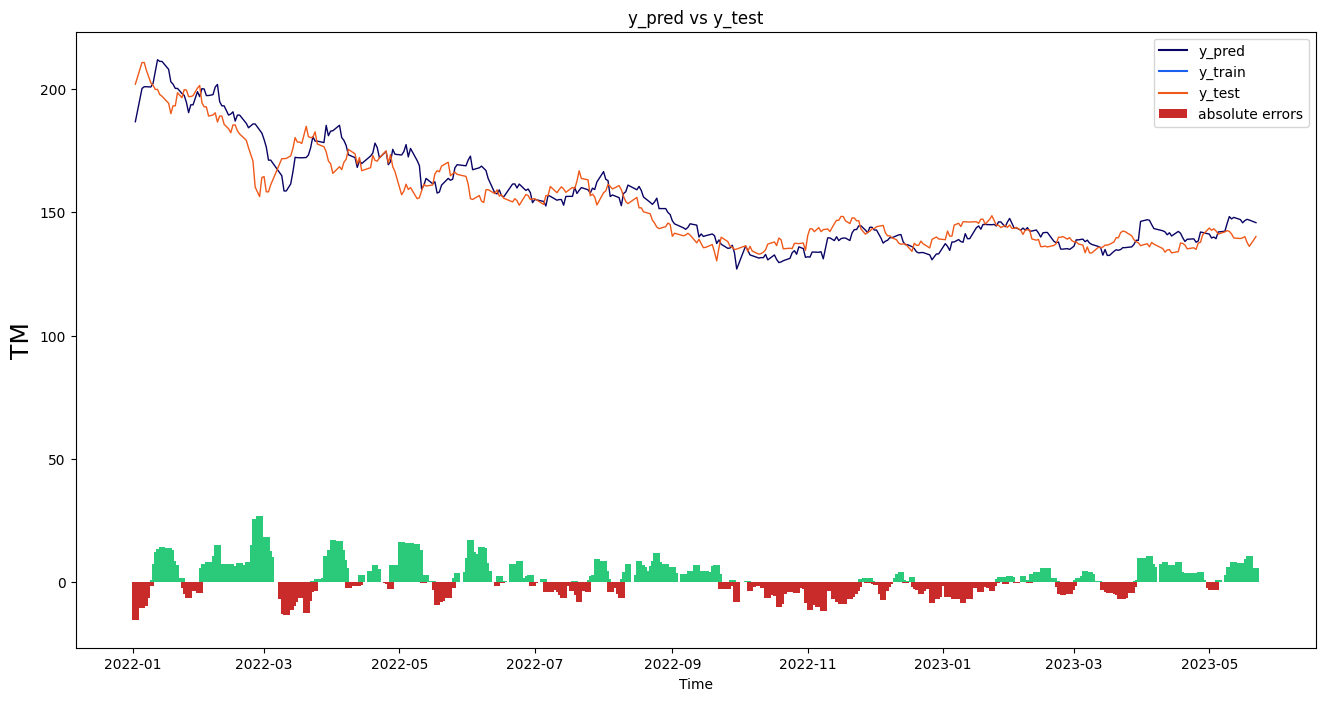

(4192, 33) (4192, 1)
(1047, 33) (1047, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0325
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 107.673 %
Mean Quatratic Error (RMSE): 0.0431
Sin pct_change
Mean Absolute Error (MAE): 0.8682
Mean Absolute Percentage Error (MAPE): 3.2452 %
Median Absolute Percentage Error (MDAPE): 2.591 %
Mean Quatratic Error (RMSE): 1.1382


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


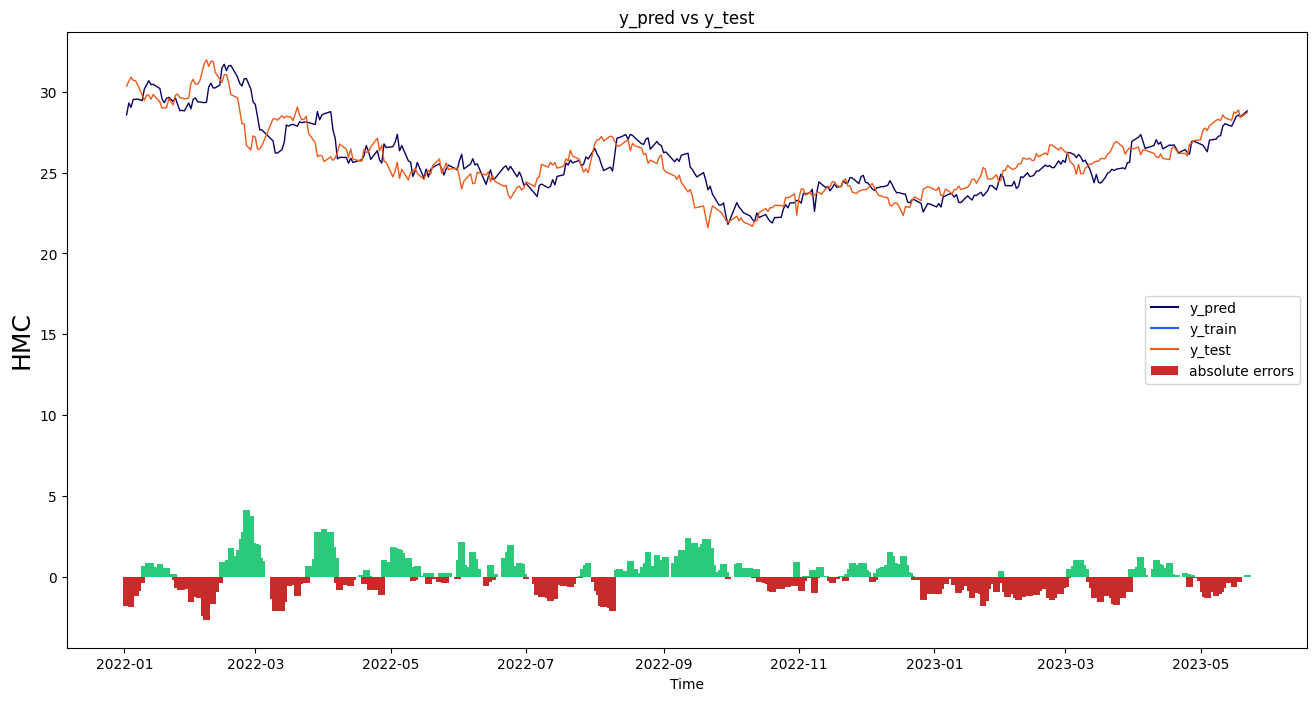

In [29]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

(4744, 4) (4744, 1)
(1186, 4) (1186, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0513
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.3236 %
Mean Quatratic Error (RMSE): 0.0691
Sin pct_change
Mean Absolute Error (MAE): 0.5967
Mean Absolute Percentage Error (MAPE): 5.1025 %
Median Absolute Percentage Error (MDAPE): 3.8466 %
Mean Quatratic Error (RMSE): 0.8677


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


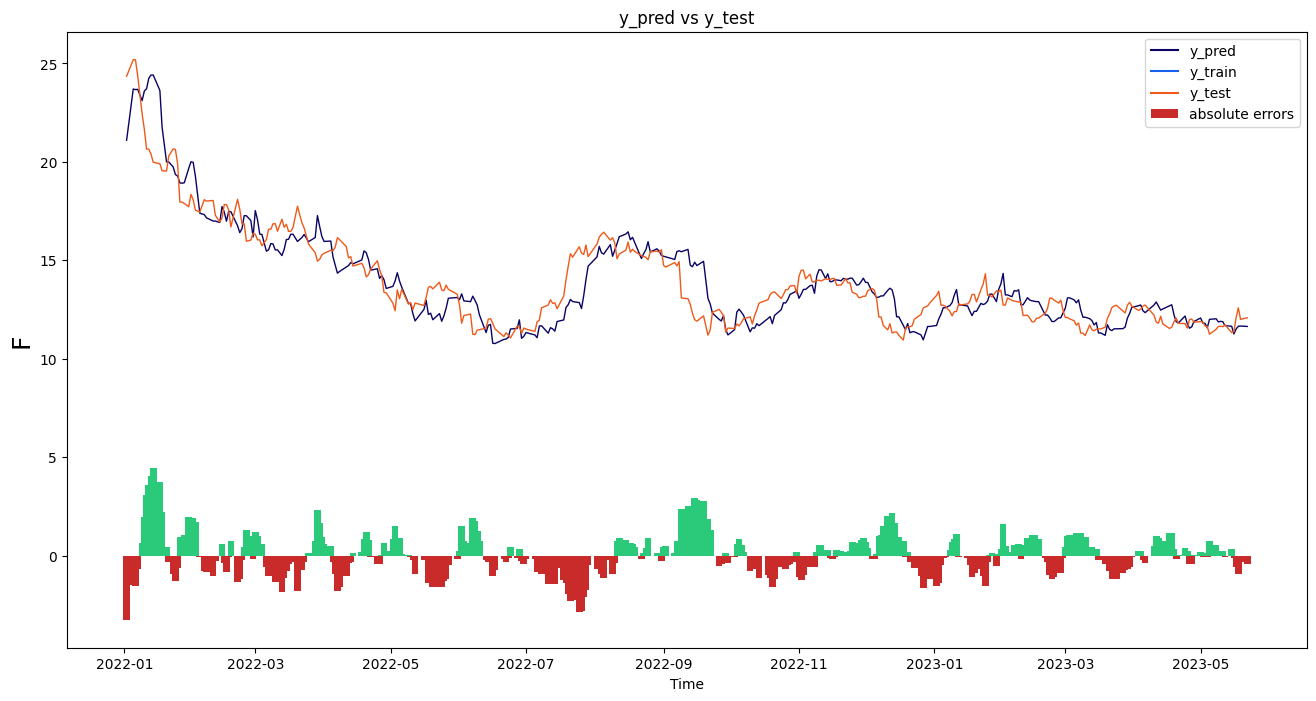

(2067, 9) (2067, 1)
(516, 9) (516, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0511
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 105.7136 %
Mean Quatratic Error (RMSE): 0.0645
Sin pct_change
Mean Absolute Error (MAE): 2.259
Mean Absolute Percentage Error (MAPE): 5.279 %
Median Absolute Percentage Error (MDAPE): 4.2885 %
Mean Quatratic Error (RMSE): 2.899


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


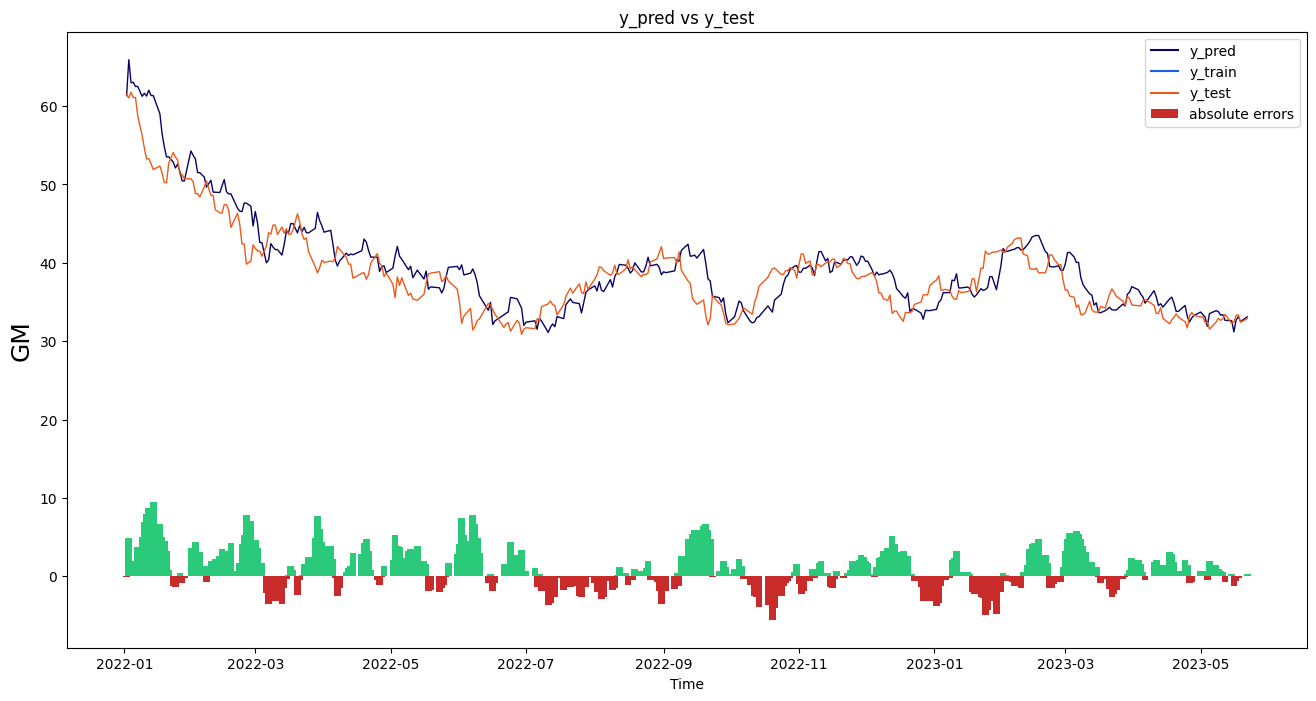

(2132, 5) (2132, 1)
(533, 5) (533, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0868
Mean Absolute Percentage Error (MAPE): 581.9234 %
Median Absolute Percentage Error (MDAPE): 106.9814 %
Mean Quatratic Error (RMSE): 0.1149
Sin pct_change
Mean Absolute Error (MAE): 21.9564
Mean Absolute Percentage Error (MAPE): 8.6281 %
Median Absolute Percentage Error (MDAPE): 6.6219 %
Mean Quatratic Error (RMSE): 30.5029


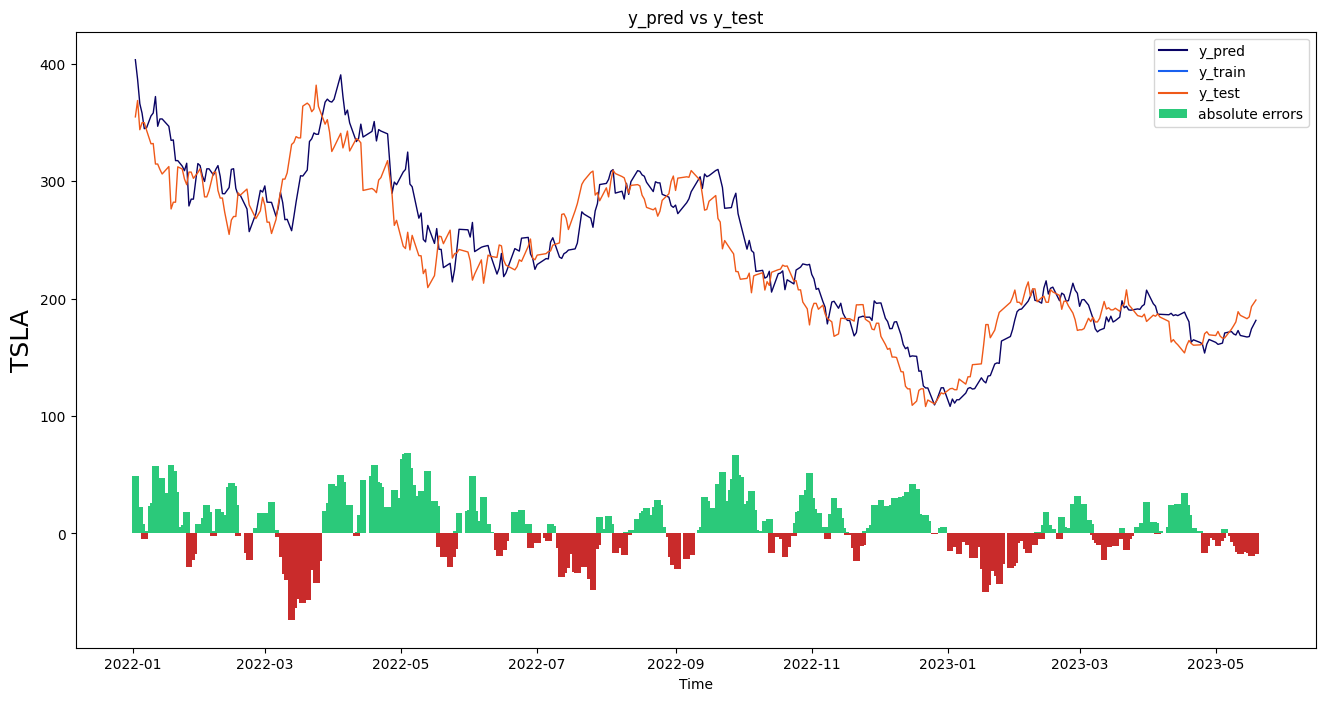

(978, 3) (978, 1)
(244, 3) (244, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0302
Mean Absolute Percentage Error (MAPE): 330.8054 %
Median Absolute Percentage Error (MDAPE): 80.0227 %
Mean Quatratic Error (RMSE): 0.0379
Sin pct_change
Mean Absolute Error (MAE): 6.809
Mean Absolute Percentage Error (MAPE): 2.9966 %
Median Absolute Percentage Error (MDAPE): 2.5719 %
Mean Quatratic Error (RMSE): 8.4543


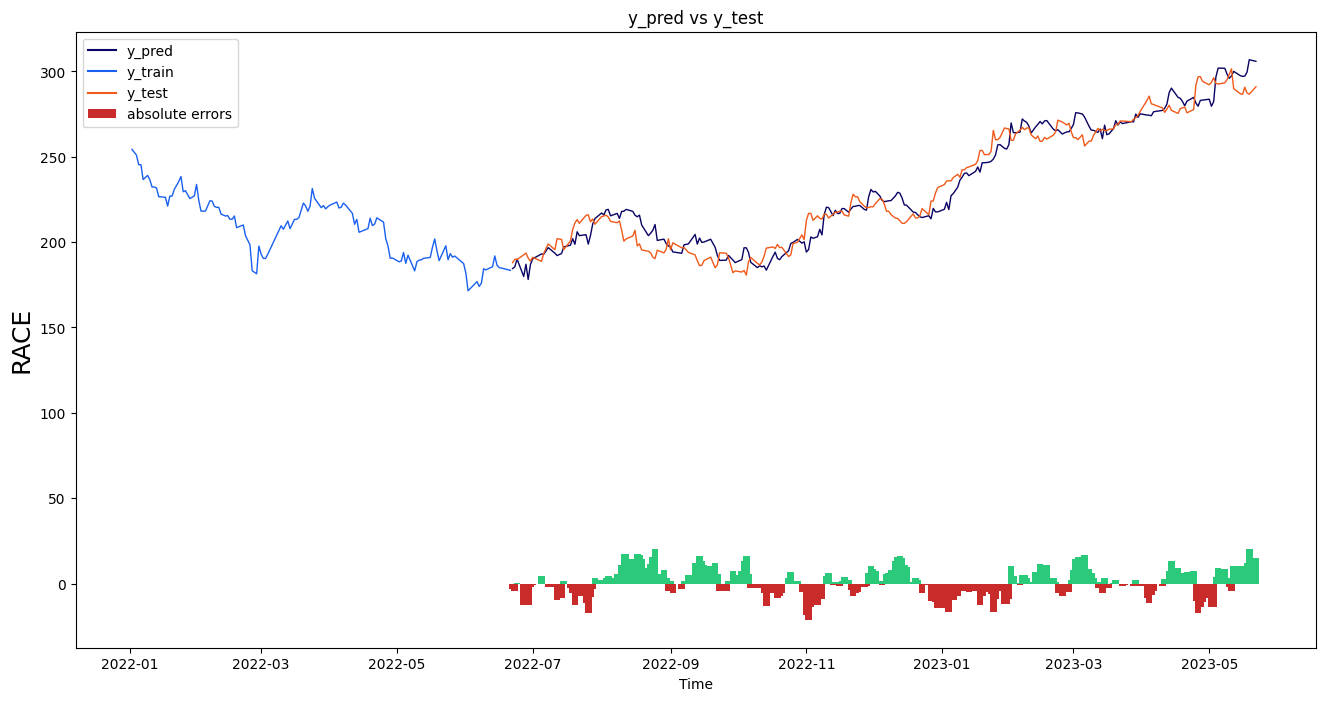

(3840, 2) (3840, 1)
(960, 2) (960, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0309
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 109.2734 %
Mean Quatratic Error (RMSE): 0.0401
Sin pct_change
Mean Absolute Error (MAE): 4.7468
Mean Absolute Percentage Error (MAPE): 3.0899 %
Median Absolute Percentage Error (MDAPE): 2.4944 %
Mean Quatratic Error (RMSE): 6.2168


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


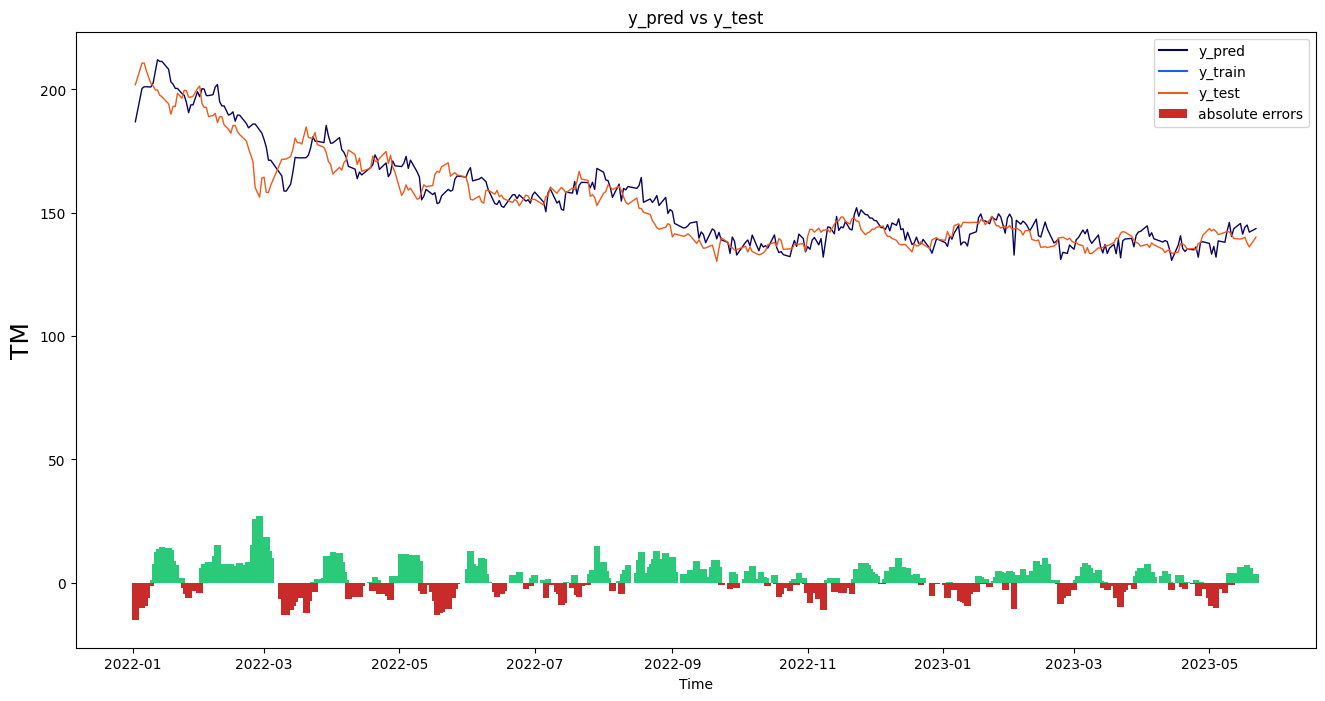

(4192, 3) (4192, 1)
(1047, 3) (1047, 1)


<ipython-input-27-c7bc617b5ce6>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


Con pct_change
Mean Absolute Error (MAE): 0.0345
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 108.4735 %
Mean Quatratic Error (RMSE): 0.0472
Sin pct_change
Mean Absolute Error (MAE): 0.9106
Mean Absolute Percentage Error (MAPE): 3.4054 %
Median Absolute Percentage Error (MDAPE): 2.6767 %
Mean Quatratic Error (RMSE): 1.2139


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


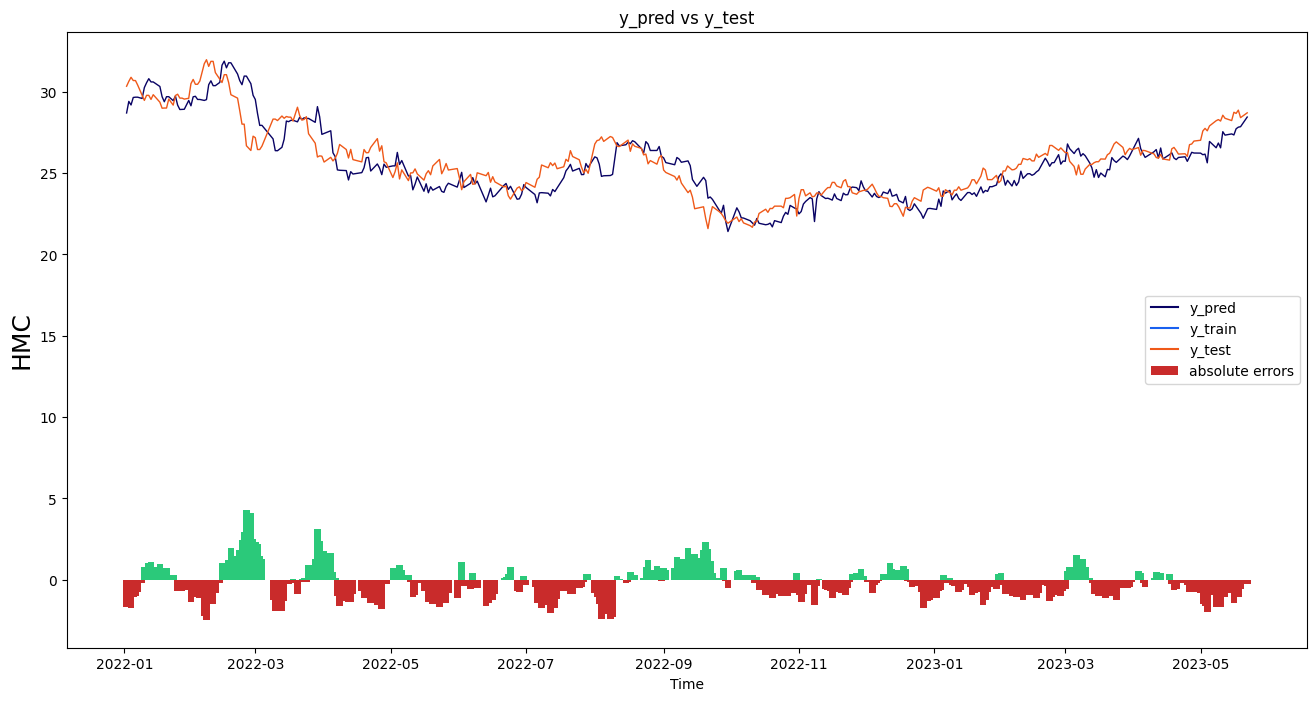

In [30]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.

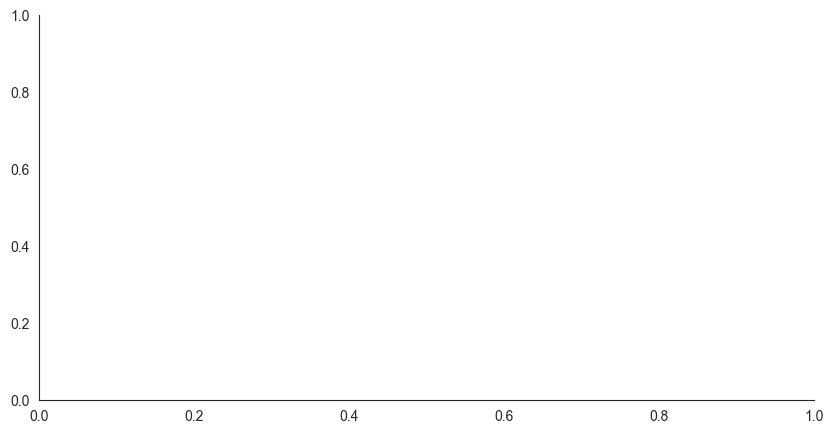

In [ ]:
y2 = y_test[:100]
y_pred2 = y_pred[:100]

x = range(len(y2))
fig, ax = plt.subplots(figsize=(10, 5))
ci = 1.96*RMSE
for i,v in enumerate(y_pred2):
    plt.plot([x[i],x[i]], [v,y2[i]],color="green")
#ax.fill_between(x, ( y_pred2-ci), ( y_pred2+ci), color='b', alpha=.1)
ax.scatter(x,y_pred2,color="red",s=8,label="predicho")
ax.scatter(x,y2,color="blue",s=8,label="real")
plt.legend()
plt.show()

# Hyperparameter Tunning

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,TimeSeriesSplit
from google.colab import files

In [ ]:
stationary_dataframes['F']

Open     Close      High       Low    Volume       MA1  \
Date                                                                     
1999-07-01  0.074766  0.037562  0.023033  0.058449 -0.164224 -0.001857   
1999-07-02  0.018435 -0.019126 -0.001194  0.015575 -0.451210 -0.002236   
1999-07-06 -0.018101  0.004352 -0.001025  0.001046 -0.183130 -0.002087   
1999-07-07  0.001043 -0.003293 -0.004274 -0.006616 -0.083668 -0.002280   
1999-07-08 -0.002085 -0.017391 -0.013906 -0.016299  0.313135 -0.002611   
...              ...       ...       ...       ...       ...       ...   
2023-05-16 -0.012821 -0.033505 -0.011945 -0.030198  0.137564 -0.002818   
2023-05-17 -0.017316  0.022222  0.005181  0.007117 -0.172477 -0.002244   
2023-05-18  0.009692  0.012174  0.001718  0.011484 -0.237553 -0.002249   
2023-05-19  0.017452  0.000859  0.009434  0.007860  0.138622 -0.001336   
2023-05-22  0.004288 -0.001717 -0.003398 -0.014731  0.320718 -0.000752   

                 MA2  Cash & Equivalents  Short-Term Investments  \
Date                                                               
1999-07-01  0.000992             0.22622               -0.042296   
1999-07-02  0.000955             0.22622               -0.042296   
1999-07-06  0.001096             0.22622               -0.042296   
1999-07-07  0.001112             0.22622               -0.042296   
1999-07-08  0.000935             0.22622               -0.042296   
...              ...                 ...                     ...   
2023-05-16 -0.001300             0.00000                0.000000   
2023-05-17 -0.001455             0.00000                0.000000   
2023-05-18 -0.001380             0.00000                0.000000   
2023-05-19 -0.001536             0.00000                0.000000   
2023-05-22 -0.001461             0.00000                0.000000   

            Cash & Cash Equivalents  ...     EMA50      MACD       ADX  \
Date                                 ...                                 
1999-07-01                 0.009737  ...  0.001021 -0.376589 -0.042467   
1999-07-02                 0.009737  ...  0.000211 -0.351215 -0.041183   
1999-07-06                 0.009737  ...  0.000374 -0.481443 -0.039884   
1999-07-07                 0.009737  ...  0.000229 -0.671500 -0.049418   
1999-07-08                 0.009737  ... -0.000466 -0.534716 -0.068508   
...                             ...  ...       ...       ...       ...   
2023-05-16                 0.000000  ... -0.002692  0.334020  0.059450   
2023-05-17                 0.000000  ... -0.001780  0.053313  0.037106   
2023-05-18                 0.000000  ... -0.001257 -0.041633  0.028216   
2023-05-19                 0.000000  ... -0.001176 -0.050641 -0.001582   
2023-05-22                 0.000000  ... -0.001197 -0.042214  0.026511   

                 CMF         SO  LBOLLINGER  HBOLLINGER        FI    Target  \
Date                                                                          
1999-07-01 -0.367238  98.833333   -0.005897    0.008758  0.512772 -0.086407   
1999-07-02  0.319225  80.166667   -0.001876    0.003646 -0.268510 -0.078343   
1999-07-06  0.104229  84.175084   -0.001435    0.002476 -0.111536 -0.072630   
1999-07-07 -0.140005  80.976431   -0.001767    0.004158 -0.167408 -0.059826   
1999-07-08 -0.047979  64.141414   -0.000020    0.002161 -0.346650 -0.045310   
...              ...        ...         ...         ...       ...       ...   
2023-05-16  1.821720   0.952381    0.000969   -0.012806  1.498242  0.011556   
2023-05-17 -0.482207  24.761905   -0.001270   -0.004695 -0.491319  0.051304   
2023-05-18  0.430013  38.095238   -0.001168   -0.000798 -0.435345  0.081615   
2023-05-19  0.117432  48.235294   -0.000914   -0.000462 -0.184986  0.030043   
2023-05-22  0.258670  45.882353    0.001118   -0.005389 -0.006320  0.039123   

            Nominal_Close  
Date                       
1999-07-01          58.56  
1999-07-02          57.44  
1999-07-06          57.69  
1999-07-07          57.50  
1999-07-0

In [ ]:

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.0, 0.1, 0.3, 0.6, 0.9]
neurons = [20, 25, 30, 40, 50, 60]
activation = ['sigmoid', 'tanh', 'relu', 'leaky_relu']

for brand in ['HMC']:
  np_data, np_target_scaled, scaler_pred = feature_scaling_and_selection(stationary_dataframes[brand], brand, stationary = True)
  X_train, x_test, Y_train, y_test = train_test_split(np_data, np_target_scaled, for_LSTM = True,train_perc = 0.8, sequence_length=50)

  param_grid2 = dict(optimizer=optimizer, dropout_rate=dropout_rate, neurons=neurons, x_train = [X_train], activation = activation)

  # envoltura de scikit-learn para el modelo keras
  model_stationary = KerasRegressor(build_fn=model_LSTM, verbose=0)




  # búsqueda de random

  grid_stat = RandomizedSearchCV(estimator=model_stationary, param_distributions=param_grid2, n_iter = 500, n_jobs=-1, cv=3)
  grid_stat.fit(X_train, Y_train)
  print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))
  resultados = pd.DataFrame(grid_stat.cv_results_)
  resultados = resultados.sort_values('rank_test_score')
  resultados.to_excel(f'{brand}-Resultados_Parameters_hypertunning.xlsx', encoding = 'utf-8-sig')
  files.download(f'{brand}-Resultados_Parameters_hypertunning.xlsx')


0.3497709558583013
[-1.15455771]
(4451, 50, 98) (4451, 1)
(1125, 50, 98) (1125, 1)


<ipython-input-40-03310965c75c>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_stationary = KerasRegressor(build_fn=model_LSTM, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor: -0.756191 usando {'x_train': array([[[-9.54370751e-01, -1.36176038e+00, -1.11693650e+00, ...,
         -5.98531361e-01, -8.07339573e-01, -1.34261072e+00],
        [-1.29075980e+00, -6.80208363e-01, -8.43619159e-01, ...,
         -1.11627684e+00, -1.79583195e-01, -7.54181458e+01],
        [-1.64493170e-01,  3.12503709e-01,  6.57112419e-01, ...,
         -5.14600711e-01, -9.88364734e-01, -5.11297061e-01],
        ...,
        [-3.46503595e-01, -1.78781192e+00, -7.83795673e-01, ...,
         -2.50668175e+00, -2.77379825e-01,  8.28235315e-01],
        [ 4.11619060e-01,  2.23761627e+00,  1.26873717e+00, ...,
         -9.27349608e-01, -3.15422464e-01, -1.16324288e+00],
        [-6.92360427e-01, -1.21432902e+00, -4.98174484e-01, ...,
         -1.59100553e+00, -2.05255793e-02,  1.89084731e+00]],

       [[-1.29075980e+00, -6.80208363e-01, -8.43619159e-01, ...,
         -1.11627684e+00, -1.79583195e-01, -7.54181458e+01],
        [-1.64493170e-01,  3.12503709e-01,  6.57112419e-01, ...,
  

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
brands[]

['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC']

In [ ]:
resultados = pd.DataFrame(grid_stat.cv_results_)
resultados = resultados.sort_values('rank_test_score')
resultados.to_excel('Resultados_Parameters_hypertunning.xlsx', encoding = 'utf-8-sig')
files.download('Resultados_Parameters_hypertunning.xlsx')

In [ ]:
print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))
#print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
Con pct_change
r2: -72068837.61297743
Mean Absolute Error (MAE): 229.2469
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.3924 %
Mean Quatratic Error (RMSE): 584.3298
Sin pct_change
r2: -4072716.273513006
Mean Absolute Error (MAE): 2983.0807
Mean Absolute Percentage Error (MAPE): 23294.4223 %
Median Absolute Percentage Error (MDAPE): 4.7477 %
Mean Quatratic Error (RMSE): 7645.0581


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


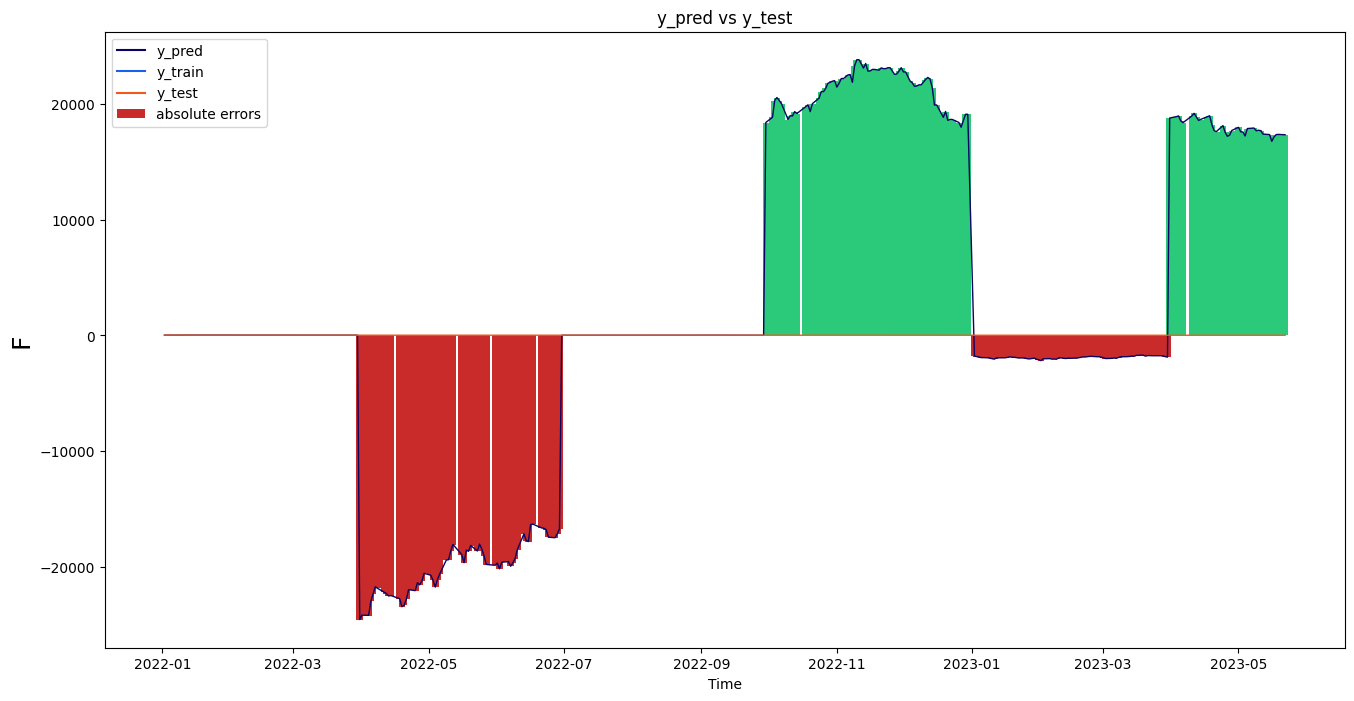

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 10) (2067, 1)
(516, 10) (516, 1)
Con pct_change
r2: -8.239861920192816
Mean Absolute Error (MAE): 0.1336
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 123.0143 %
Mean Quatratic Error (RMSE): 0.1882
Sin pct_change
r2: -0.16912484167640818
Mean Absolute Error (MAE): 6.8178
Mean Absolute Percentage Error (MAPE): 13.4454 %
Median Absolute Percentage Error (MDAPE): 7.7405 %
Mean Quatratic Error (RMSE): 10.3221


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


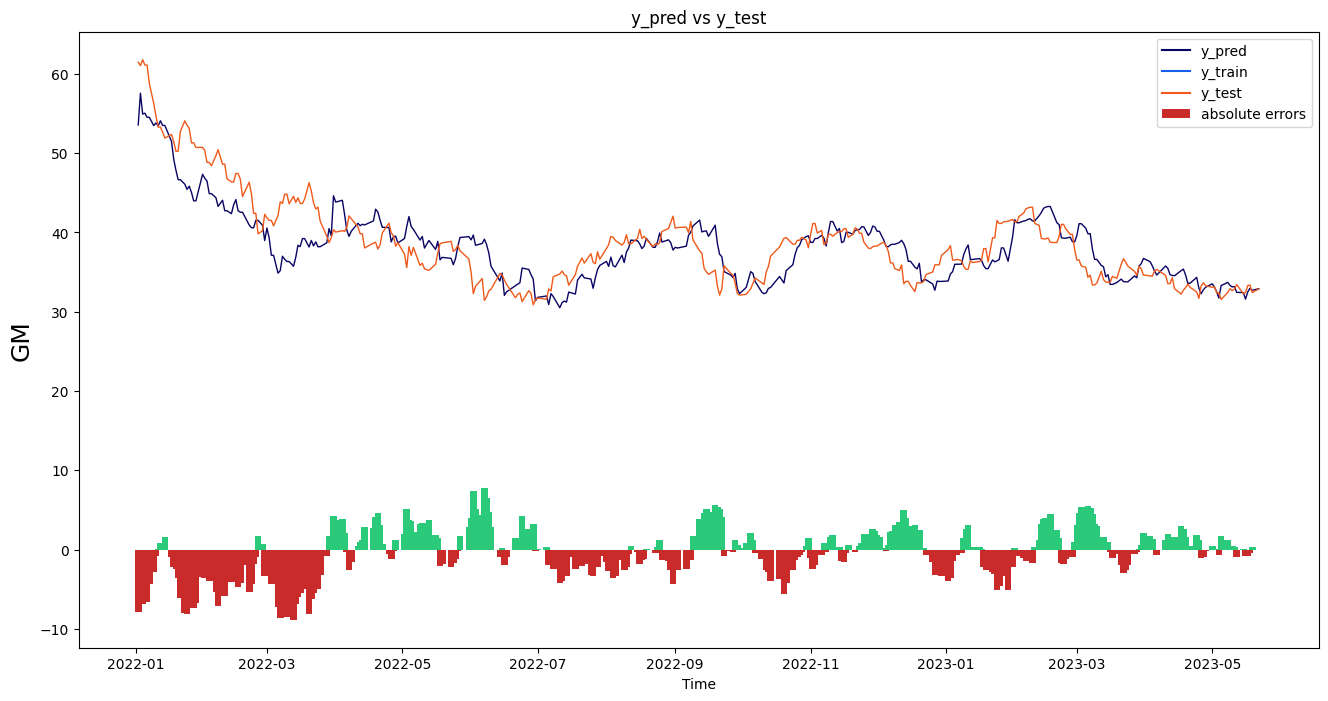

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 16) (2132, 1)
(533, 16) (533, 1)
Con pct_change
r2: -0.13203922705866855
Mean Absolute Error (MAE): 0.0816
Mean Absolute Percentage Error (MAPE): 269.0281 %
Median Absolute Percentage Error (MDAPE): 115.676 %
Mean Quatratic Error (RMSE): 0.105
Sin pct_change
r2: 0.830455243491383
Mean Absolute Error (MAE): 20.6651
Mean Absolute Percentage Error (MAPE): 8.3918 %
Median Absolute Percentage Error (MDAPE): 6.4921 %
Mean Quatratic Error (RMSE): 27.5013


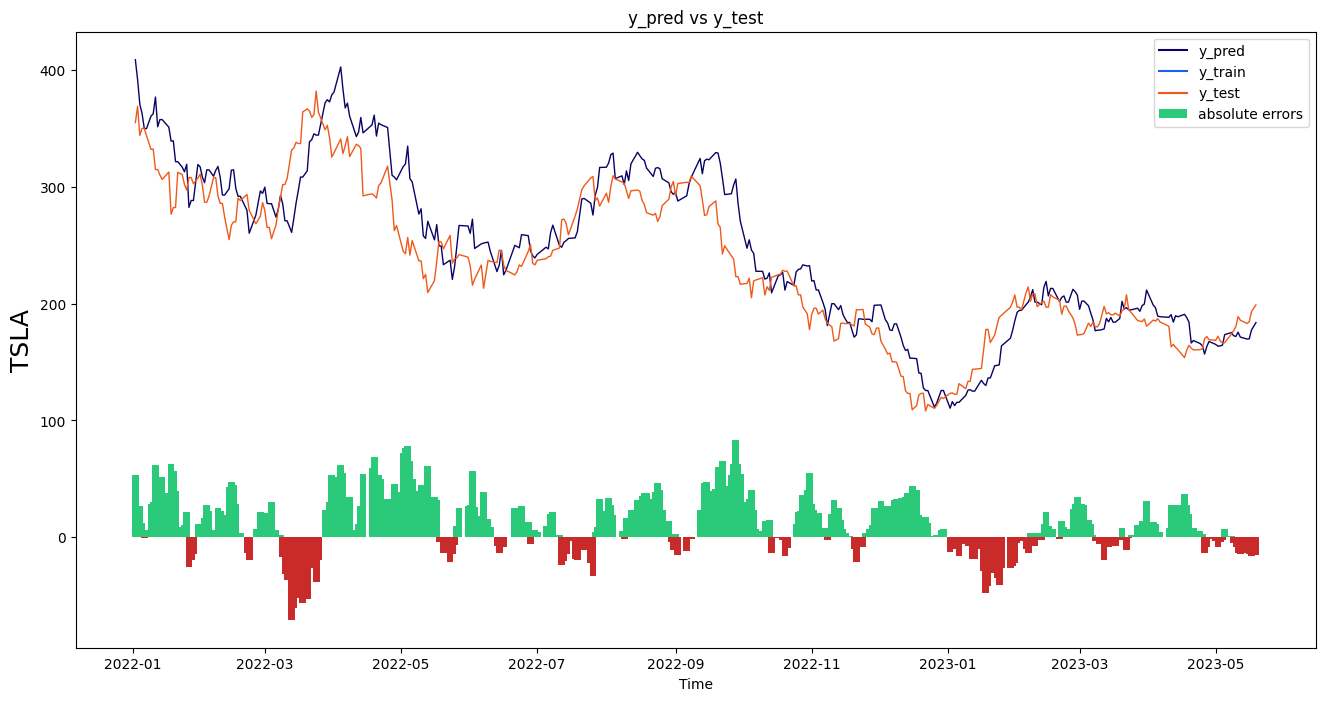

----------------------------------------------------- RACE ----------------------------------------------------------------------------------------
(978, 13) (978, 1)
(244, 13) (244, 1)
Con pct_change
r2: -93.02808370034018
Mean Absolute Error (MAE): 0.3348
Mean Absolute Percentage Error (MAPE): 4586.8686 %
Median Absolute Percentage Error (MDAPE): 1148.38 %
Mean Quatratic Error (RMSE): 0.3618
Sin pct_change
r2: -4.392676327827277
Mean Absolute Error (MAE): 75.1144
Mean Absolute Percentage Error (MAPE): 33.0629 %
Median Absolute Percentage Error (MDAPE): 34.2124 %
Mean Quatratic Error (RMSE): 80.564


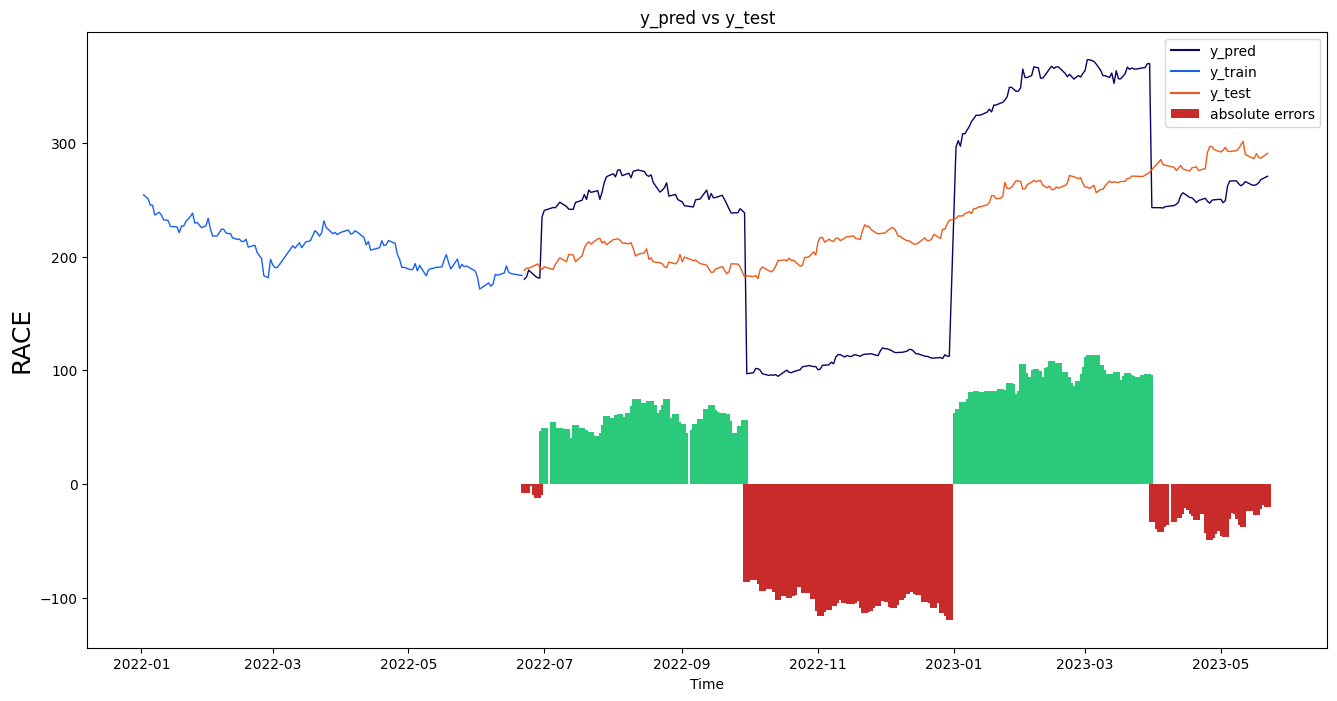

----------------------------------------------------- TM ----------------------------------------------------------------------------------------
(3840, 9) (3840, 1)
(960, 9) (960, 1)
Con pct_change
r2: 0.0017475615478190765
Mean Absolute Error (MAE): 0.0278
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 99.2043 %
Mean Quatratic Error (RMSE): 0.0366
Sin pct_change
r2: 0.9191673350270856
Mean Absolute Error (MAE): 4.2748
Mean Absolute Percentage Error (MAPE): 2.7841 %
Median Absolute Percentage Error (MDAPE): 2.1732 %
Mean Quatratic Error (RMSE): 5.7337


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


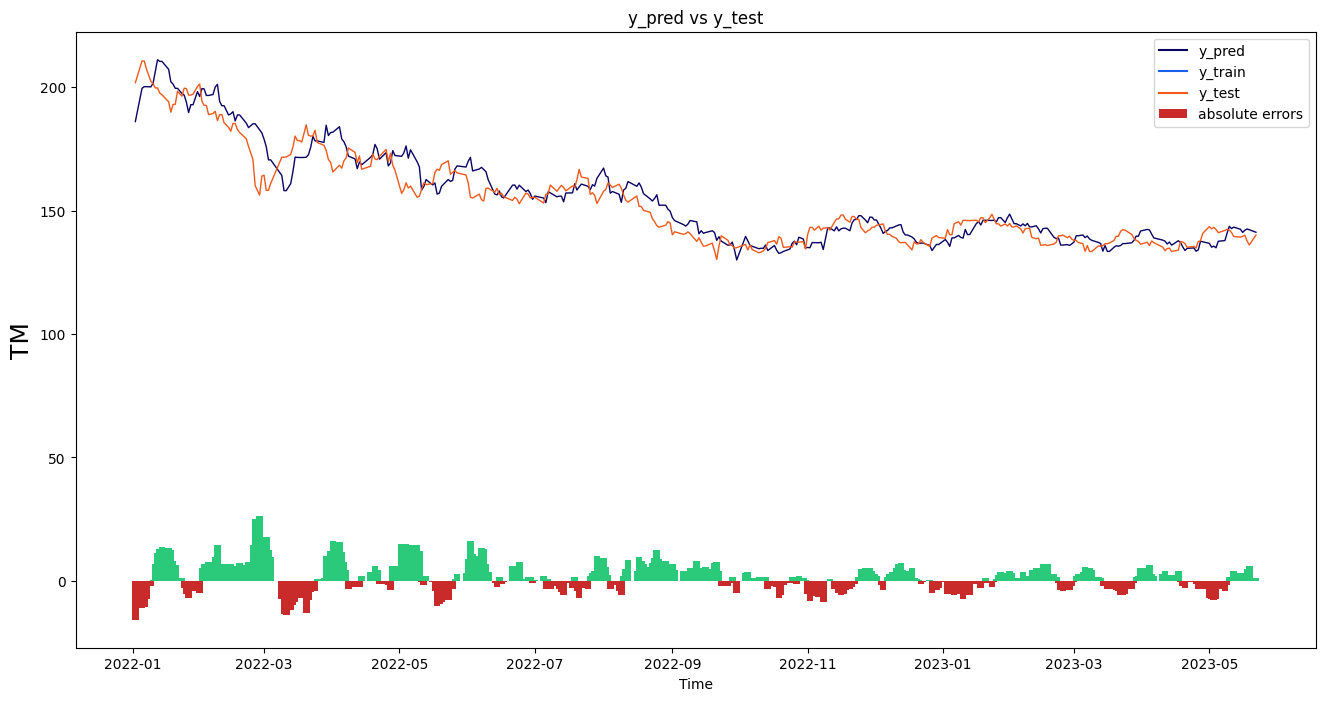

----------------------------------------------------- HMC ----------------------------------------------------------------------------------------
(4192, 33) (4192, 1)
(1047, 33) (1047, 1)
Con pct_change
r2: -0.18636927058476238
Mean Absolute Error (MAE): 0.034
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 104.5491 %
Mean Quatratic Error (RMSE): 0.0449
Sin pct_change
r2: 0.8058944779793858
Mean Absolute Error (MAE): 0.9089
Mean Absolute Percentage Error (MAPE): 3.4059 %
Median Absolute Percentage Error (MDAPE): 2.6573 %
Mean Quatratic Error (RMSE): 1.1888


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


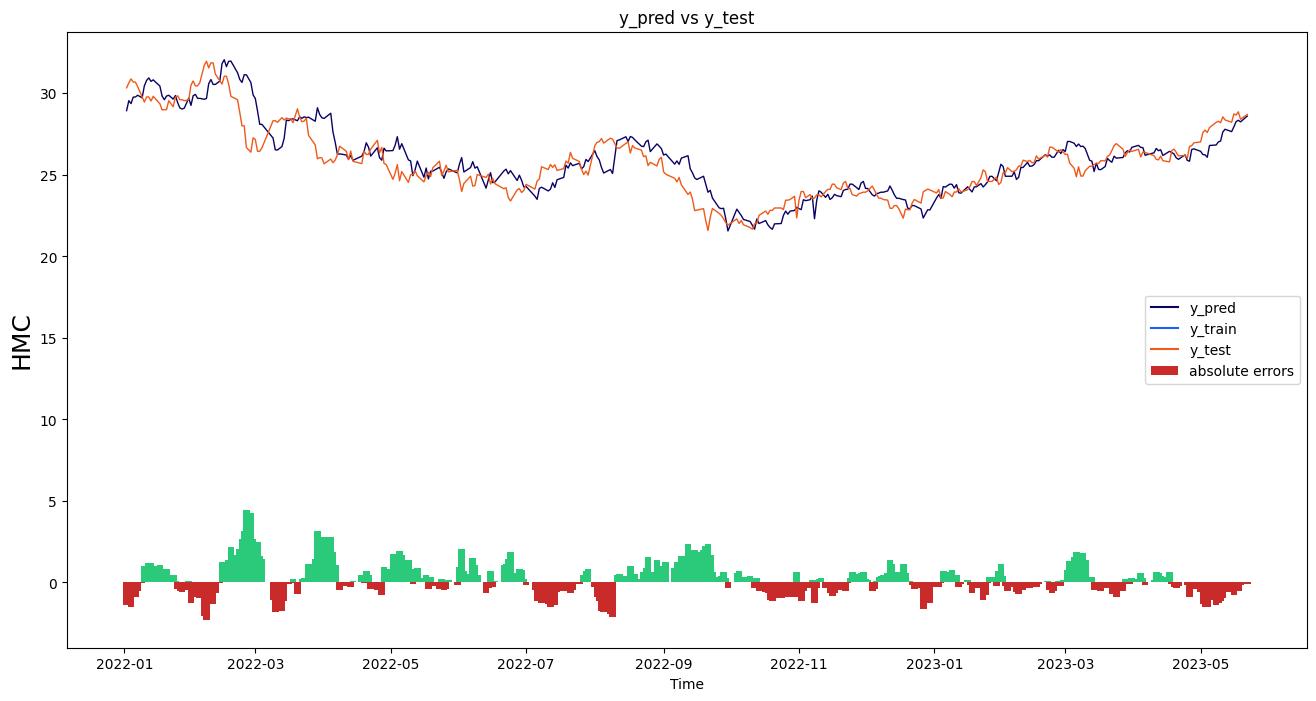

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

def linear_regression_model(df, brand, stationary = True, lagged = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01" ):
    np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

    X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

    linear_reg = LinearRegression()
    modelo = linear_reg.fit(X_train, y_train.ravel())

    y_pred = modelo.predict(X_test)
    # Convert the arrays back to the original scale
    y_test = scaler_pred.inverse_transform(y_test)
    y_pred = scaler_pred.inverse_transform(y_pred.reshape(-1,1))
    print('Con pct_change')
    r2 = r2_score(y_test,y_pred)
    print('r2:', r2)
    MAE, MAPE, MDAPE, RMSE = errors(y_test, y_pred)
    df_union = results_df(df, brand, train_perc, stationary, y_pred)
    print('Sin pct_change')
    r2 = r2_score(df_union['y_test'].dropna(), df_union['y_pred'].dropna())
    print('r2:', r2)

    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())

    df_union_zoom = df_union[df_union.index > display_start_date]
    # Plot the actual values
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(brand, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    plt.xlabel('Time')
    plt.ylabel(brand)
    plt.legend()
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()

    plt.show()

for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
Con pct_change
Mean Absolute Error (MAE): 229.2469
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.3924 %
Mean Quatratic Error (RMSE): 584.3298
Sin pct_change
Mean Absolute Error (MAE): 2983.0807
Mean Absolute Percentage Error (MAPE): 23294.4223 %
Median Absolute Percentage Error (MDAPE): 4.7477 %
Mean Quatratic Error (RMSE): 7645.0581


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


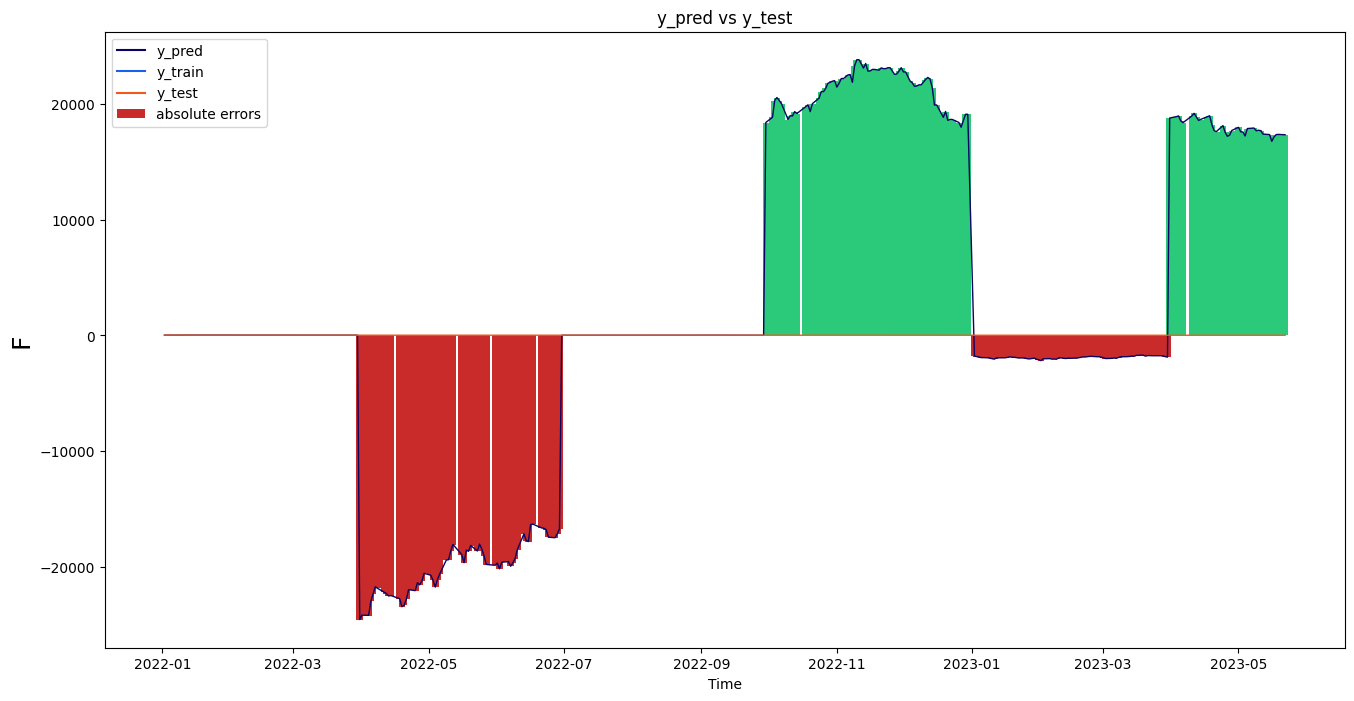

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 10) (2067, 1)
(516, 10) (516, 1)
Con pct_change
Mean Absolute Error (MAE): 0.1336
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 123.0143 %
Mean Quatratic Error (RMSE): 0.1882
Sin pct_change
Mean Absolute Error (MAE): 6.8178
Mean Absolute Percentage Error (MAPE): 13.4454 %
Median Absolute Percentage Error (MDAPE): 7.7405 %
Mean Quatratic Error (RMSE): 10.3221


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


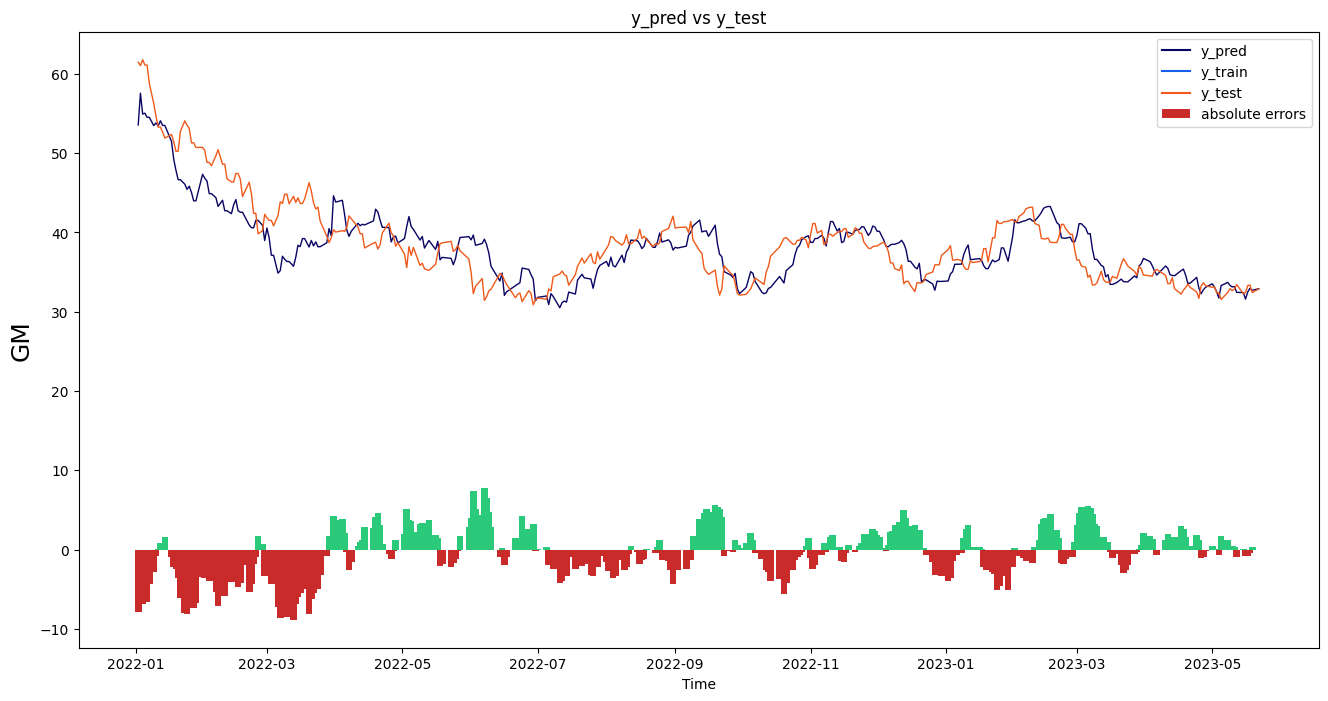

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 16) (2132, 1)
(533, 16) (533, 1)
Con pct_change
Mean Absolute Error (MAE): 0.0816
Mean Absolute Percentage Error (MAPE): 269.0281 %
Median Absolute Percentage Error (MDAPE): 115.676 %
Mean Quatratic Error (RMSE): 0.105
Sin pct_change
Mean Absolute Error (MAE): 20.6651
Mean Absolute Percentage Error (MAPE): 8.3918 %
Median Absolute Percentage Error (MDAPE): 6.4921 %
Mean Quatratic Error (RMSE): 27.5013


KeyboardInterrupt: ignored

In [38]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8 )

----------------------------------------------------- F ----------------------------------------------------------------------------------------
(4744, 4) (4744, 1)
(1186, 4) (1186, 1)
Con pct_change
r2: -0.011251365069442576
Mean Absolute Error (MAE): 0.0504
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 100.2913 %
Mean Quatratic Error (RMSE): 0.0692
Sin pct_change
r2: 0.9468744424237299
Mean Absolute Error (MAE): 0.5855
Mean Absolute Percentage Error (MAPE): 5.0196 %
Median Absolute Percentage Error (MDAPE): 3.5502 %
Mean Quatratic Error (RMSE): 0.8732


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


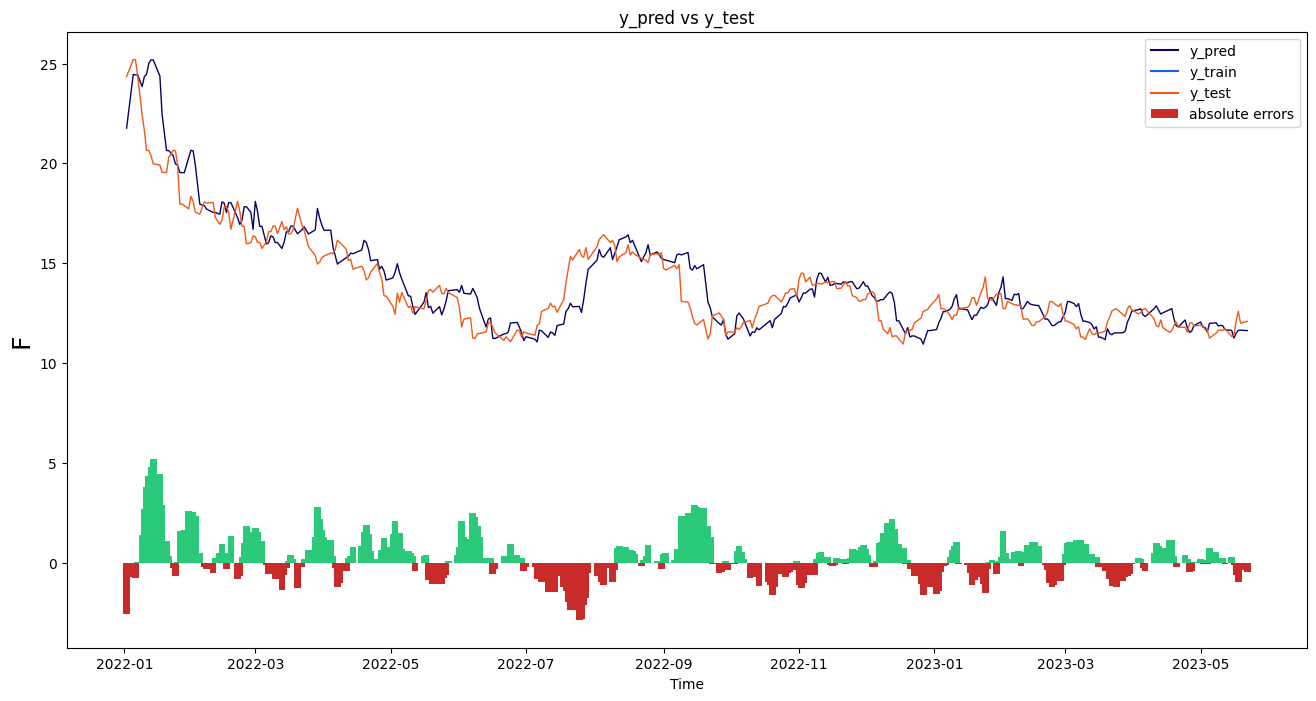

----------------------------------------------------- GM ----------------------------------------------------------------------------------------
(2067, 9) (2067, 1)
(516, 9) (516, 1)
Con pct_change
r2: -0.04962502349018583
Mean Absolute Error (MAE): 0.0501
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.5009 %
Mean Quatratic Error (RMSE): 0.0634
Sin pct_change
r2: 0.9109984238629322
Mean Absolute Error (MAE): 2.2096
Mean Absolute Percentage Error (MAPE): 5.1498 %
Median Absolute Percentage Error (MDAPE): 4.226 %
Mean Quatratic Error (RMSE): 2.848


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


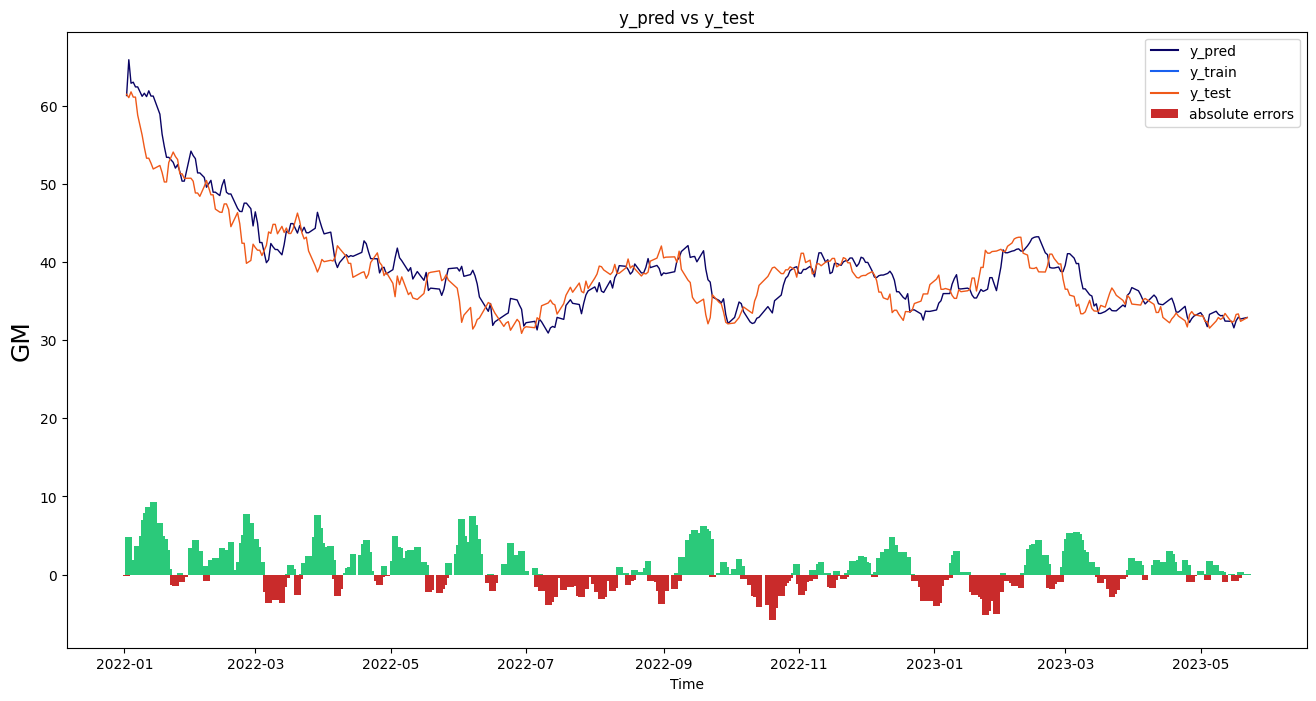

----------------------------------------------------- TSLA ----------------------------------------------------------------------------------------
(2132, 5) (2132, 1)
(533, 5) (533, 1)
Con pct_change
r2: -0.7491165706879919
Mean Absolute Error (MAE): 0.0962
Mean Absolute Percentage Error (MAPE): 1265.1385 %
Median Absolute Percentage Error (MDAPE): 115.814 %
Mean Quatratic Error (RMSE): 0.1305
Sin pct_change
r2: 0.6407696499398243
Mean Absolute Error (MAE): 26.0653
Mean Absolute Percentage Error (MAPE): 9.9183 %
Median Absolute Percentage Error (MDAPE): 6.7913 %
Mean Quatratic Error (RMSE): 40.0312


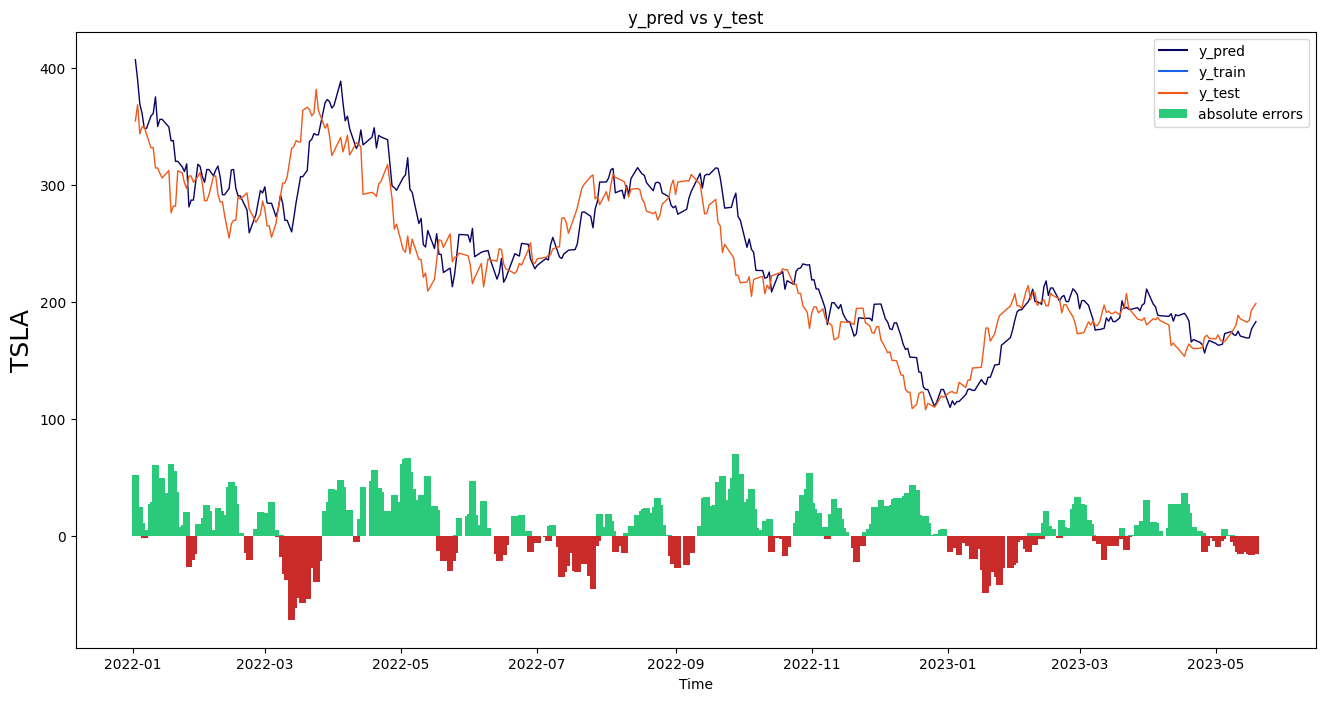

----------------------------------------------------- RACE ----------------------------------------------------------------------------------------
(978, 3) (978, 1)
(244, 3) (244, 1)
Con pct_change
r2: -0.1267372936901765
Mean Absolute Error (MAE): 0.0321
Mean Absolute Percentage Error (MAPE): 99.8907 %
Median Absolute Percentage Error (MDAPE): 99.9857 %
Mean Quatratic Error (RMSE): 0.0396
Sin pct_change
r2: 0.9361633664189986
Mean Absolute Error (MAE): 7.1886
Mean Absolute Percentage Error (MAPE): 3.1365 %
Median Absolute Percentage Error (MDAPE): 2.697 %
Mean Quatratic Error (RMSE): 8.7654


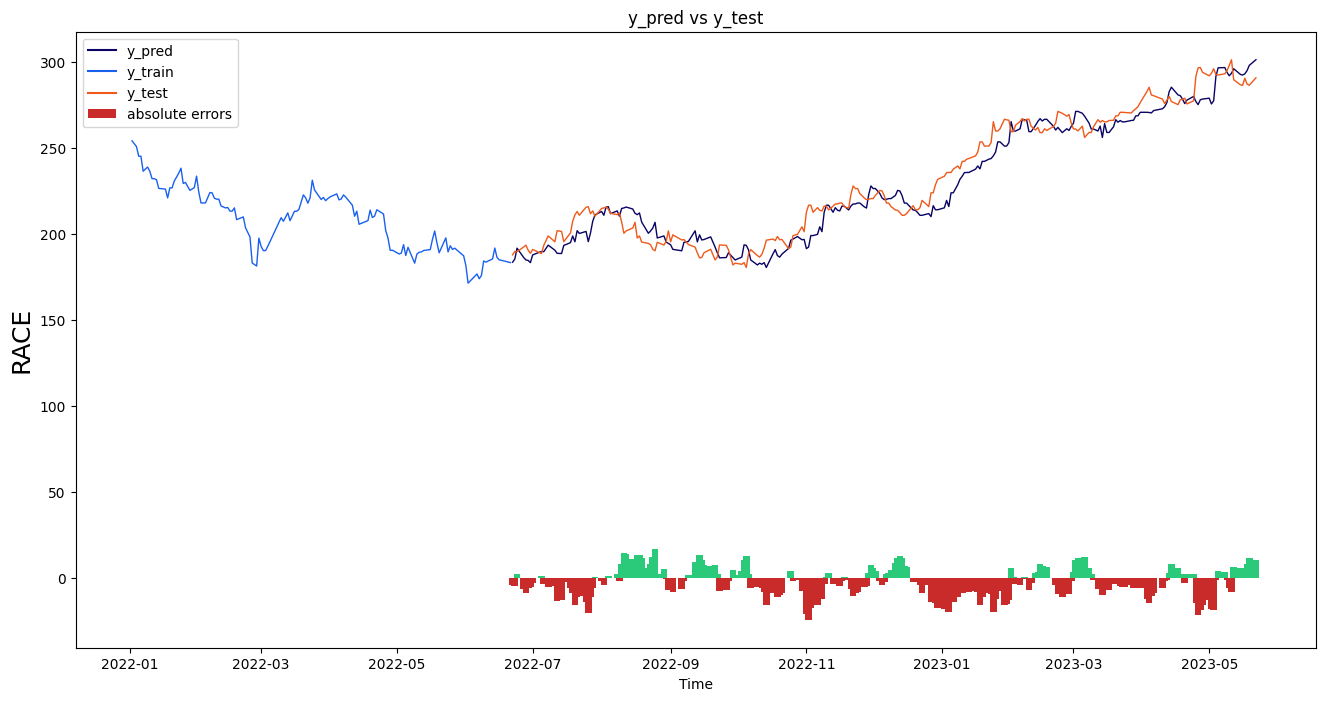

----------------------------------------------------- TM ----------------------------------------------------------------------------------------
(3840, 2) (3840, 1)
(960, 2) (960, 1)
Con pct_change
r2: -0.0021075118333901965
Mean Absolute Error (MAE): 0.0278
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 102.959 %
Mean Quatratic Error (RMSE): 0.0367
Sin pct_change
r2: 0.9191638213377827
Mean Absolute Error (MAE): 4.2727
Mean Absolute Percentage Error (MAPE): 2.79 %
Median Absolute Percentage Error (MDAPE): 2.1439 %
Mean Quatratic Error (RMSE): 5.7338


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


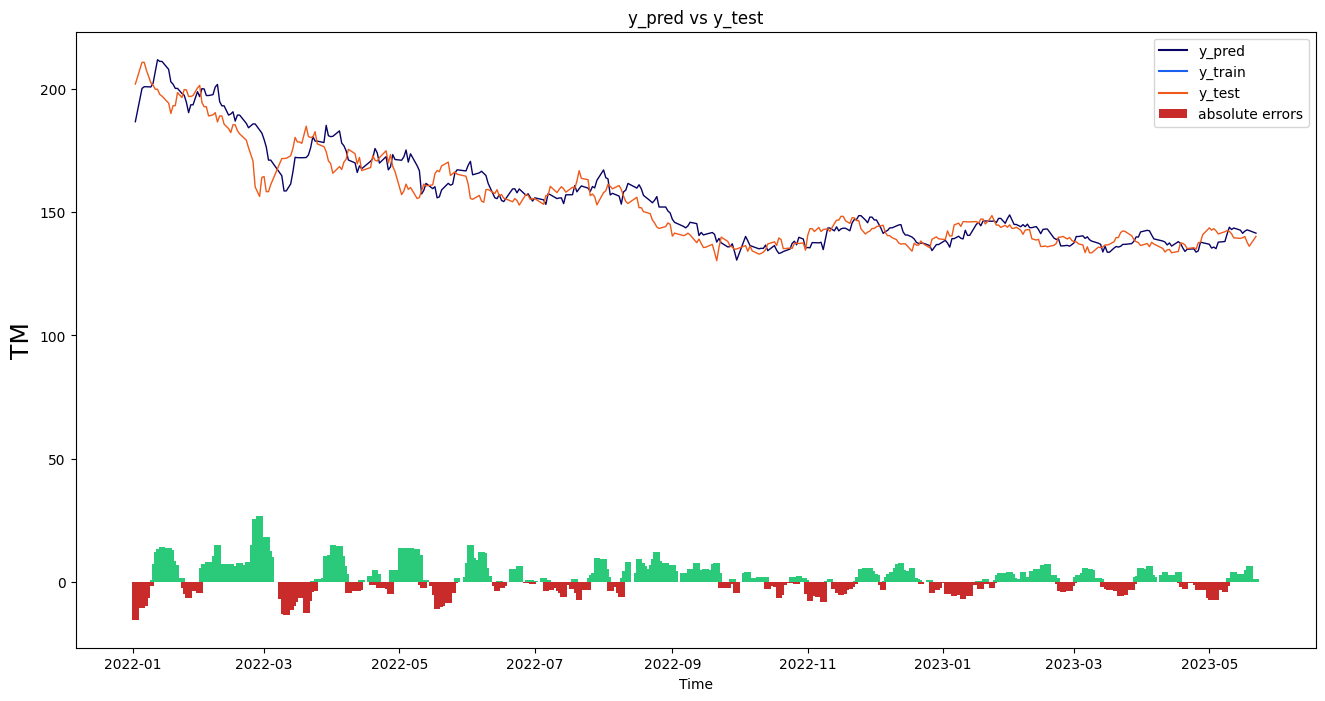

----------------------------------------------------- HMC ----------------------------------------------------------------------------------------
(4192, 3) (4192, 1)
(1047, 3) (1047, 1)
Con pct_change
r2: -0.0030890050255507617
Mean Absolute Error (MAE): 0.0304
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 101.9819 %
Mean Quatratic Error (RMSE): 0.0413
Sin pct_change
r2: 0.8387913212910592
Mean Absolute Error (MAE): 0.8095
Mean Absolute Percentage Error (MAPE): 3.0412 %
Median Absolute Percentage Error (MDAPE): 2.2934 %
Mean Quatratic Error (RMSE): 1.0834


<ipython-input-8-08ee7f59fe45>:9: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
<ipython-input-8-08ee7f59fe45>:12: RuntimeWarning: divide by zero encountered in true_divide
  MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100


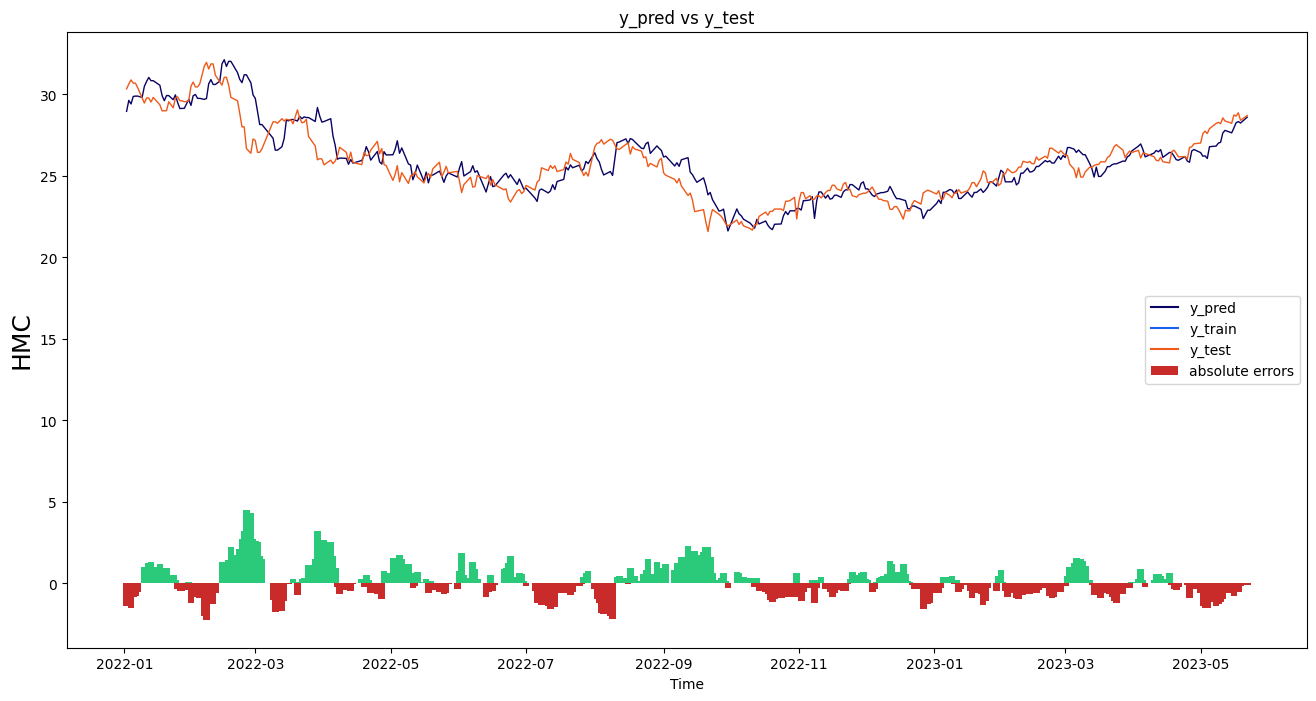

In [101]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8 )